In [40]:
import os
from PIL import Image
import json

def load_images_from_directory(root_path: str):
    """
    Load images from a directory with subfolders named after ImageNet labels.
    Return a list of (image, label, filename) triples.
    """
    dataset = []
    
    # Iterate over each subfolder
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        
        # Check if it's indeed a folder
        if os.path.isdir(label_path):
            
            # Iterate over each image in the subfolder
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                
                # Check if it's an image file
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))  # Add image filename here
    
    return dataset


current_dir = "/home/workstation/code/XAImethods/hf_cam_dev"

dataset_path = f"{current_dir}/imagenet-mini/val"
dataset = load_images_from_directory(dataset_path)


with open(f"{current_dir}/ImageNet-Mini/imagenet_class_index.json", "r") as f:
    imagenet_class_index = json.load(f)


label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}



In [41]:
#all
from tqdm import tqdm
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from transformers import ViTForImageClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from scipy.special import kl_div as scipy_kl_div
from scipy.special import softmax
from sklearn.metrics import precision_score, recall_score, f1_score

from difflib import get_close_matches

def closest_match(description: str, possible_descriptions: list) -> str:
    """
    Find the closest match for the given description in the list of possible descriptions.
    """
    matches = get_close_matches(description, possible_descriptions, n=1, cutoff=0.5)
    return matches[0] if matches else description

def predict_scores_for_classes(model, img_path):
    if not os.path.exists(img_path):
        return None
    img = Image.open(img_path)
    img = img.resize((384, 384))
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
    logits = model(img_tensor).logits[0].cpu().detach().numpy()
    return logits

def get_top_n_classes(scores, n=5):
    return set(np.argsort(scores)[-n:])

def calculate_jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_dice_similarity(set1, set2):
    return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))

def calculate_cosine_similarity(vec1, vec2):
    similarity = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    normalized_similarity = (similarity + 1) / 2
    return normalized_similarity

def calculate_euclidean_distance(vec1, vec2):
    distance = pairwise_distances(vec1.reshape(1, -1), vec2.reshape(1, -1), metric='euclidean')[0][0]
    normalized_distance = distance / np.sqrt(len(vec1))
    return normalized_distance

def calculate_kl_divergence(vec1, vec2):
    prob1 = softmax(vec1)
    prob2 = softmax(vec2)
    
    kl_div_value = scipy_kl_div(prob1, prob2).sum()
    normalized_kl_div = kl_div_value / np.log(len(vec1))
    return normalized_kl_div

def calculate_weighted_jaccard_similarity(vec1, vec2):
    min_sum = sum([min(a, b) for a, b in zip(vec1, vec2)])
    max_sum = sum([max(a, b) for a, b in zip(vec1, vec2)])
    return min_sum / max_sum if max_sum != 0 else 0

def calculate_prediction_changes(original_scores, masked_scores, top_n_indices):
    # Assuming top_n_indices contains only one index for top1
    idx = top_n_indices[0]
    
    original_score = original_scores[idx]
    masked_score = masked_scores[idx]
    
    change = max(0, original_score - masked_score)  # Set to 0 if negative
    
    # Calculate the percentage change
    if original_score > 0:
        percentage = change / original_score
    elif original_score < 0:
        percentage = change / abs(original_score)
    else:
        percentage = 0
    
    return change, percentage




def calculate_similarities(original_scores, masked_scores, top_n_values=[1, 5, 10, 50], metrics=["jaccard", "dice", "cosine", "euclidean", "kl", "weighted_jaccard", "prediction_change"]):
    results = {}
    
    for n in top_n_values:
        top_n_original = get_top_n_classes(original_scores, n)
        top_n_masked = get_top_n_classes(masked_scores, n)
        top_n_original_indices = np.argsort(original_scores)[-n:]

        for metric in metrics:
            if metric == "jaccard":
                jaccard_similarity = calculate_jaccard_similarity(top_n_original, top_n_masked)
                results[f"Jaccard_Top_{n}"] = jaccard_similarity
            
            if metric == "dice":
                dice_similarity = calculate_dice_similarity(top_n_original, top_n_masked)
                results[f"Dice_Top_{n}"] = dice_similarity
                
            if metric == "cosine":
                cosine_sim = calculate_cosine_similarity(original_scores, masked_scores)
                results[f"Cosine_Top_{n}"] = cosine_sim

            if metric == "euclidean":
                euclidean_dist = calculate_euclidean_distance(original_scores, masked_scores)
                results[f"Euclidean_Top_{n}"] = euclidean_dist

            if metric == "kl":
                kl_div = calculate_kl_divergence(original_scores, masked_scores)
                results[f"KL_Top_{n}"] = kl_div

            if metric == "weighted_jaccard":
                for n in top_n_values:
                    original_top_n_indices = np.argsort(original_scores)[-n:]
                    original_top_n_values = original_scores[original_top_n_indices]
                    
                    masked_top_n_indices = np.argsort(masked_scores)[-n:]
                    masked_top_n_values = masked_scores[masked_top_n_indices]
                    
                    weighted_jaccard_sim = calculate_weighted_jaccard_similarity(original_top_n_values, masked_top_n_values)
                    results[f"Weighted_Jaccard_Top_{n}"] = weighted_jaccard_sim

            if metric == "prediction_change":
                prediction_change, prediction_change_percentage = calculate_prediction_changes(original_scores, masked_scores, top_n_original_indices)
                results["Prediction_Change_Top1"] = prediction_change
                results["Prediction_Change_Percentage_Top1"] = prediction_change_percentage

                
    return results


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)

masking_root_folder = "/home/workstation/code/XAImethods/hf_cam_dev/evaluation/google/vit-large-patch32-384/GradCAM"

# Metrics to calculate
#selected_metrics = ["jaccard", "dice", "cosine", "euclidean", "kl", "weighted_jaccard", "prediction_change"]
selected_metrics = ["kl", "weighted_jaccard", "prediction_change"]


true_labels = []
original_predictions = []
masked_predictions = []

possible_descriptions = list(label_to_index_description.keys())

for subfolder in tqdm(os.listdir(masking_root_folder)):
    subfolder_path = os.path.join(masking_root_folder, subfolder)
    if os.path.isdir(subfolder_path):
        original_image_path = os.path.join(subfolder_path, 'original.jpg')
        masked_image_path = os.path.join(subfolder_path, 'masked_image.jpg')
        
        # Load true label (ensuring it's a label and not a description)
        with open(os.path.join(subfolder_path, 'true_label.txt'), 'r') as f:
            true_label = f.readline().strip()
            true_labels.append(label_to_index_description[true_label][0])  # Convert description to label
        
        original_scores = predict_scores_for_classes(model, original_image_path)
        masked_scores = predict_scores_for_classes(model, masked_image_path)

        if original_scores is None or masked_scores is None:
            #print(f"Skipping folder {subfolder_path} due to missing scores.")
            continue

        original_pred = np.argmax(original_scores)
        masked_pred = np.argmax(masked_scores)
        
        # Convert description to closest matching label
        original_desc = model.config.id2label[original_pred]
        closest_original_desc = closest_match(original_desc, possible_descriptions)
        if closest_original_desc not in label_to_index_description:
            #print(f"Couldn't find a match for {closest_original_desc}. Skipping this image.")
            continue
        original_predictions.append(label_to_index_description[closest_original_desc][0])
        
        masked_desc = model.config.id2label[masked_pred]
        closest_masked_desc = closest_match(masked_desc, possible_descriptions)
        if closest_masked_desc not in label_to_index_description:
            #print(f"Couldn't find a match for {closest_masked_desc}. Skipping this image.")
            continue
        masked_predictions.append(label_to_index_description[closest_masked_desc][0])



        
        similarities = calculate_similarities(original_scores, masked_scores, metrics=selected_metrics)
        np.save(os.path.join(subfolder_path, 'similarity_metrics.npy'), similarities)

        # Load back and print to verify
        loaded_similarities = np.load(os.path.join(subfolder_path, 'similarity_metrics.npy'), allow_pickle=True).item()

original_precision = precision_score(true_labels, original_predictions, average='micro', zero_division=1)
original_recall = recall_score(true_labels, original_predictions, average='micro', zero_division=1)
original_f1 = f1_score(true_labels, original_predictions, average='micro')

masked_precision = precision_score(true_labels, masked_predictions, average='micro', zero_division=1)
masked_recall = recall_score(true_labels, masked_predictions, average='micro', zero_division=1)
masked_f1 = f1_score(true_labels, masked_predictions, average='micro')

print(f"Original images - Precision: {original_precision}, Recall: {original_recall}, F1: {original_f1}")
print(f"Masked images - Precision: {masked_precision}, Recall: {masked_recall}, F1: {masked_f1}")




  0%|          | 2/3923 [00:00<04:34, 14.29it/s]

Couldn't find a match for grille, radiator grille. Skipping this image.
Couldn't find a match for lipstick, lip rouge. Skipping this image.
Couldn't find a match for wallaby, brush kangaroo. Skipping this image.


  0%|          | 6/3923 [00:00<04:03, 16.06it/s]

Couldn't find a match for flatworm, platyhelminth. Skipping this image.
Couldn't find a match for radio, wireless. Skipping this image.
Couldn't find a match for sandal. Skipping this image.
Couldn't find a match for Bouvier des Flandres, Bouviers des Flandres. Skipping this image.


  0%|          | 10/3923 [00:00<03:49, 17.02it/s]

Couldn't find a match for shower cap. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for doormat, welcome mat. Skipping this image.
Couldn't find a match for Ibizan hound, Ibizan Podenco. Skipping this image.


  0%|          | 14/3923 [00:00<03:47, 17.19it/s]

Couldn't find a match for tiger beetle. Skipping this image.
Couldn't find a match for acorn. Skipping this image.
Couldn't find a match for flagpole, flagstaff. Skipping this image.
Couldn't find a match for crib, cot. Skipping this image.


  0%|          | 18/3923 [00:01<03:47, 17.15it/s]

Couldn't find a match for barber chair. Skipping this image.
Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.
Couldn't find a match for volleyball. Skipping this image.
Couldn't find a match for organ, pipe organ. Skipping this image.


  1%|          | 22/3923 [00:01<03:56, 16.47it/s]

Couldn't find a match for quilt, comforter, comfort, puff. Skipping this image.
Couldn't find a match for minibus. Skipping this image.
Couldn't find a match for teapot. Skipping this image.
Couldn't find a match for yurt. Skipping this image.


  1%|          | 26/3923 [00:01<04:00, 16.17it/s]

Couldn't find a match for hippopotamus, hippo, river horse, Hippopotamus amphibius. Skipping this image.
Couldn't find a match for isopod. Skipping this image.
Couldn't find a match for ice lolly, lolly, lollipop, popsicle. Skipping this image.
Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.


  1%|          | 30/3923 [00:01<03:50, 16.86it/s]

Couldn't find a match for web site, website, internet site, site. Skipping this image.
Couldn't find a match for barometer. Skipping this image.
Couldn't find a match for lampshade, lamp shade. Skipping this image.
Couldn't find a match for holster. Skipping this image.


  1%|          | 34/3923 [00:02<04:04, 15.92it/s]

Couldn't find a match for ibex, Capra ibex. Skipping this image.
Couldn't find a match for chiffonier, commode. Skipping this image.
Couldn't find a match for catamaran. Skipping this image.
Couldn't find a match for bikini, two-piece. Skipping this image.


  1%|          | 38/3923 [00:02<03:51, 16.76it/s]

Couldn't find a match for skunk, polecat, wood pussy. Skipping this image.
Couldn't find a match for prison, prison house. Skipping this image.
Couldn't find a match for miniature schnauzer. Skipping this image.
Couldn't find a match for envelope. Skipping this image.


  1%|          | 42/3923 [00:02<03:45, 17.22it/s]

Couldn't find a match for organ, pipe organ. Skipping this image.
Couldn't find a match for impala, Aepyceros melampus. Skipping this image.
Couldn't find a match for sorrel. Skipping this image.
Couldn't find a match for dishwasher, dish washer, dishwashing machine. Skipping this image.


  1%|          | 46/3923 [00:02<03:50, 16.82it/s]

Couldn't find a match for apiary, bee house. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for web site, website, internet site, site. Skipping this image.
Couldn't find a match for warthog. Skipping this image.


  1%|▏         | 50/3923 [00:02<03:48, 16.93it/s]

Couldn't find a match for Shetland sheepdog, Shetland sheep dog, Shetland. Skipping this image.
Couldn't find a match for diamondback, diamondback rattlesnake, Crotalus adamanteus. Skipping this image.
Couldn't find a match for borzoi, Russian wolfhound. Skipping this image.
Couldn't find a match for pencil box, pencil case. Skipping this image.


  1%|▏         | 54/3923 [00:03<04:05, 15.79it/s]

Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for liner, ocean liner. Skipping this image.
Couldn't find a match for breakwater, groin, groyne, mole, bulwark, seawall, jetty. Skipping this image.
Couldn't find a match for matchstick. Skipping this image.


  1%|▏         | 58/3923 [00:03<04:05, 15.73it/s]

Couldn't find a match for spatula. Skipping this image.
Couldn't find a match for chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour. Skipping this image.
Couldn't find a match for joystick. Skipping this image.
Couldn't find a match for flamingo. Skipping this image.


  2%|▏         | 62/3923 [00:03<03:53, 16.53it/s]

Couldn't find a match for banjo. Skipping this image.
Couldn't find a match for tiger cat. Skipping this image.
Couldn't find a match for spotlight, spot. Skipping this image.


  2%|▏         | 66/3923 [00:04<04:05, 15.72it/s]

Couldn't find a match for bicycle-built-for-two, tandem bicycle, tandem. Skipping this image.
Couldn't find a match for crutch. Skipping this image.
Couldn't find a match for CD player. Skipping this image.
Couldn't find a match for home theater, home theatre. Skipping this image.


  2%|▏         | 70/3923 [00:04<04:07, 15.56it/s]

Couldn't find a match for reel. Skipping this image.
Couldn't find a match for pickelhaube. Skipping this image.
Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for pitcher, ewer. Skipping this image.


  2%|▏         | 74/3923 [00:04<03:51, 16.64it/s]

Couldn't find a match for acorn. Skipping this image.
Couldn't find a match for oxygen mask. Skipping this image.
Couldn't find a match for green lizard, Lacerta viridis. Skipping this image.
Couldn't find a match for schooner. Skipping this image.


  2%|▏         | 78/3923 [00:04<03:45, 17.08it/s]

Couldn't find a match for American black bear, black bear, Ursus americanus, Euarctos americanus. Skipping this image.
Couldn't find a match for Border terrier. Skipping this image.
Couldn't find a match for hornbill. Skipping this image.
Couldn't find a match for combination lock. Skipping this image.


  2%|▏         | 82/3923 [00:04<03:38, 17.57it/s]

Couldn't find a match for jack-o'-lantern. Skipping this image.
Couldn't find a match for schipperke. Skipping this image.
Couldn't find a match for pretzel. Skipping this image.
Couldn't find a match for siamang, Hylobates syndactylus, Symphalangus syndactylus. Skipping this image.


  2%|▏         | 86/3923 [00:05<03:39, 17.48it/s]

Couldn't find a match for flute, transverse flute. Skipping this image.
Couldn't find a match for organ, pipe organ. Skipping this image.
Couldn't find a match for triumphal arch. Skipping this image.
Couldn't find a match for military uniform. Skipping this image.


  2%|▏         | 90/3923 [00:05<03:39, 17.43it/s]

Couldn't find a match for whippet. Skipping this image.
Couldn't find a match for joystick. Skipping this image.
Couldn't find a match for broccoli. Skipping this image.
Couldn't find a match for streetcar, tram, tramcar, trolley, trolley car. Skipping this image.


  2%|▏         | 94/3923 [00:05<03:51, 16.55it/s]

Couldn't find a match for monarch, monarch butterfly, milkweed butterfly, Danaus plexippus. Skipping this image.
Couldn't find a match for baseball. Skipping this image.
Couldn't find a match for envelope. Skipping this image.
Couldn't find a match for barrow, garden cart, lawn cart, wheelbarrow. Skipping this image.


  2%|▏         | 98/3923 [00:05<03:46, 16.89it/s]

Couldn't find a match for leafhopper. Skipping this image.
Couldn't find a match for tench, Tinca tinca. Skipping this image.
Couldn't find a match for mud turtle. Skipping this image.
Couldn't find a match for lotion. Skipping this image.


  3%|▎         | 102/3923 [00:06<03:39, 17.39it/s]

Couldn't find a match for bulbul. Skipping this image.
Couldn't find a match for hourglass. Skipping this image.
Couldn't find a match for cliff dwelling. Skipping this image.
Couldn't find a match for badger. Skipping this image.


  3%|▎         | 106/3923 [00:06<03:41, 17.25it/s]

Couldn't find a match for slide rule, slipstick. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for kelpie. Skipping this image.
Couldn't find a match for zebra. Skipping this image.


  3%|▎         | 110/3923 [00:06<03:40, 17.32it/s]

Couldn't find a match for coral reef. Skipping this image.
Couldn't find a match for African chameleon, Chamaeleo chamaeleon. Skipping this image.
Couldn't find a match for kuvasz. Skipping this image.
Couldn't find a match for kit fox, Vulpes macrotis. Skipping this image.


  3%|▎         | 112/3923 [00:06<04:38, 13.71it/s]

Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.


  3%|▎         | 116/3923 [00:07<04:09, 15.25it/s]

Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for toucan. Skipping this image.
Couldn't find a match for sturgeon. Skipping this image.
Couldn't find a match for chime, bell, gong. Skipping this image.


  3%|▎         | 120/3923 [00:07<04:06, 15.44it/s]

Couldn't find a match for cassette. Skipping this image.
Couldn't find a match for motor scooter, scooter. Skipping this image.
Couldn't find a match for wig. Skipping this image.
Couldn't find a match for whistle. Skipping this image.


  3%|▎         | 122/3923 [00:07<03:57, 16.03it/s]

Couldn't find a match for pedestal, plinth, footstall. Skipping this image.
Couldn't find a match for coral fungus. Skipping this image.
Couldn't find a match for doormat, welcome mat. Skipping this image.


  3%|▎         | 126/3923 [00:07<04:09, 15.24it/s]

Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for airliner. Skipping this image.
Couldn't find a match for meerkat, mierkat. Skipping this image.
Couldn't find a match for thatch, thatched roof. Skipping this image.


  3%|▎         | 130/3923 [00:07<03:53, 16.23it/s]

Couldn't find a match for otter. Skipping this image.
Couldn't find a match for envelope. Skipping this image.
Couldn't find a match for Scottish deerhound, deerhound. Skipping this image.
Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.


  3%|▎         | 134/3923 [00:08<03:49, 16.48it/s]

Couldn't find a match for gar, garfish, garpike, billfish, Lepisosteus osseus. Skipping this image.
Couldn't find a match for chambered nautilus, pearly nautilus, nautilus. Skipping this image.
Couldn't find a match for tiger, Panthera tigris. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.


  4%|▎         | 138/3923 [00:08<03:37, 17.38it/s]

Couldn't find a match for chocolate sauce, chocolate syrup. Skipping this image.
Couldn't find a match for otterhound, otter hound. Skipping this image.
Couldn't find a match for maillot, tank suit. Skipping this image.
Couldn't find a match for kit fox, Vulpes macrotis. Skipping this image.


  4%|▎         | 142/3923 [00:08<03:33, 17.72it/s]

Couldn't find a match for wall clock. Skipping this image.
Couldn't find a match for vending machine. Skipping this image.
Couldn't find a match for kite. Skipping this image.
Couldn't find a match for Maltese dog, Maltese terrier, Maltese. Skipping this image.


  4%|▎         | 146/3923 [00:08<03:31, 17.83it/s]

Couldn't find a match for projectile, missile. Skipping this image.
Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.
Couldn't find a match for Italian greyhound. Skipping this image.
Couldn't find a match for hot pot, hotpot. Skipping this image.


  4%|▍         | 150/3923 [00:09<03:31, 17.85it/s]

Couldn't find a match for valley, vale. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for Siamese cat, Siamese. Skipping this image.
Couldn't find a match for container ship, containership, container vessel. Skipping this image.


  4%|▍         | 154/3923 [00:09<03:39, 17.14it/s]

Couldn't find a match for water jug. Skipping this image.
Couldn't find a match for zebra. Skipping this image.
Couldn't find a match for coffee mug. Skipping this image.
Couldn't find a match for garbage truck, dustcart. Skipping this image.


  4%|▍         | 158/3923 [00:09<03:36, 17.41it/s]

Couldn't find a match for prison, prison house. Skipping this image.
Couldn't find a match for window screen. Skipping this image.
Couldn't find a match for wombat. Skipping this image.
Couldn't find a match for vault. Skipping this image.


  4%|▍         | 162/3923 [00:09<03:35, 17.44it/s]

Couldn't find a match for Shetland sheepdog, Shetland sheep dog, Shetland. Skipping this image.
Couldn't find a match for cheeseburger. Skipping this image.
Couldn't find a match for cornet, horn, trumpet, trump. Skipping this image.
Couldn't find a match for sombrero. Skipping this image.


  4%|▍         | 166/3923 [00:10<03:55, 15.94it/s]

Couldn't find a match for African grey, African gray, Psittacus erithacus. Skipping this image.
Couldn't find a match for garden spider, Aranea diademata. Skipping this image.
Couldn't find a match for necklace. Skipping this image.
Couldn't find a match for bull mastiff. Skipping this image.


  4%|▍         | 170/3923 [00:10<03:40, 17.01it/s]

Couldn't find a match for toaster. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for common iguana, iguana, Iguana iguana. Skipping this image.


  4%|▍         | 174/3923 [00:10<03:51, 16.18it/s]

Couldn't find a match for hamper. Skipping this image.
Couldn't find a match for lumbermill, sawmill. Skipping this image.
Couldn't find a match for ballpoint, ballpoint pen, ballpen, Biro. Skipping this image.
Couldn't find a match for fig. Skipping this image.


  5%|▍         | 178/3923 [00:10<03:42, 16.86it/s]

Couldn't find a match for barrow, garden cart, lawn cart, wheelbarrow. Skipping this image.
Couldn't find a match for slug. Skipping this image.
Couldn't find a match for rain barrel. Skipping this image.
Couldn't find a match for cannon. Skipping this image.


  5%|▍         | 182/3923 [00:10<03:37, 17.22it/s]

Couldn't find a match for spotlight, spot. Skipping this image.
Couldn't find a match for Scotch terrier, Scottish terrier, Scottie. Skipping this image.
Couldn't find a match for tripod. Skipping this image.
Couldn't find a match for birdhouse. Skipping this image.


  5%|▍         | 186/3923 [00:11<03:36, 17.30it/s]

Couldn't find a match for pajama, pyjama, pj's, jammies. Skipping this image.
Couldn't find a match for thunder snake, worm snake, Carphophis amoenus. Skipping this image.
Couldn't find a match for parking meter. Skipping this image.
Couldn't find a match for suit, suit of clothes. Skipping this image.


  5%|▍         | 190/3923 [00:11<03:58, 15.63it/s]

Couldn't find a match for head cabbage. Skipping this image.
Couldn't find a match for mink. Skipping this image.
Couldn't find a match for sundial. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.


  5%|▍         | 194/3923 [00:11<04:06, 15.12it/s]

Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for bloodhound, sleuthhound. Skipping this image.
Couldn't find a match for Madagascar cat, ring-tailed lemur, Lemur catta. Skipping this image.


  5%|▌         | 198/3923 [00:11<04:01, 15.44it/s]

Couldn't find a match for Boston bull, Boston terrier. Skipping this image.
Couldn't find a match for Dutch oven. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.
Couldn't find a match for stopwatch, stop watch. Skipping this image.


  5%|▌         | 202/3923 [00:12<03:46, 16.42it/s]

Couldn't find a match for Band Aid. Skipping this image.
Couldn't find a match for fiddler crab. Skipping this image.
Couldn't find a match for water bottle. Skipping this image.
Couldn't find a match for bulbul. Skipping this image.


  5%|▌         | 206/3923 [00:12<03:42, 16.68it/s]

Couldn't find a match for parallel bars, bars. Skipping this image.
Couldn't find a match for electric locomotive. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.


  5%|▌         | 210/3923 [00:12<03:41, 16.79it/s]

Couldn't find a match for siamang, Hylobates syndactylus, Symphalangus syndactylus. Skipping this image.
Couldn't find a match for maillot. Skipping this image.
Couldn't find a match for maraca. Skipping this image.
Couldn't find a match for tiger, Panthera tigris. Skipping this image.


  5%|▌         | 214/3923 [00:12<03:51, 16.04it/s]

Couldn't find a match for torch. Skipping this image.
Couldn't find a match for corn. Skipping this image.
Couldn't find a match for spaghetti squash. Skipping this image.
Couldn't find a match for barn. Skipping this image.


  6%|▌         | 218/3923 [00:13<03:39, 16.90it/s]

Couldn't find a match for Persian cat. Skipping this image.
Couldn't find a match for dugong, Dugong dugon. Skipping this image.
Couldn't find a match for African chameleon, Chamaeleo chamaeleon. Skipping this image.
Couldn't find a match for Irish setter, red setter. Skipping this image.


  6%|▌         | 222/3923 [00:13<03:36, 17.07it/s]

Couldn't find a match for oxygen mask. Skipping this image.
Couldn't find a match for toilet tissue, toilet paper, bathroom tissue. Skipping this image.
Couldn't find a match for fireboat. Skipping this image.
Couldn't find a match for chainlink fence. Skipping this image.


  6%|▌         | 226/3923 [00:13<03:30, 17.55it/s]

Couldn't find a match for bustard. Skipping this image.
Couldn't find a match for missile. Skipping this image.
Couldn't find a match for bonnet, poke bonnet. Skipping this image.
Couldn't find a match for entertainment center. Skipping this image.


  6%|▌         | 230/3923 [00:13<03:29, 17.61it/s]

Couldn't find a match for cocker spaniel, English cocker spaniel, cocker. Skipping this image.
Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.
Couldn't find a match for clog, geta, patten, sabot. Skipping this image.
Couldn't find a match for upright, upright piano. Skipping this image.


  6%|▌         | 234/3923 [00:14<03:35, 17.12it/s]

Couldn't find a match for grey fox, gray fox, Urocyon cinereoargenteus. Skipping this image.
Couldn't find a match for guenon, guenon monkey. Skipping this image.
Couldn't find a match for wok. Skipping this image.
Couldn't find a match for Irish terrier. Skipping this image.


  6%|▌         | 238/3923 [00:14<03:32, 17.37it/s]

Couldn't find a match for mailbag, postbag. Skipping this image.
Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for black and gold garden spider, Argiope aurantia. Skipping this image.
Couldn't find a match for meerkat, mierkat. Skipping this image.


  6%|▌         | 242/3923 [00:14<03:37, 16.91it/s]

Couldn't find a match for lens cap, lens cover. Skipping this image.
Couldn't find a match for bucket, pail. Skipping this image.
Couldn't find a match for Petri dish. Skipping this image.
Couldn't find a match for hip, rose hip, rosehip. Skipping this image.


  6%|▋         | 246/3923 [00:14<03:28, 17.61it/s]

Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.
Couldn't find a match for slug. Skipping this image.
Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.
Couldn't find a match for fly. Skipping this image.


  6%|▋         | 250/3923 [00:14<03:30, 17.41it/s]

Couldn't find a match for Polaroid camera, Polaroid Land camera. Skipping this image.
Couldn't find a match for coucal. Skipping this image.
Couldn't find a match for laptop, laptop computer. Skipping this image.
Couldn't find a match for frilled lizard, Chlamydosaurus kingi. Skipping this image.


  6%|▋         | 254/3923 [00:15<03:26, 17.76it/s]

Couldn't find a match for amphibian, amphibious vehicle. Skipping this image.
Couldn't find a match for American lobster, Northern lobster, Maine lobster, Homarus americanus. Skipping this image.
Couldn't find a match for Saint Bernard, St Bernard. Skipping this image.
Couldn't find a match for cleaver, meat cleaver, chopper. Skipping this image.


  7%|▋         | 258/3923 [00:15<03:29, 17.50it/s]

Couldn't find a match for American egret, great white heron, Egretta albus. Skipping this image.
Couldn't find a match for rule, ruler. Skipping this image.
Couldn't find a match for soft-coated wheaten terrier. Skipping this image.
Couldn't find a match for switch, electric switch, electrical switch. Skipping this image.


  7%|▋         | 262/3923 [00:15<03:30, 17.35it/s]

Couldn't find a match for vault. Skipping this image.
Couldn't find a match for muzzle. Skipping this image.
Couldn't find a match for garden spider, Aranea diademata. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.


  7%|▋         | 266/3923 [00:15<03:31, 17.31it/s]

Couldn't find a match for Pembroke, Pembroke Welsh corgi. Skipping this image.
Couldn't find a match for vending machine. Skipping this image.
Couldn't find a match for cowboy boot. Skipping this image.
Couldn't find a match for ballpoint, ballpoint pen, ballpen, Biro. Skipping this image.


  7%|▋         | 270/3923 [00:16<03:29, 17.47it/s]

Couldn't find a match for saltshaker, salt shaker. Skipping this image.
Couldn't find a match for grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus. Skipping this image.
Couldn't find a match for beagle. Skipping this image.
Couldn't find a match for boa constrictor, Constrictor constrictor. Skipping this image.


  7%|▋         | 272/3923 [00:16<03:30, 17.32it/s]

Couldn't find a match for beaver. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for prison, prison house. Skipping this image.


  7%|▋         | 276/3923 [00:16<03:49, 15.88it/s]

Couldn't find a match for hook, claw. Skipping this image.
Couldn't find a match for tow truck, tow car, wrecker. Skipping this image.
Couldn't find a match for mountain tent. Skipping this image.


  7%|▋         | 280/3923 [00:16<03:46, 16.10it/s]

Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.
Couldn't find a match for volcano. Skipping this image.
Couldn't find a match for go-kart. Skipping this image.
Couldn't find a match for mailbag, postbag. Skipping this image.


  7%|▋         | 284/3923 [00:16<03:31, 17.19it/s]

Couldn't find a match for lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens. Skipping this image.
Couldn't find a match for Bedlington terrier. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.


  7%|▋         | 288/3923 [00:17<03:36, 16.81it/s]

Couldn't find a match for trolleybus, trolley coach, trackless trolley. Skipping this image.
Couldn't find a match for Pekinese, Pekingese, Peke. Skipping this image.
Couldn't find a match for volcano. Skipping this image.
Couldn't find a match for face powder. Skipping this image.


  7%|▋         | 292/3923 [00:17<03:41, 16.41it/s]

Couldn't find a match for desk. Skipping this image.
Couldn't find a match for sliding door. Skipping this image.
Couldn't find a match for sock. Skipping this image.
Couldn't find a match for hognose snake, puff adder, sand viper. Skipping this image.


  8%|▊         | 296/3923 [00:17<03:49, 15.80it/s]

Couldn't find a match for streetcar, tram, tramcar, trolley, trolley car. Skipping this image.
Couldn't find a match for saltshaker, salt shaker. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.
Couldn't find a match for barrel, cask. Skipping this image.


  8%|▊         | 300/3923 [00:18<03:47, 15.96it/s]

Couldn't find a match for sandal. Skipping this image.
Couldn't find a match for bucket, pail. Skipping this image.
Couldn't find a match for ostrich, Struthio camelus. Skipping this image.
Couldn't find a match for acoustic guitar. Skipping this image.


  8%|▊         | 304/3923 [00:18<03:42, 16.23it/s]

Couldn't find a match for Bedlington terrier. Skipping this image.
Couldn't find a match for mortarboard. Skipping this image.
Couldn't find a match for shopping basket. Skipping this image.
Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.


  8%|▊         | 308/3923 [00:18<03:34, 16.86it/s]

Couldn't find a match for little blue heron, Egretta caerulea. Skipping this image.
Couldn't find a match for measuring cup. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for fire engine, fire truck. Skipping this image.


  8%|▊         | 312/3923 [00:18<03:29, 17.25it/s]

Couldn't find a match for howler monkey, howler. Skipping this image.
Couldn't find a match for submarine, pigboat, sub, U-boat. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for bolete. Skipping this image.


  8%|▊         | 316/3923 [00:18<03:29, 17.18it/s]

Couldn't find a match for bison. Skipping this image.
Couldn't find a match for vine snake. Skipping this image.
Couldn't find a match for gas pump, gasoline pump, petrol pump, island dispenser. Skipping this image.
Couldn't find a match for picket fence, paling. Skipping this image.


  8%|▊         | 320/3923 [00:19<03:34, 16.77it/s]

Couldn't find a match for gas pump, gasoline pump, petrol pump, island dispenser. Skipping this image.
Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for macaw. Skipping this image.
Couldn't find a match for hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa. Skipping this image.


  8%|▊         | 324/3923 [00:19<03:31, 17.05it/s]

Couldn't find a match for shopping cart. Skipping this image.
Couldn't find a match for bicycle-built-for-two, tandem bicycle, tandem. Skipping this image.
Couldn't find a match for tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.


  8%|▊         | 328/3923 [00:19<03:28, 17.21it/s]

Couldn't find a match for plane, carpenter's plane, woodworking plane. Skipping this image.
Couldn't find a match for giant schnauzer. Skipping this image.
Couldn't find a match for lynx, catamount. Skipping this image.
Couldn't find a match for tench, Tinca tinca. Skipping this image.


  8%|▊         | 332/3923 [00:19<03:30, 17.08it/s]

Couldn't find a match for Madagascar cat, ring-tailed lemur, Lemur catta. Skipping this image.
Couldn't find a match for Staffordshire bullterrier, Staffordshire bull terrier. Skipping this image.
Couldn't find a match for long-horned beetle, longicorn, longicorn beetle. Skipping this image.
Couldn't find a match for pillow. Skipping this image.


  9%|▊         | 334/3923 [00:20<03:35, 16.68it/s]

Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk. Skipping this image.
Couldn't find a match for lotion. Skipping this image.


  9%|▊         | 338/3923 [00:20<03:51, 15.45it/s]

Couldn't find a match for Granny Smith. Skipping this image.
Couldn't find a match for ping-pong ball. Skipping this image.
Couldn't find a match for albatross, mollymawk. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.


  9%|▊         | 342/3923 [00:20<03:42, 16.07it/s]

Couldn't find a match for Boston bull, Boston terrier. Skipping this image.
Couldn't find a match for beagle. Skipping this image.
Couldn't find a match for altar. Skipping this image.
Couldn't find a match for carton. Skipping this image.


  9%|▉         | 346/3923 [00:20<03:32, 16.81it/s]

Couldn't find a match for Shetland sheepdog, Shetland sheep dog, Shetland. Skipping this image.
Couldn't find a match for necklace. Skipping this image.
Couldn't find a match for chow, chow chow. Skipping this image.
Couldn't find a match for slide rule, slipstick. Skipping this image.


  9%|▉         | 350/3923 [00:20<03:27, 17.24it/s]

Couldn't find a match for steel arch bridge. Skipping this image.
Couldn't find a match for water jug. Skipping this image.
Couldn't find a match for Chesapeake Bay retriever. Skipping this image.
Couldn't find a match for Gila monster, Heloderma suspectum. Skipping this image.


  9%|▉         | 354/3923 [00:21<03:28, 17.08it/s]

Couldn't find a match for wok. Skipping this image.
Couldn't find a match for ocarina, sweet potato. Skipping this image.
Couldn't find a match for German shepherd, German shepherd dog, German police dog, alsatian. Skipping this image.
Couldn't find a match for rock crab, Cancer irroratus. Skipping this image.


  9%|▉         | 358/3923 [00:21<03:22, 17.58it/s]

Couldn't find a match for squirrel monkey, Saimiri sciureus. Skipping this image.
Couldn't find a match for chain saw, chainsaw. Skipping this image.
Couldn't find a match for pill bottle. Skipping this image.
Couldn't find a match for oxygen mask. Skipping this image.


  9%|▉         | 362/3923 [00:21<03:24, 17.43it/s]

Couldn't find a match for spider monkey, Ateles geoffroyi. Skipping this image.
Couldn't find a match for cicada, cicala. Skipping this image.
Couldn't find a match for Appenzeller. Skipping this image.
Couldn't find a match for bison. Skipping this image.


  9%|▉         | 366/3923 [00:21<03:25, 17.33it/s]

Couldn't find a match for European fire salamander, Salamandra salamandra. Skipping this image.
Couldn't find a match for car mirror. Skipping this image.
Couldn't find a match for jaguar, panther, Panthera onca, Felis onca. Skipping this image.
Couldn't find a match for water buffalo, water ox, Asiatic buffalo, Bubalus bubalis. Skipping this image.


  9%|▉         | 370/3923 [00:22<03:29, 16.95it/s]

Couldn't find a match for harvester, reaper. Skipping this image.
Couldn't find a match for broccoli. Skipping this image.
Couldn't find a match for trombone. Skipping this image.
Couldn't find a match for container ship, containership, container vessel. Skipping this image.


 10%|▉         | 374/3923 [00:22<03:27, 17.14it/s]

Couldn't find a match for green lizard, Lacerta viridis. Skipping this image.
Couldn't find a match for Bedlington terrier. Skipping this image.
Couldn't find a match for keeshond. Skipping this image.
Couldn't find a match for apron. Skipping this image.


 10%|▉         | 378/3923 [00:22<03:29, 16.91it/s]

Couldn't find a match for sandbar, sand bar. Skipping this image.
Couldn't find a match for seat belt, seatbelt. Skipping this image.
Couldn't find a match for missile. Skipping this image.
Couldn't find a match for centipede. Skipping this image.


 10%|▉         | 382/3923 [00:22<03:37, 16.29it/s]

Couldn't find a match for fireboat. Skipping this image.
Couldn't find a match for ringneck snake, ring-necked snake, ring snake. Skipping this image.
Couldn't find a match for Shih-Tzu. Skipping this image.
Couldn't find a match for oxcart. Skipping this image.


 10%|▉         | 386/3923 [00:23<03:29, 16.85it/s]

Couldn't find a match for space heater. Skipping this image.
Couldn't find a match for gown. Skipping this image.
Couldn't find a match for liner, ocean liner. Skipping this image.
Couldn't find a match for junco, snowbird. Skipping this image.


 10%|▉         | 390/3923 [00:23<03:40, 16.02it/s]

Couldn't find a match for Indian cobra, Naja naja. Skipping this image.
Couldn't find a match for clog, geta, patten, sabot. Skipping this image.
Couldn't find a match for collie. Skipping this image.
Couldn't find a match for Chihuahua. Skipping this image.


 10%|█         | 394/3923 [00:23<03:31, 16.65it/s]

Couldn't find a match for toucan. Skipping this image.
Couldn't find a match for brass, memorial tablet, plaque. Skipping this image.
Couldn't find a match for three-toed sloth, ai, Bradypus tridactylus. Skipping this image.
Couldn't find a match for trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi. Skipping this image.


 10%|█         | 398/3923 [00:23<03:50, 15.31it/s]

Couldn't find a match for hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa. Skipping this image.
Couldn't find a match for book jacket, dust cover, dust jacket, dust wrapper. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.


 10%|█         | 402/3923 [00:24<03:37, 16.18it/s]

Couldn't find a match for boa constrictor, Constrictor constrictor. Skipping this image.
Couldn't find a match for frying pan, frypan, skillet. Skipping this image.
Couldn't find a match for box turtle, box tortoise. Skipping this image.
Couldn't find a match for white stork, Ciconia ciconia. Skipping this image.


 10%|█         | 406/3923 [00:24<03:32, 16.57it/s]

Couldn't find a match for Ibizan hound, Ibizan Podenco. Skipping this image.
Couldn't find a match for porcupine, hedgehog. Skipping this image.
Couldn't find a match for window shade. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.


 10%|█         | 410/3923 [00:24<03:25, 17.10it/s]

Couldn't find a match for switch, electric switch, electrical switch. Skipping this image.
Couldn't find a match for badger. Skipping this image.
Couldn't find a match for minivan. Skipping this image.
Couldn't find a match for ptarmigan. Skipping this image.


 11%|█         | 414/3923 [00:24<03:21, 17.45it/s]

Couldn't find a match for Madagascar cat, ring-tailed lemur, Lemur catta. Skipping this image.
Couldn't find a match for French loaf. Skipping this image.
Couldn't find a match for Yorkshire terrier. Skipping this image.
Couldn't find a match for vestment. Skipping this image.


 11%|█         | 418/3923 [00:25<03:30, 16.67it/s]

Couldn't find a match for tricycle, trike, velocipede. Skipping this image.
Couldn't find a match for patas, hussar monkey, Erythrocebus patas. Skipping this image.
Couldn't find a match for shield, buckler. Skipping this image.
Couldn't find a match for odometer, hodometer, mileometer, milometer. Skipping this image.


 11%|█         | 422/3923 [00:25<03:35, 16.28it/s]

Couldn't find a match for swab, swob, mop. Skipping this image.
Couldn't find a match for cowboy hat, ten-gallon hat. Skipping this image.
Couldn't find a match for feather boa, boa. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.


 11%|█         | 426/3923 [00:25<03:32, 16.43it/s]

Couldn't find a match for chow, chow chow. Skipping this image.
Couldn't find a match for tree frog, tree-frog. Skipping this image.
Couldn't find a match for fountain. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.


 11%|█         | 430/3923 [00:25<03:46, 15.43it/s]

Couldn't find a match for lipstick, lip rouge. Skipping this image.
Couldn't find a match for space bar. Skipping this image.
Couldn't find a match for cannon. Skipping this image.
Couldn't find a match for echidna, spiny anteater, anteater. Skipping this image.


 11%|█         | 434/3923 [00:26<03:49, 15.21it/s]

Couldn't find a match for snorkel. Skipping this image.
Couldn't find a match for accordion, piano accordion, squeeze box. Skipping this image.
Couldn't find a match for tusker. Skipping this image.
Couldn't find a match for gar, garfish, garpike, billfish, Lepisosteus osseus. Skipping this image.


 11%|█         | 438/3923 [00:26<03:35, 16.17it/s]

Couldn't find a match for tusker. Skipping this image.
Couldn't find a match for ski mask. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for peacock. Skipping this image.


 11%|█▏        | 442/3923 [00:26<03:36, 16.08it/s]

Couldn't find a match for orange. Skipping this image.
Couldn't find a match for torch. Skipping this image.
Couldn't find a match for black stork, Ciconia nigra. Skipping this image.
Couldn't find a match for Australian terrier. Skipping this image.


 11%|█▏        | 446/3923 [00:26<03:33, 16.27it/s]

Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.
Couldn't find a match for china cabinet, china closet. Skipping this image.
Couldn't find a match for Polaroid camera, Polaroid Land camera. Skipping this image.
Couldn't find a match for Appenzeller. Skipping this image.


 11%|█▏        | 448/3923 [00:26<03:29, 16.55it/s]

Couldn't find a match for worm fence, snake fence, snake-rail fence, Virginia fence. Skipping this image.
Couldn't find a match for Tibetan mastiff. Skipping this image.
Couldn't find a match for wine bottle. Skipping this image.
Couldn't find a match for dowitcher. Skipping this image.


 12%|█▏        | 452/3923 [00:27<03:38, 15.91it/s]

Couldn't find a match for patas, hussar monkey, Erythrocebus patas. Skipping this image.
Couldn't find a match for hot pot, hotpot. Skipping this image.
Couldn't find a match for beer bottle. Skipping this image.


 12%|█▏        | 456/3923 [00:27<03:40, 15.73it/s]

Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.
Couldn't find a match for ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle. Skipping this image.
Couldn't find a match for African elephant, Loxodonta africana. Skipping this image.
Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.


 12%|█▏        | 460/3923 [00:27<03:26, 16.77it/s]

Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for tabby, tabby cat. Skipping this image.
Couldn't find a match for macaw. Skipping this image.


 12%|█▏        | 464/3923 [00:27<03:42, 15.52it/s]

Couldn't find a match for bald eagle, American eagle, Haliaeetus leucocephalus. Skipping this image.
Couldn't find a match for forklift. Skipping this image.
Couldn't find a match for walking stick, walkingstick, stick insect. Skipping this image.


 12%|█▏        | 468/3923 [00:28<03:30, 16.41it/s]

Couldn't find a match for wood rabbit, cottontail, cottontail rabbit. Skipping this image.
Couldn't find a match for cauliflower. Skipping this image.
Couldn't find a match for binoculars, field glasses, opera glasses. Skipping this image.
Couldn't find a match for computer keyboard, keypad. Skipping this image.


 12%|█▏        | 470/3923 [00:28<03:32, 16.27it/s]

Couldn't find a match for stingray. Skipping this image.
Couldn't find a match for jersey, T-shirt, tee shirt. Skipping this image.
Couldn't find a match for cassette player. Skipping this image.


 12%|█▏        | 474/3923 [00:28<03:58, 14.45it/s]

Couldn't find a match for carousel, carrousel, merry-go-round, roundabout, whirligig. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for pillow. Skipping this image.
Couldn't find a match for wood rabbit, cottontail, cottontail rabbit. Skipping this image.


 12%|█▏        | 478/3923 [00:28<03:46, 15.18it/s]

Couldn't find a match for drumstick. Skipping this image.
Couldn't find a match for cougar, puma, catamount, mountain lion, painter, panther, Felis concolor. Skipping this image.
Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.


 12%|█▏        | 482/3923 [00:29<03:28, 16.48it/s]

Couldn't find a match for vending machine. Skipping this image.
Couldn't find a match for Great Dane. Skipping this image.
Couldn't find a match for Siberian husky. Skipping this image.
Couldn't find a match for Great Pyrenees. Skipping this image.


 12%|█▏        | 486/3923 [00:29<03:28, 16.48it/s]

Couldn't find a match for rotisserie. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.
Couldn't find a match for Lakeland terrier. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.


 12%|█▏        | 490/3923 [00:29<03:25, 16.69it/s]

Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for television, television system. Skipping this image.
Couldn't find a match for ostrich, Struthio camelus. Skipping this image.
Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.


 13%|█▎        | 494/3923 [00:29<03:47, 15.10it/s]

Couldn't find a match for cloak. Skipping this image.
Couldn't find a match for lionfish. Skipping this image.
Couldn't find a match for beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon. Skipping this image.


 13%|█▎        | 498/3923 [00:30<03:35, 15.89it/s]

Couldn't find a match for barn spider, Araneus cavaticus. Skipping this image.
Couldn't find a match for chickadee. Skipping this image.
Couldn't find a match for water ouzel, dipper. Skipping this image.
Couldn't find a match for cocker spaniel, English cocker spaniel, cocker. Skipping this image.


 13%|█▎        | 500/3923 [00:30<03:29, 16.32it/s]

Couldn't find a match for trombone. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for cinema, movie theater, movie theatre, movie house, picture palace. Skipping this image.


 13%|█▎        | 504/3923 [00:30<03:44, 15.24it/s]

Couldn't find a match for kelpie. Skipping this image.
Couldn't find a match for seat belt, seatbelt. Skipping this image.
Couldn't find a match for custard apple. Skipping this image.
Couldn't find a match for cliff dwelling. Skipping this image.


 13%|█▎        | 508/3923 [00:30<03:29, 16.29it/s]

Couldn't find a match for broom. Skipping this image.
Couldn't find a match for stove. Skipping this image.
Couldn't find a match for snorkel. Skipping this image.
Couldn't find a match for capuchin, ringtail, Cebus capucinus. Skipping this image.


 13%|█▎        | 512/3923 [00:30<03:20, 17.05it/s]

Couldn't find a match for refrigerator, icebox. Skipping this image.
Couldn't find a match for wool, woolen, woollen. Skipping this image.
Couldn't find a match for chest. Skipping this image.
Couldn't find a match for television, television system. Skipping this image.


 13%|█▎        | 516/3923 [00:31<03:27, 16.40it/s]

Couldn't find a match for sewing machine. Skipping this image.
Couldn't find a match for guacamole. Skipping this image.
Couldn't find a match for sunscreen, sunblock, sun blocker. Skipping this image.
Couldn't find a match for impala, Aepyceros melampus. Skipping this image.


 13%|█▎        | 520/3923 [00:31<03:24, 16.63it/s]

Couldn't find a match for badger. Skipping this image.
Couldn't find a match for garbage truck, dustcart. Skipping this image.
Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for television, television system. Skipping this image.


 13%|█▎        | 524/3923 [00:31<03:28, 16.27it/s]

Couldn't find a match for bittern. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for hammerhead, hammerhead shark. Skipping this image.
Couldn't find a match for oil filter. Skipping this image.


 13%|█▎        | 528/3923 [00:31<03:29, 16.22it/s]

Couldn't find a match for lab coat, laboratory coat. Skipping this image.
Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.
Couldn't find a match for barracouta, snoek. Skipping this image.
Couldn't find a match for wombat. Skipping this image.


 14%|█▎        | 532/3923 [00:32<03:26, 16.45it/s]

Couldn't find a match for wallet, billfold, notecase, pocketbook. Skipping this image.
Couldn't find a match for piggy bank, penny bank. Skipping this image.
Couldn't find a match for meerkat, mierkat. Skipping this image.
Couldn't find a match for nipple. Skipping this image.


 14%|█▎        | 536/3923 [00:32<03:14, 17.39it/s]

Couldn't find a match for tiger, Panthera tigris. Skipping this image.
Couldn't find a match for Dungeness crab, Cancer magister. Skipping this image.
Couldn't find a match for mouse, computer mouse. Skipping this image.
Couldn't find a match for wood rabbit, cottontail, cottontail rabbit. Skipping this image.


 14%|█▍        | 540/3923 [00:32<03:38, 15.51it/s]

Couldn't find a match for Boston bull, Boston terrier. Skipping this image.
Couldn't find a match for basset, basset hound. Skipping this image.
Couldn't find a match for ocarina, sweet potato. Skipping this image.


 14%|█▍        | 544/3923 [00:32<03:25, 16.40it/s]

Couldn't find a match for strainer. Skipping this image.
Couldn't find a match for hamster. Skipping this image.
Couldn't find a match for projectile, missile. Skipping this image.
Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.


 14%|█▍        | 548/3923 [00:33<03:20, 16.83it/s]

Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.
Couldn't find a match for plow, plough. Skipping this image.
Couldn't find a match for table lamp. Skipping this image.
Couldn't find a match for European gallinule, Porphyrio porphyrio. Skipping this image.


 14%|█▍        | 552/3923 [00:33<03:21, 16.70it/s]

Couldn't find a match for wing. Skipping this image.
Couldn't find a match for bassinet. Skipping this image.
Couldn't find a match for soup bowl. Skipping this image.
Couldn't find a match for water snake. Skipping this image.


 14%|█▍        | 556/3923 [00:33<03:20, 16.80it/s]

Couldn't find a match for buckle. Skipping this image.
Couldn't find a match for standard schnauzer. Skipping this image.
Couldn't find a match for oystercatcher, oyster catcher. Skipping this image.
Couldn't find a match for apron. Skipping this image.


 14%|█▍        | 560/3923 [00:33<03:38, 15.38it/s]

Couldn't find a match for cinema, movie theater, movie theatre, movie house, picture palace. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for picket fence, paling. Skipping this image.
Couldn't find a match for bull mastiff. Skipping this image.


 14%|█▍        | 564/3923 [00:34<03:40, 15.23it/s]

Couldn't find a match for wallaby, brush kangaroo. Skipping this image.
Couldn't find a match for green mamba. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for snail. Skipping this image.


 14%|█▍        | 568/3923 [00:34<03:33, 15.70it/s]

Couldn't find a match for affenpinscher, monkey pinscher, monkey dog. Skipping this image.
Couldn't find a match for tick. Skipping this image.
Couldn't find a match for Scottish deerhound, deerhound. Skipping this image.
Couldn't find a match for sunscreen, sunblock, sun blocker. Skipping this image.


 15%|█▍        | 570/3923 [00:34<03:36, 15.48it/s]

Couldn't find a match for aircraft carrier, carrier, flattop, attack aircraft carrier. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.
Couldn't find a match for barbell. Skipping this image.


 15%|█▍        | 574/3923 [00:34<03:29, 15.99it/s]

Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.
Couldn't find a match for dining table, board. Skipping this image.
Couldn't find a match for screw. Skipping this image.
Couldn't find a match for shower curtain. Skipping this image.


 15%|█▍        | 578/3923 [00:35<03:19, 16.80it/s]

Couldn't find a match for steam locomotive. Skipping this image.
Couldn't find a match for rotisserie. Skipping this image.
Couldn't find a match for acorn squash. Skipping this image.
Couldn't find a match for seat belt, seatbelt. Skipping this image.


 15%|█▍        | 582/3923 [00:35<03:19, 16.71it/s]

Couldn't find a match for soup bowl. Skipping this image.
Couldn't find a match for Samoyed, Samoyede. Skipping this image.
Couldn't find a match for fig. Skipping this image.
Couldn't find a match for guacamole. Skipping this image.


 15%|█▍        | 586/3923 [00:35<03:20, 16.67it/s]

Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.
Couldn't find a match for shopping cart. Skipping this image.
Couldn't find a match for Irish water spaniel. Skipping this image.
Couldn't find a match for beaker. Skipping this image.


 15%|█▌        | 590/3923 [00:35<03:12, 17.36it/s]

Couldn't find a match for sloth bear, Melursus ursinus, Ursus ursinus. Skipping this image.
Couldn't find a match for Chesapeake Bay retriever. Skipping this image.
Couldn't find a match for brambling, Fringilla montifringilla. Skipping this image.
Couldn't find a match for oxygen mask. Skipping this image.


 15%|█▌        | 594/3923 [00:35<03:29, 15.91it/s]

Couldn't find a match for sunglasses, dark glasses, shades. Skipping this image.
Couldn't find a match for hermit crab. Skipping this image.
Couldn't find a match for espresso. Skipping this image.


 15%|█▌        | 598/3923 [00:36<03:18, 16.75it/s]

Couldn't find a match for rain barrel. Skipping this image.
Couldn't find a match for dam, dike, dyke. Skipping this image.
Couldn't find a match for mountain tent. Skipping this image.
Couldn't find a match for Eskimo dog, husky. Skipping this image.


 15%|█▌        | 600/3923 [00:36<03:21, 16.52it/s]

Couldn't find a match for airliner. Skipping this image.
Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM. Skipping this image.


 15%|█▌        | 604/3923 [00:36<03:34, 15.47it/s]

Couldn't find a match for coffee mug. Skipping this image.
Couldn't find a match for Airedale, Airedale terrier. Skipping this image.
Couldn't find a match for weasel. Skipping this image.
Couldn't find a match for hip, rose hip, rosehip. Skipping this image.


 15%|█▌        | 608/3923 [00:36<03:36, 15.34it/s]

Couldn't find a match for golden retriever. Skipping this image.
Couldn't find a match for proboscis monkey, Nasalis larvatus. Skipping this image.
Couldn't find a match for lakeside, lakeshore. Skipping this image.
Couldn't find a match for oystercatcher, oyster catcher. Skipping this image.


 16%|█▌        | 612/3923 [00:37<03:21, 16.47it/s]

Couldn't find a match for volleyball. Skipping this image.
Couldn't find a match for hip, rose hip, rosehip. Skipping this image.
Couldn't find a match for basketball. Skipping this image.
Couldn't find a match for ptarmigan. Skipping this image.


 16%|█▌        | 616/3923 [00:37<03:14, 17.00it/s]

Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for orangutan, orang, orangutang, Pongo pygmaeus. Skipping this image.
Couldn't find a match for sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.


 16%|█▌        | 620/3923 [00:37<03:17, 16.75it/s]

Couldn't find a match for castle. Skipping this image.
Couldn't find a match for tiger, Panthera tigris. Skipping this image.
Couldn't find a match for bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis. Skipping this image.
Couldn't find a match for marmoset. Skipping this image.


 16%|█▌        | 624/3923 [00:37<03:11, 17.25it/s]

Couldn't find a match for bagel, beigel. Skipping this image.
Couldn't find a match for groom, bridegroom. Skipping this image.
Couldn't find a match for street sign. Skipping this image.
Couldn't find a match for Irish terrier. Skipping this image.


 16%|█▌        | 628/3923 [00:38<03:29, 15.73it/s]

Couldn't find a match for tank, army tank, armored combat vehicle, armoured combat vehicle. Skipping this image.
Couldn't find a match for gazelle. Skipping this image.
Couldn't find a match for black widow, Latrodectus mactans. Skipping this image.


 16%|█▌        | 632/3923 [00:38<03:15, 16.79it/s]

Couldn't find a match for trilobite. Skipping this image.
Couldn't find a match for Cardigan, Cardigan Welsh corgi. Skipping this image.
Couldn't find a match for scuba diver. Skipping this image.
Couldn't find a match for eel. Skipping this image.


 16%|█▌        | 636/3923 [00:38<03:23, 16.12it/s]

Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for box turtle, box tortoise. Skipping this image.
Couldn't find a match for colobus, colobus monkey. Skipping this image.
Couldn't find a match for recreational vehicle, RV, R.V.. Skipping this image.


 16%|█▋        | 640/3923 [00:38<03:19, 16.45it/s]

Couldn't find a match for triumphal arch. Skipping this image.
Couldn't find a match for partridge. Skipping this image.
Couldn't find a match for crane. Skipping this image.
Couldn't find a match for frilled lizard, Chlamydosaurus kingi. Skipping this image.


 16%|█▋        | 644/3923 [00:39<03:10, 17.18it/s]

Couldn't find a match for hand blower, blow dryer, blow drier, hair dryer, hair drier. Skipping this image.
Couldn't find a match for analog clock. Skipping this image.
Couldn't find a match for tray. Skipping this image.
Couldn't find a match for trench coat. Skipping this image.


 16%|█▋        | 646/3923 [00:39<03:16, 16.66it/s]

Couldn't find a match for marimba, xylophone. Skipping this image.
Couldn't find a match for washer, automatic washer, washing machine. Skipping this image.
Couldn't find a match for orangutan, orang, orangutang, Pongo pygmaeus. Skipping this image.


 17%|█▋        | 650/3923 [00:39<03:19, 16.39it/s]

Couldn't find a match for sarong. Skipping this image.
Couldn't find a match for sunglasses, dark glasses, shades. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for stole. Skipping this image.


 17%|█▋        | 654/3923 [00:39<03:17, 16.55it/s]

Couldn't find a match for bolete. Skipping this image.
Couldn't find a match for restaurant, eating house, eating place, eatery. Skipping this image.
Couldn't find a match for red-breasted merganser, Mergus serrator. Skipping this image.
Couldn't find a match for three-toed sloth, ai, Bradypus tridactylus. Skipping this image.


 17%|█▋        | 656/3923 [00:39<03:13, 16.85it/s]

Couldn't find a match for pool table, billiard table, snooker table. Skipping this image.
Couldn't find a match for banjo. Skipping this image.


 17%|█▋        | 660/3923 [00:40<03:45, 14.47it/s]

Couldn't find a match for oxygen mask. Skipping this image.
Couldn't find a match for titi, titi monkey. Skipping this image.
Couldn't find a match for lemon. Skipping this image.
Couldn't find a match for Polaroid camera, Polaroid Land camera. Skipping this image.


 17%|█▋        | 664/3923 [00:40<03:27, 15.67it/s]

Couldn't find a match for monarch, monarch butterfly, milkweed butterfly, Danaus plexippus. Skipping this image.
Couldn't find a match for brain coral. Skipping this image.
Couldn't find a match for tractor. Skipping this image.
Couldn't find a match for jacamar. Skipping this image.


 17%|█▋        | 668/3923 [00:40<03:30, 15.47it/s]

Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.
Couldn't find a match for pug, pug-dog. Skipping this image.
Couldn't find a match for kuvasz. Skipping this image.


 17%|█▋        | 670/3923 [00:40<03:44, 14.51it/s]

Couldn't find a match for window shade. Skipping this image.
Couldn't find a match for solar dish, solar collector, solar furnace. Skipping this image.
Couldn't find a match for giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca. Skipping this image.


 17%|█▋        | 674/3923 [00:40<03:38, 14.88it/s]

Couldn't find a match for gibbon, Hylobates lar. Skipping this image.
Couldn't find a match for mortar. Skipping this image.
Couldn't find a match for crate. Skipping this image.
Couldn't find a match for submarine, pigboat, sub, U-boat. Skipping this image.


 17%|█▋        | 678/3923 [00:41<03:36, 15.00it/s]

Couldn't find a match for china cabinet, china closet. Skipping this image.
Couldn't find a match for standard poodle. Skipping this image.
Couldn't find a match for grasshopper, hopper. Skipping this image.


 17%|█▋        | 682/3923 [00:41<03:19, 16.24it/s]

Couldn't find a match for punching bag, punch bag, punching ball, punchball. Skipping this image.
Couldn't find a match for pineapple, ananas. Skipping this image.
Couldn't find a match for espresso. Skipping this image.
Couldn't find a match for cowboy boot. Skipping this image.


 17%|█▋        | 686/3923 [00:41<03:10, 16.98it/s]

Couldn't find a match for squirrel monkey, Saimiri sciureus. Skipping this image.
Couldn't find a match for maillot. Skipping this image.
Couldn't find a match for drumstick. Skipping this image.
Couldn't find a match for chain saw, chainsaw. Skipping this image.


 18%|█▊        | 690/3923 [00:41<03:09, 17.06it/s]

Couldn't find a match for tub, vat. Skipping this image.
Couldn't find a match for crib, cot. Skipping this image.
Couldn't find a match for scoreboard. Skipping this image.
Couldn't find a match for shovel. Skipping this image.


 18%|█▊        | 694/3923 [00:42<03:11, 16.89it/s]

Couldn't find a match for cello, violoncello. Skipping this image.
Couldn't find a match for hummingbird. Skipping this image.
Couldn't find a match for scabbard. Skipping this image.
Couldn't find a match for dial telephone, dial phone. Skipping this image.


 18%|█▊        | 698/3923 [00:42<03:04, 17.50it/s]

Couldn't find a match for Saint Bernard, St Bernard. Skipping this image.
Couldn't find a match for plunger, plumber's helper. Skipping this image.
Couldn't find a match for kite. Skipping this image.
Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.


 18%|█▊        | 702/3923 [00:42<03:01, 17.70it/s]

Couldn't find a match for tub, vat. Skipping this image.
Couldn't find a match for proboscis monkey, Nasalis larvatus. Skipping this image.
Couldn't find a match for speedboat. Skipping this image.
Couldn't find a match for brain coral. Skipping this image.


 18%|█▊        | 706/3923 [00:42<03:07, 17.19it/s]

Couldn't find a match for goblet. Skipping this image.
Couldn't find a match for European gallinule, Porphyrio porphyrio. Skipping this image.
Couldn't find a match for parallel bars, bars. Skipping this image.
Couldn't find a match for Doberman, Doberman pinscher. Skipping this image.


 18%|█▊        | 710/3923 [00:43<03:17, 16.26it/s]

Couldn't find a match for odometer, hodometer, mileometer, milometer. Skipping this image.
Couldn't find a match for snowmobile. Skipping this image.
Couldn't find a match for chainlink fence. Skipping this image.
Couldn't find a match for water tower. Skipping this image.


 18%|█▊        | 712/3923 [00:43<03:29, 15.36it/s]

Couldn't find a match for ant, emmet, pismire. Skipping this image.
Couldn't find a match for rock beauty, Holocanthus tricolor. Skipping this image.
Couldn't find a match for barracouta, snoek. Skipping this image.


 18%|█▊        | 716/3923 [00:43<03:22, 15.86it/s]

Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for Samoyed, Samoyede. Skipping this image.
Couldn't find a match for umbrella. Skipping this image.
Couldn't find a match for bathtub, bathing tub, bath, tub. Skipping this image.


 18%|█▊        | 720/3923 [00:43<03:30, 15.22it/s]

Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.
Couldn't find a match for American egret, great white heron, Egretta albus. Skipping this image.
Couldn't find a match for washer, automatic washer, washing machine. Skipping this image.


 18%|█▊        | 722/3923 [00:43<03:34, 14.91it/s]

Couldn't find a match for pier. Skipping this image.
Couldn't find a match for Chihuahua. Skipping this image.
Couldn't find a match for academic gown, academic robe, judge's robe. Skipping this image.


 19%|█▊        | 726/3923 [00:44<03:27, 15.39it/s]

Couldn't find a match for American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier. Skipping this image.
Couldn't find a match for centipede. Skipping this image.
Couldn't find a match for American alligator, Alligator mississipiensis. Skipping this image.
Couldn't find a match for tub, vat. Skipping this image.


 19%|█▊        | 730/3923 [00:44<03:12, 16.55it/s]

Couldn't find a match for hermit crab. Skipping this image.
Couldn't find a match for slot, one-armed bandit. Skipping this image.
Couldn't find a match for French loaf. Skipping this image.
Couldn't find a match for oystercatcher, oyster catcher. Skipping this image.


 19%|█▊        | 734/3923 [00:44<03:01, 17.55it/s]

Couldn't find a match for wok. Skipping this image.
Couldn't find a match for Irish wolfhound. Skipping this image.
Couldn't find a match for lifeboat. Skipping this image.
Couldn't find a match for volleyball. Skipping this image.


 19%|█▉        | 738/3923 [00:44<03:10, 16.73it/s]

Couldn't find a match for Leonberg. Skipping this image.
Couldn't find a match for barn spider, Araneus cavaticus. Skipping this image.
Couldn't find a match for indigo bunting, indigo finch, indigo bird, Passerina cyanea. Skipping this image.
Couldn't find a match for Christmas stocking. Skipping this image.


 19%|█▉        | 742/3923 [00:45<03:08, 16.90it/s]

Couldn't find a match for mouse, computer mouse. Skipping this image.
Couldn't find a match for horned viper, cerastes, sand viper, horned asp, Cerastes cornutus. Skipping this image.
Couldn't find a match for bluetick. Skipping this image.
Couldn't find a match for half track. Skipping this image.


 19%|█▉        | 746/3923 [00:45<03:10, 16.68it/s]

Couldn't find a match for goblet. Skipping this image.
Couldn't find a match for maillot, tank suit. Skipping this image.
Couldn't find a match for pay-phone, pay-station. Skipping this image.
Couldn't find a match for Chihuahua. Skipping this image.


 19%|█▉        | 750/3923 [00:45<03:01, 17.44it/s]

Couldn't find a match for sulphur butterfly, sulfur butterfly. Skipping this image.
Couldn't find a match for jeep, landrover. Skipping this image.
Couldn't find a match for junco, snowbird. Skipping this image.
Couldn't find a match for goose. Skipping this image.


 19%|█▉        | 754/3923 [00:45<02:55, 18.01it/s]

Couldn't find a match for Persian cat. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for grocery store, grocery, food market, market. Skipping this image.


 19%|█▉        | 758/3923 [00:46<03:02, 17.38it/s]

Couldn't find a match for punching bag, punch bag, punching ball, punchball. Skipping this image.
Couldn't find a match for cradle. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for tick. Skipping this image.


 19%|█▉        | 762/3923 [00:46<03:15, 16.16it/s]

Couldn't find a match for horizontal bar, high bar. Skipping this image.
Couldn't find a match for baboon. Skipping this image.
Couldn't find a match for viaduct. Skipping this image.
Couldn't find a match for walking stick, walkingstick, stick insect. Skipping this image.


 20%|█▉        | 766/3923 [00:46<03:15, 16.16it/s]

Couldn't find a match for wok. Skipping this image.
Couldn't find a match for speedboat. Skipping this image.
Couldn't find a match for rock python, rock snake, Python sebae. Skipping this image.
Couldn't find a match for bolo tie, bolo, bola tie, bola. Skipping this image.


 20%|█▉        | 770/3923 [00:46<03:03, 17.17it/s]

Couldn't find a match for sliding door. Skipping this image.
Couldn't find a match for Norwegian elkhound, elkhound. Skipping this image.
Couldn't find a match for Kerry blue terrier. Skipping this image.
Couldn't find a match for photocopier. Skipping this image.


 20%|█▉        | 774/3923 [00:46<03:00, 17.42it/s]

Couldn't find a match for West Highland white terrier. Skipping this image.
Couldn't find a match for radio telescope, radio reflector. Skipping this image.
Couldn't find a match for boa constrictor, Constrictor constrictor. Skipping this image.
Couldn't find a match for radio, wireless. Skipping this image.


 20%|█▉        | 778/3923 [00:47<03:17, 15.95it/s]

Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for hare. Skipping this image.
Couldn't find a match for bagel, beigel. Skipping this image.
Couldn't find a match for spindle. Skipping this image.


 20%|█▉        | 782/3923 [00:47<03:05, 16.93it/s]

Couldn't find a match for Arctic fox, white fox, Alopex lagopus. Skipping this image.
Couldn't find a match for guillotine. Skipping this image.
Couldn't find a match for rhinoceros beetle. Skipping this image.
Couldn't find a match for stove. Skipping this image.


 20%|██        | 786/3923 [00:47<03:01, 17.32it/s]

Couldn't find a match for barn. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for totem pole. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.


 20%|██        | 790/3923 [00:47<02:57, 17.68it/s]

Couldn't find a match for fig. Skipping this image.
Couldn't find a match for digital watch. Skipping this image.
Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.
Couldn't find a match for junco, snowbird. Skipping this image.


 20%|██        | 794/3923 [00:48<03:00, 17.33it/s]

Couldn't find a match for overskirt. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for balloon. Skipping this image.
Couldn't find a match for bucket, pail. Skipping this image.


 20%|██        | 798/3923 [00:48<03:06, 16.80it/s]

Couldn't find a match for dam, dike, dyke. Skipping this image.
Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.
Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.
Couldn't find a match for letter opener, paper knife, paperknife. Skipping this image.


 20%|██        | 802/3923 [00:48<03:00, 17.31it/s]

Couldn't find a match for earthstar. Skipping this image.
Couldn't find a match for howler monkey, howler. Skipping this image.
Couldn't find a match for dung beetle. Skipping this image.
Couldn't find a match for papillon. Skipping this image.


 21%|██        | 806/3923 [00:48<02:57, 17.53it/s]

Couldn't find a match for Siberian husky. Skipping this image.
Couldn't find a match for tarantula. Skipping this image.
Couldn't find a match for yawl. Skipping this image.
Couldn't find a match for acorn squash. Skipping this image.


 21%|██        | 810/3923 [00:49<03:03, 17.01it/s]

Couldn't find a match for purse. Skipping this image.
Couldn't find a match for potpie. Skipping this image.
Couldn't find a match for guillotine. Skipping this image.


 21%|██        | 814/3923 [00:49<03:14, 16.01it/s]

Couldn't find a match for pizza, pizza pie. Skipping this image.
Couldn't find a match for standard schnauzer. Skipping this image.
Couldn't find a match for catamaran. Skipping this image.
Couldn't find a match for cicada, cicala. Skipping this image.


 21%|██        | 816/3923 [00:49<03:18, 15.62it/s]

Couldn't find a match for ram, tup. Skipping this image.
Couldn't find a match for paddlewheel, paddle wheel. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.


 21%|██        | 820/3923 [00:49<03:23, 15.23it/s]

Couldn't find a match for vault. Skipping this image.
Couldn't find a match for slot, one-armed bandit. Skipping this image.
Couldn't find a match for wooden spoon. Skipping this image.
Couldn't find a match for Siberian husky. Skipping this image.


 21%|██        | 824/3923 [00:50<03:18, 15.59it/s]

Couldn't find a match for thunder snake, worm snake, Carphophis amoenus. Skipping this image.
Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.
Couldn't find a match for Ibizan hound, Ibizan Podenco. Skipping this image.
Couldn't find a match for tiger shark, Galeocerdo cuvieri. Skipping this image.


 21%|██        | 828/3923 [00:50<03:09, 16.32it/s]

Couldn't find a match for limousine, limo. Skipping this image.
Couldn't find a match for folding chair. Skipping this image.
Couldn't find a match for bicycle-built-for-two, tandem bicycle, tandem. Skipping this image.
Couldn't find a match for cauliflower. Skipping this image.


 21%|██        | 832/3923 [00:50<03:17, 15.63it/s]

Couldn't find a match for spider monkey, Ateles geoffroyi. Skipping this image.
Couldn't find a match for snowmobile. Skipping this image.
Couldn't find a match for hyena, hyaena. Skipping this image.


 21%|██▏       | 836/3923 [00:50<03:15, 15.82it/s]

Couldn't find a match for red fox, Vulpes vulpes. Skipping this image.
Couldn't find a match for library. Skipping this image.
Couldn't find a match for reel. Skipping this image.
Couldn't find a match for badger. Skipping this image.


 21%|██▏       | 840/3923 [00:50<03:05, 16.59it/s]

Couldn't find a match for analog clock. Skipping this image.
Couldn't find a match for gibbon, Hylobates lar. Skipping this image.
Couldn't find a match for knee pad. Skipping this image.
Couldn't find a match for running shoe. Skipping this image.


 22%|██▏       | 844/3923 [00:51<03:05, 16.59it/s]

Couldn't find a match for jay. Skipping this image.
Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.
Couldn't find a match for punching bag, punch bag, punching ball, punchball. Skipping this image.
Couldn't find a match for torch. Skipping this image.


 22%|██▏       | 848/3923 [00:51<03:05, 16.61it/s]

Couldn't find a match for water ouzel, dipper. Skipping this image.
Couldn't find a match for folding chair. Skipping this image.
Couldn't find a match for modem. Skipping this image.
Couldn't find a match for pug, pug-dog. Skipping this image.


 22%|██▏       | 852/3923 [00:51<03:02, 16.83it/s]

Couldn't find a match for miniature schnauzer. Skipping this image.
Couldn't find a match for hair slide. Skipping this image.
Couldn't find a match for pinwheel. Skipping this image.
Couldn't find a match for Welsh springer spaniel. Skipping this image.


 22%|██▏       | 856/3923 [00:51<03:00, 17.01it/s]

Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.
Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.
Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.


 22%|██▏       | 858/3923 [00:52<03:01, 16.90it/s]

Couldn't find a match for Pekinese, Pekingese, Peke. Skipping this image.
Couldn't find a match for Great Dane. Skipping this image.
Couldn't find a match for hatchet. Skipping this image.


 22%|██▏       | 862/3923 [00:52<03:17, 15.48it/s]

Couldn't find a match for snorkel. Skipping this image.
Couldn't find a match for dining table, board. Skipping this image.
Couldn't find a match for croquet ball. Skipping this image.
Couldn't find a match for sunscreen, sunblock, sun blocker. Skipping this image.


 22%|██▏       | 866/3923 [00:52<03:17, 15.44it/s]

Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.
Couldn't find a match for West Highland white terrier. Skipping this image.
Couldn't find a match for broom. Skipping this image.
Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.


 22%|██▏       | 870/3923 [00:52<03:11, 15.96it/s]

Couldn't find a match for baboon. Skipping this image.
Couldn't find a match for gorilla, Gorilla gorilla. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for drumstick. Skipping this image.


 22%|██▏       | 874/3923 [00:53<03:21, 15.11it/s]

Couldn't find a match for dhole, Cuon alpinus. Skipping this image.
Couldn't find a match for racer, race car, racing car. Skipping this image.
Couldn't find a match for chiton, coat-of-mail shell, sea cradle, polyplacophore. Skipping this image.


 22%|██▏       | 878/3923 [00:53<03:15, 15.55it/s]

Couldn't find a match for chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour. Skipping this image.
Couldn't find a match for beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon. Skipping this image.
Couldn't find a match for turnstile. Skipping this image.
Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.


 22%|██▏       | 882/3923 [00:53<03:08, 16.13it/s]

Couldn't find a match for cock. Skipping this image.
Couldn't find a match for Doberman, Doberman pinscher. Skipping this image.
Couldn't find a match for chiffonier, commode. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.


 23%|██▎       | 886/3923 [00:53<03:00, 16.82it/s]

Couldn't find a match for hermit crab. Skipping this image.
Couldn't find a match for toy terrier. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.


 23%|██▎       | 888/3923 [00:53<02:58, 16.97it/s]

Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for flute, transverse flute. Skipping this image.
Couldn't find a match for hair spray. Skipping this image.
Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.


 23%|██▎       | 894/3923 [00:54<03:01, 16.70it/s]

Couldn't find a match for sea lion. Skipping this image.
Couldn't find a match for EntleBucher. Skipping this image.
Couldn't find a match for cricket. Skipping this image.
Couldn't find a match for drake. Skipping this image.


 23%|██▎       | 896/3923 [00:54<03:15, 15.49it/s]

Couldn't find a match for vault. Skipping this image.
Couldn't find a match for scorpion. Skipping this image.
Couldn't find a match for tricycle, trike, velocipede. Skipping this image.


 23%|██▎       | 900/3923 [00:54<03:09, 15.92it/s]

Couldn't find a match for strainer. Skipping this image.
Couldn't find a match for microphone, mike. Skipping this image.
Couldn't find a match for puffer, pufferfish, blowfish, globefish. Skipping this image.
Couldn't find a match for bow. Skipping this image.


 23%|██▎       | 904/3923 [00:54<03:01, 16.60it/s]

Couldn't find a match for brown bear, bruin, Ursus arctos. Skipping this image.
Couldn't find a match for yawl. Skipping this image.
Couldn't find a match for rubber eraser, rubber, pencil eraser. Skipping this image.


 23%|██▎       | 908/3923 [00:55<03:09, 15.89it/s]

Couldn't find a match for mobile home, manufactured home. Skipping this image.
Couldn't find a match for Granny Smith. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.
Couldn't find a match for car wheel. Skipping this image.


 23%|██▎       | 912/3923 [00:55<03:09, 15.92it/s]

Couldn't find a match for hare. Skipping this image.
Couldn't find a match for cliff, drop, drop-off. Skipping this image.
Couldn't find a match for hare. Skipping this image.
Couldn't find a match for sock. Skipping this image.


 23%|██▎       | 916/3923 [00:55<03:10, 15.82it/s]

Couldn't find a match for sock. Skipping this image.
Couldn't find a match for saltshaker, salt shaker. Skipping this image.
Couldn't find a match for hamster. Skipping this image.
Couldn't find a match for daisy. Skipping this image.


 23%|██▎       | 920/3923 [00:55<02:58, 16.84it/s]

Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for china cabinet, china closet. Skipping this image.
Couldn't find a match for tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui. Skipping this image.
Couldn't find a match for Irish terrier. Skipping this image.


 24%|██▎       | 924/3923 [00:56<02:53, 17.31it/s]

Couldn't find a match for prairie chicken, prairie grouse, prairie fowl. Skipping this image.
Couldn't find a match for Japanese spaniel. Skipping this image.
Couldn't find a match for paintbrush. Skipping this image.
Couldn't find a match for hyena, hyaena. Skipping this image.


 24%|██▎       | 928/3923 [00:56<02:50, 17.60it/s]

Couldn't find a match for spider monkey, Ateles geoffroyi. Skipping this image.
Couldn't find a match for pomegranate. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.
Couldn't find a match for jigsaw puzzle. Skipping this image.


 24%|██▍       | 932/3923 [00:56<03:05, 16.12it/s]

Couldn't find a match for fur coat. Skipping this image.
Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for gorilla, Gorilla gorilla. Skipping this image.
Couldn't find a match for stone wall. Skipping this image.


 24%|██▍       | 936/3923 [00:56<02:58, 16.72it/s]

Couldn't find a match for parking meter. Skipping this image.
Couldn't find a match for gibbon, Hylobates lar. Skipping this image.
Couldn't find a match for police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria. Skipping this image.
Couldn't find a match for borzoi, Russian wolfhound. Skipping this image.


 24%|██▍       | 938/3923 [00:57<03:03, 16.30it/s]

Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.
Couldn't find a match for rock beauty, Holocanthus tricolor. Skipping this image.
Couldn't find a match for mountain tent. Skipping this image.


 24%|██▍       | 942/3923 [00:57<03:16, 15.16it/s]

Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for Weimaraner. Skipping this image.
Couldn't find a match for handkerchief, hankie, hanky, hankey. Skipping this image.


 24%|██▍       | 946/3923 [00:57<03:17, 15.09it/s]

Couldn't find a match for clumber, clumber spaniel. Skipping this image.
Couldn't find a match for ladle. Skipping this image.
Couldn't find a match for Great Pyrenees. Skipping this image.


 24%|██▍       | 950/3923 [00:57<03:05, 16.06it/s]

Couldn't find a match for collie. Skipping this image.
Couldn't find a match for handkerchief, hankie, hanky, hankey. Skipping this image.
Couldn't find a match for tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui. Skipping this image.
Couldn't find a match for Loafer. Skipping this image.


 24%|██▍       | 954/3923 [00:58<03:00, 16.48it/s]

Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for American alligator, Alligator mississipiensis. Skipping this image.


 24%|██▍       | 958/3923 [00:58<02:56, 16.77it/s]

Couldn't find a match for briard. Skipping this image.
Couldn't find a match for European fire salamander, Salamandra salamandra. Skipping this image.
Couldn't find a match for racket, racquet. Skipping this image.
Couldn't find a match for Old English sheepdog, bobtail. Skipping this image.


 25%|██▍       | 962/3923 [00:58<02:56, 16.82it/s]

Couldn't find a match for fire screen, fireguard. Skipping this image.
Couldn't find a match for mink. Skipping this image.
Couldn't find a match for dining table, board. Skipping this image.
Couldn't find a match for yawl. Skipping this image.


 25%|██▍       | 966/3923 [00:58<02:51, 17.29it/s]

Couldn't find a match for lipstick, lip rouge. Skipping this image.
Couldn't find a match for muzzle. Skipping this image.
Couldn't find a match for cellular telephone, cellular phone, cellphone, cell, mobile phone. Skipping this image.
Couldn't find a match for balloon. Skipping this image.


 25%|██▍       | 970/3923 [00:58<02:47, 17.62it/s]

Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.
Couldn't find a match for guenon, guenon monkey. Skipping this image.
Couldn't find a match for Bedlington terrier. Skipping this image.
Couldn't find a match for water jug. Skipping this image.


 25%|██▍       | 974/3923 [00:59<02:47, 17.61it/s]

Couldn't find a match for schipperke. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for thresher, thrasher, threshing machine. Skipping this image.
Couldn't find a match for planetarium. Skipping this image.


 25%|██▍       | 978/3923 [00:59<02:53, 16.99it/s]

Couldn't find a match for sliding door. Skipping this image.
Couldn't find a match for airship, dirigible. Skipping this image.
Couldn't find a match for English setter. Skipping this image.
Couldn't find a match for green mamba. Skipping this image.


 25%|██▌       | 982/3923 [00:59<02:47, 17.51it/s]

Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for harvestman, daddy longlegs, Phalangium opilio. Skipping this image.
Couldn't find a match for barracouta, snoek. Skipping this image.
Couldn't find a match for Shih-Tzu. Skipping this image.


 25%|██▌       | 986/3923 [00:59<02:57, 16.52it/s]

Couldn't find a match for lacewing, lacewing fly. Skipping this image.
Couldn't find a match for tobacco shop, tobacconist shop, tobacconist. Skipping this image.
Couldn't find a match for toy terrier. Skipping this image.
Couldn't find a match for restaurant, eating house, eating place, eatery. Skipping this image.


 25%|██▌       | 990/3923 [01:00<02:54, 16.83it/s]

Couldn't find a match for Angora, Angora rabbit. Skipping this image.
Couldn't find a match for ruddy turnstone, Arenaria interpres. Skipping this image.
Couldn't find a match for Model T. Skipping this image.
Couldn't find a match for mushroom. Skipping this image.


 25%|██▌       | 994/3923 [01:00<02:49, 17.31it/s]

Couldn't find a match for pole. Skipping this image.
Couldn't find a match for Staffordshire bullterrier, Staffordshire bull terrier. Skipping this image.
Couldn't find a match for knot. Skipping this image.
Couldn't find a match for gasmask, respirator, gas helmet. Skipping this image.


 25%|██▌       | 998/3923 [01:00<02:46, 17.59it/s]

Couldn't find a match for horned viper, cerastes, sand viper, horned asp, Cerastes cornutus. Skipping this image.
Couldn't find a match for go-kart. Skipping this image.
Couldn't find a match for stretcher. Skipping this image.
Couldn't find a match for honeycomb. Skipping this image.


 26%|██▌       | 1002/3923 [01:00<02:41, 18.03it/s]

Couldn't find a match for jay. Skipping this image.
Couldn't find a match for sidewinder, horned rattlesnake, Crotalus cerastes. Skipping this image.
Couldn't find a match for thunder snake, worm snake, Carphophis amoenus. Skipping this image.
Couldn't find a match for Maltese dog, Maltese terrier, Maltese. Skipping this image.


 26%|██▌       | 1006/3923 [01:01<02:41, 18.09it/s]

Couldn't find a match for cock. Skipping this image.
Couldn't find a match for Maltese dog, Maltese terrier, Maltese. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for hair slide. Skipping this image.


 26%|██▌       | 1010/3923 [01:01<02:40, 18.11it/s]

Couldn't find a match for gyromitra. Skipping this image.
Couldn't find a match for agama. Skipping this image.
Couldn't find a match for jellyfish. Skipping this image.
Couldn't find a match for Irish setter, red setter. Skipping this image.


 26%|██▌       | 1014/3923 [01:01<02:45, 17.56it/s]

Couldn't find a match for digital watch. Skipping this image.
Couldn't find a match for Boston bull, Boston terrier. Skipping this image.
Couldn't find a match for hamper. Skipping this image.
Couldn't find a match for American coot, marsh hen, mud hen, water hen, Fulica americana. Skipping this image.


 26%|██▌       | 1018/3923 [01:01<02:43, 17.73it/s]

Couldn't find a match for saltshaker, salt shaker. Skipping this image.
Couldn't find a match for flamingo. Skipping this image.
Couldn't find a match for lighter, light, igniter, ignitor. Skipping this image.
Couldn't find a match for ambulance. Skipping this image.


 26%|██▌       | 1022/3923 [01:01<02:49, 17.08it/s]

Couldn't find a match for waffle iron. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for coral reef. Skipping this image.
Couldn't find a match for eggnog. Skipping this image.


 26%|██▌       | 1026/3923 [01:02<02:55, 16.52it/s]

Couldn't find a match for goose. Skipping this image.
Couldn't find a match for sundial. Skipping this image.
Couldn't find a match for spotlight, spot. Skipping this image.
Couldn't find a match for beagle. Skipping this image.


 26%|██▋       | 1030/3923 [01:02<02:44, 17.60it/s]

Couldn't find a match for jersey, T-shirt, tee shirt. Skipping this image.
Couldn't find a match for prayer rug, prayer mat. Skipping this image.
Couldn't find a match for snowplow, snowplough. Skipping this image.
Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.


 26%|██▋       | 1034/3923 [01:02<02:39, 18.10it/s]

Couldn't find a match for mousetrap. Skipping this image.
Couldn't find a match for Crock Pot. Skipping this image.
Couldn't find a match for crash helmet. Skipping this image.
Couldn't find a match for window shade. Skipping this image.


 26%|██▋       | 1038/3923 [01:02<02:49, 17.04it/s]

Couldn't find a match for hourglass. Skipping this image.
Couldn't find a match for volcano. Skipping this image.
Couldn't find a match for pirate, pirate ship. Skipping this image.
Couldn't find a match for limousine, limo. Skipping this image.


 27%|██▋       | 1042/3923 [01:03<02:47, 17.18it/s]

Couldn't find a match for diamondback, diamondback rattlesnake, Crotalus adamanteus. Skipping this image.
Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.
Couldn't find a match for affenpinscher, monkey pinscher, monkey dog. Skipping this image.
Couldn't find a match for earthstar. Skipping this image.


 27%|██▋       | 1046/3923 [01:03<02:45, 17.41it/s]

Couldn't find a match for chainlink fence. Skipping this image.
Couldn't find a match for shoji. Skipping this image.
Couldn't find a match for chain. Skipping this image.
Couldn't find a match for tripod. Skipping this image.


 27%|██▋       | 1050/3923 [01:03<02:39, 17.96it/s]

Couldn't find a match for wooden spoon. Skipping this image.
Couldn't find a match for capuchin, ringtail, Cebus capucinus. Skipping this image.
Couldn't find a match for Brabancon griffon. Skipping this image.
Couldn't find a match for bee. Skipping this image.


 27%|██▋       | 1054/3923 [01:03<02:38, 18.10it/s]

Couldn't find a match for cup. Skipping this image.
Couldn't find a match for limpkin, Aramus pictus. Skipping this image.
Couldn't find a match for Chesapeake Bay retriever. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.


 27%|██▋       | 1058/3923 [01:04<02:35, 18.40it/s]

Couldn't find a match for ant, emmet, pismire. Skipping this image.
Couldn't find a match for police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria. Skipping this image.
Couldn't find a match for EntleBucher. Skipping this image.
Couldn't find a match for agaric. Skipping this image.


 27%|██▋       | 1062/3923 [01:04<02:44, 17.37it/s]

Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for parachute, chute. Skipping this image.
Couldn't find a match for cassette. Skipping this image.
Couldn't find a match for corn. Skipping this image.


 27%|██▋       | 1066/3923 [01:04<02:51, 16.61it/s]

Couldn't find a match for screwdriver. Skipping this image.
Couldn't find a match for bassinet. Skipping this image.
Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.
Couldn't find a match for lighter, light, igniter, ignitor. Skipping this image.


 27%|██▋       | 1070/3923 [01:04<02:48, 16.94it/s]

Couldn't find a match for Persian cat. Skipping this image.
Couldn't find a match for squirrel monkey, Saimiri sciureus. Skipping this image.
Couldn't find a match for bubble. Skipping this image.
Couldn't find a match for Persian cat. Skipping this image.


 27%|██▋       | 1074/3923 [01:04<02:41, 17.60it/s]

Couldn't find a match for trombone. Skipping this image.
Couldn't find a match for odometer, hodometer, mileometer, milometer. Skipping this image.
Couldn't find a match for slide rule, slipstick. Skipping this image.
Couldn't find a match for space bar. Skipping this image.


 27%|██▋       | 1078/3923 [01:05<02:42, 17.50it/s]

Couldn't find a match for digital watch. Skipping this image.
Couldn't find a match for cab, hack, taxi, taxicab. Skipping this image.
Couldn't find a match for shoe shop, shoe-shop, shoe store. Skipping this image.
Couldn't find a match for gyromitra. Skipping this image.


 28%|██▊       | 1082/3923 [01:05<02:38, 17.88it/s]

Couldn't find a match for perfume, essence. Skipping this image.
Couldn't find a match for vending machine. Skipping this image.
Couldn't find a match for candle, taper, wax light. Skipping this image.
Couldn't find a match for ruffed grouse, partridge, Bonasa umbellus. Skipping this image.


 28%|██▊       | 1086/3923 [01:05<02:35, 18.25it/s]

Couldn't find a match for dining table, board. Skipping this image.
Couldn't find a match for consomme. Skipping this image.
Couldn't find a match for black-footed ferret, ferret, Mustela nigripes. Skipping this image.
Couldn't find a match for koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus. Skipping this image.


 28%|██▊       | 1090/3923 [01:05<02:34, 18.36it/s]

Couldn't find a match for bucket, pail. Skipping this image.
Couldn't find a match for French horn, horn. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for dogsled, dog sled, dog sleigh. Skipping this image.


 28%|██▊       | 1094/3923 [01:06<02:33, 18.39it/s]

Couldn't find a match for tick. Skipping this image.
Couldn't find a match for basketball. Skipping this image.
Couldn't find a match for fig. Skipping this image.
Couldn't find a match for impala, Aepyceros melampus. Skipping this image.


 28%|██▊       | 1098/3923 [01:06<02:46, 16.93it/s]

Couldn't find a match for bald eagle, American eagle, Haliaeetus leucocephalus. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for academic gown, academic robe, judge's robe. Skipping this image.
Couldn't find a match for tree frog, tree-frog. Skipping this image.


 28%|██▊       | 1102/3923 [01:06<02:45, 17.00it/s]

Couldn't find a match for sunglass. Skipping this image.
Couldn't find a match for matchstick. Skipping this image.
Couldn't find a match for parachute, chute. Skipping this image.
Couldn't find a match for soap dispenser. Skipping this image.


 28%|██▊       | 1106/3923 [01:06<02:39, 17.70it/s]

Couldn't find a match for slot, one-armed bandit. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for bib. Skipping this image.
Couldn't find a match for sock. Skipping this image.


 28%|██▊       | 1110/3923 [01:06<02:42, 17.30it/s]

Couldn't find a match for Persian cat. Skipping this image.
Couldn't find a match for switch, electric switch, electrical switch. Skipping this image.
Couldn't find a match for mountain tent. Skipping this image.
Couldn't find a match for vulture. Skipping this image.


 28%|██▊       | 1114/3923 [01:07<02:38, 17.73it/s]

Couldn't find a match for king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica. Skipping this image.
Couldn't find a match for anemone fish. Skipping this image.
Couldn't find a match for Sussex spaniel. Skipping this image.
Couldn't find a match for giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca. Skipping this image.


 28%|██▊       | 1118/3923 [01:07<02:39, 17.64it/s]

Couldn't find a match for Rhodesian ridgeback. Skipping this image.
Couldn't find a match for reflex camera. Skipping this image.
Couldn't find a match for purse. Skipping this image.
Couldn't find a match for missile. Skipping this image.


 29%|██▊       | 1122/3923 [01:07<02:34, 18.12it/s]

Couldn't find a match for Scottish deerhound, deerhound. Skipping this image.
Couldn't find a match for scabbard. Skipping this image.
Couldn't find a match for ice lolly, lolly, lollipop, popsicle. Skipping this image.
Couldn't find a match for loggerhead, loggerhead turtle, Caretta caretta. Skipping this image.


 29%|██▊       | 1126/3923 [01:07<02:34, 18.14it/s]

Couldn't find a match for bolete. Skipping this image.
Couldn't find a match for hook, claw. Skipping this image.
Couldn't find a match for keeshond. Skipping this image.
Couldn't find a match for space shuttle. Skipping this image.


 29%|██▉       | 1128/3923 [01:08<02:45, 16.91it/s]

Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for vase. Skipping this image.
Couldn't find a match for water tower. Skipping this image.


 29%|██▉       | 1132/3923 [01:08<02:49, 16.45it/s]

Couldn't find a match for mantis, mantid. Skipping this image.
Couldn't find a match for spotlight, spot. Skipping this image.
Couldn't find a match for howler monkey, howler. Skipping this image.
Couldn't find a match for dishwasher, dish washer, dishwashing machine. Skipping this image.


 29%|██▉       | 1136/3923 [01:08<02:46, 16.69it/s]

Couldn't find a match for chambered nautilus, pearly nautilus, nautilus. Skipping this image.
Couldn't find a match for Border collie. Skipping this image.
Couldn't find a match for tusker. Skipping this image.
Couldn't find a match for French bulldog. Skipping this image.


 29%|██▉       | 1140/3923 [01:08<02:38, 17.60it/s]

Couldn't find a match for acorn. Skipping this image.
Couldn't find a match for Saluki, gazelle hound. Skipping this image.
Couldn't find a match for Brittany spaniel. Skipping this image.
Couldn't find a match for projector. Skipping this image.


 29%|██▉       | 1144/3923 [01:08<02:34, 18.04it/s]

Couldn't find a match for Sussex spaniel. Skipping this image.
Couldn't find a match for wine bottle. Skipping this image.
Couldn't find a match for beacon, lighthouse, beacon light, pharos. Skipping this image.
Couldn't find a match for leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea. Skipping this image.


 29%|██▉       | 1148/3923 [01:09<02:32, 18.24it/s]

Couldn't find a match for bath towel. Skipping this image.
Couldn't find a match for ice cream, icecream. Skipping this image.
Couldn't find a match for amphibian, amphibious vehicle. Skipping this image.
Couldn't find a match for bustard. Skipping this image.


 29%|██▉       | 1152/3923 [01:09<02:31, 18.29it/s]

Couldn't find a match for hot pot, hotpot. Skipping this image.
Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.
Couldn't find a match for pizza, pizza pie. Skipping this image.
Couldn't find a match for matchstick. Skipping this image.


 29%|██▉       | 1156/3923 [01:09<02:30, 18.41it/s]

Couldn't find a match for disk brake, disc brake. Skipping this image.
Couldn't find a match for ant, emmet, pismire. Skipping this image.
Couldn't find a match for crane. Skipping this image.


 30%|██▉       | 1160/3923 [01:09<02:49, 16.29it/s]

Couldn't find a match for snail. Skipping this image.
Couldn't find a match for Madagascar cat, ring-tailed lemur, Lemur catta. Skipping this image.
Couldn't find a match for hummingbird. Skipping this image.
Couldn't find a match for modem. Skipping this image.


 30%|██▉       | 1164/3923 [01:10<02:47, 16.43it/s]

Couldn't find a match for picket fence, paling. Skipping this image.
Couldn't find a match for ram, tup. Skipping this image.
Couldn't find a match for admiral. Skipping this image.
Couldn't find a match for killer whale, killer, orca, grampus, sea wolf, Orcinus orca. Skipping this image.


 30%|██▉       | 1168/3923 [01:10<02:41, 17.03it/s]

Couldn't find a match for abacus. Skipping this image.
Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for bullet train, bullet. Skipping this image.
Couldn't find a match for toy poodle. Skipping this image.


 30%|██▉       | 1172/3923 [01:10<02:39, 17.25it/s]

Couldn't find a match for puffer, pufferfish, blowfish, globefish. Skipping this image.
Couldn't find a match for picket fence, paling. Skipping this image.
Couldn't find a match for library. Skipping this image.
Couldn't find a match for abaya. Skipping this image.


 30%|██▉       | 1174/3923 [01:10<03:15, 14.06it/s]

Couldn't find a match for whippet. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.


 30%|███       | 1178/3923 [01:10<02:51, 16.03it/s]

Couldn't find a match for cannon. Skipping this image.
Couldn't find a match for brown bear, bruin, Ursus arctos. Skipping this image.
Couldn't find a match for soccer ball. Skipping this image.
Couldn't find a match for holster. Skipping this image.


 30%|███       | 1182/3923 [01:11<02:46, 16.50it/s]

Couldn't find a match for sloth bear, Melursus ursinus, Ursus ursinus. Skipping this image.
Couldn't find a match for custard apple. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for mixing bowl. Skipping this image.


 30%|███       | 1186/3923 [01:11<02:46, 16.42it/s]

Couldn't find a match for amphibian, amphibious vehicle. Skipping this image.
Couldn't find a match for armadillo. Skipping this image.
Couldn't find a match for rock python, rock snake, Python sebae. Skipping this image.
Couldn't find a match for stupa, tope. Skipping this image.


 30%|███       | 1190/3923 [01:11<02:39, 17.10it/s]

Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for kuvasz. Skipping this image.
Couldn't find a match for sax, saxophone. Skipping this image.
Couldn't find a match for brassiere, bra, bandeau. Skipping this image.


 30%|███       | 1194/3923 [01:11<02:43, 16.66it/s]

Couldn't find a match for basketball. Skipping this image.
Couldn't find a match for standard schnauzer. Skipping this image.
Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.
Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.


 31%|███       | 1198/3923 [01:12<02:43, 16.69it/s]

Couldn't find a match for racket, racquet. Skipping this image.
Couldn't find a match for Pomeranian. Skipping this image.
Couldn't find a match for cowboy boot. Skipping this image.
Couldn't find a match for schooner. Skipping this image.


 31%|███       | 1202/3923 [01:12<02:38, 17.17it/s]

Couldn't find a match for bathtub, bathing tub, bath, tub. Skipping this image.
Couldn't find a match for joystick. Skipping this image.
Couldn't find a match for Rottweiler. Skipping this image.
Couldn't find a match for skunk, polecat, wood pussy. Skipping this image.


 31%|███       | 1206/3923 [01:12<02:34, 17.58it/s]

Couldn't find a match for sundial. Skipping this image.
Couldn't find a match for space bar. Skipping this image.
Couldn't find a match for quill, quill pen. Skipping this image.
Couldn't find a match for perfume, essence. Skipping this image.


 31%|███       | 1210/3923 [01:12<02:37, 17.20it/s]

Couldn't find a match for frying pan, frypan, skillet. Skipping this image.
Couldn't find a match for hog, pig, grunter, squealer, Sus scrofa. Skipping this image.
Couldn't find a match for passenger car, coach, carriage. Skipping this image.
Couldn't find a match for beagle. Skipping this image.


 31%|███       | 1214/3923 [01:13<02:32, 17.72it/s]

Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for balance beam, beam. Skipping this image.
Couldn't find a match for spotted salamander, Ambystoma maculatum. Skipping this image.
Couldn't find a match for dugong, Dugong dugon. Skipping this image.


 31%|███       | 1218/3923 [01:13<02:47, 16.14it/s]

Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.
Couldn't find a match for sorrel. Skipping this image.
Couldn't find a match for pelican. Skipping this image.
Couldn't find a match for snorkel. Skipping this image.


 31%|███       | 1222/3923 [01:13<02:43, 16.47it/s]

Couldn't find a match for ringlet, ringlet butterfly. Skipping this image.
Couldn't find a match for puffer, pufferfish, blowfish, globefish. Skipping this image.
Couldn't find a match for menu. Skipping this image.
Couldn't find a match for Border collie. Skipping this image.


 31%|███▏      | 1226/3923 [01:13<02:37, 17.08it/s]

Couldn't find a match for kit fox, Vulpes macrotis. Skipping this image.
Couldn't find a match for convertible. Skipping this image.
Couldn't find a match for hammerhead, hammerhead shark. Skipping this image.
Couldn't find a match for trifle. Skipping this image.


 31%|███▏      | 1230/3923 [01:14<02:30, 17.84it/s]

Couldn't find a match for strainer. Skipping this image.
Couldn't find a match for goldfinch, Carduelis carduelis. Skipping this image.
Couldn't find a match for German shepherd, German shepherd dog, German police dog, alsatian. Skipping this image.
Couldn't find a match for mortar. Skipping this image.


 31%|███▏      | 1234/3923 [01:14<02:29, 18.01it/s]

Couldn't find a match for redshank, Tringa totanus. Skipping this image.
Couldn't find a match for black-and-tan coonhound. Skipping this image.
Couldn't find a match for jinrikisha, ricksha, rickshaw. Skipping this image.
Couldn't find a match for barber chair. Skipping this image.


 32%|███▏      | 1238/3923 [01:14<02:27, 18.18it/s]

Couldn't find a match for cockroach, roach. Skipping this image.
Couldn't find a match for coucal. Skipping this image.
Couldn't find a match for sea lion. Skipping this image.
Couldn't find a match for quilt, comforter, comfort, puff. Skipping this image.


 32%|███▏      | 1242/3923 [01:14<02:28, 18.03it/s]

Couldn't find a match for wall clock. Skipping this image.
Couldn't find a match for thimble. Skipping this image.
Couldn't find a match for fly. Skipping this image.
Couldn't find a match for sandal. Skipping this image.


 32%|███▏      | 1246/3923 [01:14<02:28, 18.06it/s]

Couldn't find a match for gasmask, respirator, gas helmet. Skipping this image.
Couldn't find a match for stethoscope. Skipping this image.
Couldn't find a match for Afghan hound, Afghan. Skipping this image.
Couldn't find a match for trilobite. Skipping this image.


 32%|███▏      | 1250/3923 [01:15<02:25, 18.31it/s]

Couldn't find a match for poncho. Skipping this image.
Couldn't find a match for manhole cover. Skipping this image.
Couldn't find a match for chimpanzee, chimp, Pan troglodytes. Skipping this image.
Couldn't find a match for laptop, laptop computer. Skipping this image.


 32%|███▏      | 1254/3923 [01:15<02:29, 17.82it/s]

Couldn't find a match for gibbon, Hylobates lar. Skipping this image.
Couldn't find a match for gasmask, respirator, gas helmet. Skipping this image.
Couldn't find a match for red-breasted merganser, Mergus serrator. Skipping this image.
Couldn't find a match for shopping cart. Skipping this image.


 32%|███▏      | 1258/3923 [01:15<02:26, 18.20it/s]

Couldn't find a match for steel drum. Skipping this image.
Couldn't find a match for acoustic guitar. Skipping this image.
Couldn't find a match for bubble. Skipping this image.
Couldn't find a match for minibus. Skipping this image.


 32%|███▏      | 1262/3923 [01:15<02:30, 17.66it/s]

Couldn't find a match for shopping basket. Skipping this image.
Couldn't find a match for jaguar, panther, Panthera onca, Felis onca. Skipping this image.
Couldn't find a match for Italian greyhound. Skipping this image.
Couldn't find a match for barber chair. Skipping this image.


 32%|███▏      | 1266/3923 [01:16<02:28, 17.93it/s]

Couldn't find a match for eel. Skipping this image.
Couldn't find a match for marimba, xylophone. Skipping this image.
Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.


 32%|███▏      | 1270/3923 [01:16<02:27, 17.93it/s]

Couldn't find a match for refrigerator, icebox. Skipping this image.
Couldn't find a match for grey fox, gray fox, Urocyon cinereoargenteus. Skipping this image.
Couldn't find a match for tank, army tank, armored combat vehicle, armoured combat vehicle. Skipping this image.
Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.


 32%|███▏      | 1274/3923 [01:16<02:28, 17.88it/s]

Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for ocarina, sweet potato. Skipping this image.
Couldn't find a match for llama. Skipping this image.


 33%|███▎      | 1278/3923 [01:16<02:26, 18.01it/s]

Couldn't find a match for candle, taper, wax light. Skipping this image.
Couldn't find a match for marmoset. Skipping this image.
Couldn't find a match for ice cream, icecream. Skipping this image.
Couldn't find a match for safe. Skipping this image.


 33%|███▎      | 1282/3923 [01:16<02:35, 17.00it/s]

Couldn't find a match for koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus. Skipping this image.
Couldn't find a match for water tower. Skipping this image.
Couldn't find a match for wool, woolen, woollen. Skipping this image.
Couldn't find a match for Shetland sheepdog, Shetland sheep dog, Shetland. Skipping this image.


 33%|███▎      | 1286/3923 [01:17<02:29, 17.68it/s]

Couldn't find a match for mink. Skipping this image.
Couldn't find a match for bee. Skipping this image.
Couldn't find a match for pickup, pickup truck. Skipping this image.
Couldn't find a match for cup. Skipping this image.


 33%|███▎      | 1290/3923 [01:17<02:28, 17.74it/s]

Couldn't find a match for rule, ruler. Skipping this image.
Couldn't find a match for greenhouse, nursery, glasshouse. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.
Couldn't find a match for lorikeet. Skipping this image.


 33%|███▎      | 1294/3923 [01:17<02:28, 17.65it/s]

Couldn't find a match for parachute, chute. Skipping this image.
Couldn't find a match for balance beam, beam. Skipping this image.
Couldn't find a match for microphone, mike. Skipping this image.
Couldn't find a match for amphibian, amphibious vehicle. Skipping this image.


 33%|███▎      | 1298/3923 [01:17<02:23, 18.33it/s]

Couldn't find a match for toilet tissue, toilet paper, bathroom tissue. Skipping this image.
Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.
Couldn't find a match for Brittany spaniel. Skipping this image.
Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.


 33%|███▎      | 1302/3923 [01:18<02:22, 18.38it/s]

Couldn't find a match for steel drum. Skipping this image.
Couldn't find a match for freight car. Skipping this image.
Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for syringe. Skipping this image.


 33%|███▎      | 1306/3923 [01:18<02:33, 17.02it/s]

Couldn't find a match for Newfoundland, Newfoundland dog. Skipping this image.
Couldn't find a match for Irish wolfhound. Skipping this image.
Couldn't find a match for admiral. Skipping this image.
Couldn't find a match for walking stick, walkingstick, stick insect. Skipping this image.


 33%|███▎      | 1310/3923 [01:18<02:36, 16.73it/s]

Couldn't find a match for ringlet, ringlet butterfly. Skipping this image.
Couldn't find a match for Pembroke, Pembroke Welsh corgi. Skipping this image.
Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.
Couldn't find a match for shower cap. Skipping this image.


 33%|███▎      | 1314/3923 [01:18<02:27, 17.66it/s]

Couldn't find a match for sandbar, sand bar. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias. Skipping this image.
Couldn't find a match for miniskirt, mini. Skipping this image.


 34%|███▎      | 1318/3923 [01:18<02:25, 17.84it/s]

Couldn't find a match for vacuum, vacuum cleaner. Skipping this image.
Couldn't find a match for Chihuahua. Skipping this image.
Couldn't find a match for barrow, garden cart, lawn cart, wheelbarrow. Skipping this image.
Couldn't find a match for poncho. Skipping this image.


 34%|███▎      | 1322/3923 [01:19<02:30, 17.23it/s]

Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for barbershop. Skipping this image.
Couldn't find a match for vault. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.


 34%|███▍      | 1326/3923 [01:19<02:29, 17.34it/s]

Couldn't find a match for goldfish, Carassius auratus. Skipping this image.
Couldn't find a match for joystick. Skipping this image.
Couldn't find a match for colobus, colobus monkey. Skipping this image.
Couldn't find a match for electric guitar. Skipping this image.


 34%|███▍      | 1330/3923 [01:19<02:25, 17.80it/s]

Couldn't find a match for lynx, catamount. Skipping this image.
Couldn't find a match for hourglass. Skipping this image.
Couldn't find a match for gorilla, Gorilla gorilla. Skipping this image.
Couldn't find a match for brassiere, bra, bandeau. Skipping this image.


 34%|███▍      | 1334/3923 [01:19<02:26, 17.69it/s]

Couldn't find a match for impala, Aepyceros melampus. Skipping this image.
Couldn't find a match for Rottweiler. Skipping this image.
Couldn't find a match for measuring cup. Skipping this image.
Couldn't find a match for stage. Skipping this image.


 34%|███▍      | 1338/3923 [01:20<02:35, 16.63it/s]

Couldn't find a match for dial telephone, dial phone. Skipping this image.
Couldn't find a match for crash helmet. Skipping this image.
Couldn't find a match for Gila monster, Heloderma suspectum. Skipping this image.
Couldn't find a match for plate rack. Skipping this image.


 34%|███▍      | 1342/3923 [01:20<02:27, 17.46it/s]

Couldn't find a match for Newfoundland, Newfoundland dog. Skipping this image.
Couldn't find a match for garter snake, grass snake. Skipping this image.
Couldn't find a match for rotisserie. Skipping this image.
Couldn't find a match for envelope. Skipping this image.


 34%|███▍      | 1346/3923 [01:20<02:24, 17.88it/s]

Couldn't find a match for tile roof. Skipping this image.
Couldn't find a match for colobus, colobus monkey. Skipping this image.
Couldn't find a match for groenendael. Skipping this image.
Couldn't find a match for brown bear, bruin, Ursus arctos. Skipping this image.


 34%|███▍      | 1350/3923 [01:20<02:23, 17.90it/s]

Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for water tower. Skipping this image.
Couldn't find a match for Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis. Skipping this image.
Couldn't find a match for coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch. Skipping this image.


 35%|███▍      | 1354/3923 [01:20<02:19, 18.38it/s]

Couldn't find a match for gong, tam-tam. Skipping this image.
Couldn't find a match for toy terrier. Skipping this image.
Couldn't find a match for slug. Skipping this image.
Couldn't find a match for cup. Skipping this image.


 35%|███▍      | 1358/3923 [01:21<02:27, 17.42it/s]

Couldn't find a match for hoopskirt, crinoline. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.
Couldn't find a match for long-horned beetle, longicorn, longicorn beetle. Skipping this image.
Couldn't find a match for pill bottle. Skipping this image.


 35%|███▍      | 1362/3923 [01:21<02:24, 17.70it/s]

Couldn't find a match for padlock. Skipping this image.
Couldn't find a match for planetarium. Skipping this image.
Couldn't find a match for armadillo. Skipping this image.
Couldn't find a match for screwdriver. Skipping this image.


 35%|███▍      | 1366/3923 [01:21<02:30, 16.97it/s]

Couldn't find a match for acorn squash. Skipping this image.
Couldn't find a match for red fox, Vulpes vulpes. Skipping this image.
Couldn't find a match for macaque. Skipping this image.


 35%|███▍      | 1370/3923 [01:21<02:32, 16.73it/s]

Couldn't find a match for cheetah, chetah, Acinonyx jubatus. Skipping this image.
Couldn't find a match for frying pan, frypan, skillet. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.


 35%|███▌      | 1374/3923 [01:22<02:38, 16.06it/s]

Couldn't find a match for Brabancon griffon. Skipping this image.
Couldn't find a match for Doberman, Doberman pinscher. Skipping this image.
Couldn't find a match for bolete. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.


 35%|███▌      | 1378/3923 [01:22<02:27, 17.26it/s]

Couldn't find a match for ringneck snake, ring-necked snake, ring snake. Skipping this image.
Couldn't find a match for Dungeness crab, Cancer magister. Skipping this image.
Couldn't find a match for macaw. Skipping this image.
Couldn't find a match for American egret, great white heron, Egretta albus. Skipping this image.


 35%|███▌      | 1382/3923 [01:22<02:35, 16.31it/s]

Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.
Couldn't find a match for pool table, billiard table, snooker table. Skipping this image.
Couldn't find a match for pool table, billiard table, snooker table. Skipping this image.
Couldn't find a match for lacewing, lacewing fly. Skipping this image.


 35%|███▌      | 1386/3923 [01:22<02:28, 17.10it/s]

Couldn't find a match for conch. Skipping this image.
Couldn't find a match for harmonica, mouth organ, harp, mouth harp. Skipping this image.
Couldn't find a match for house finch, linnet, Carpodacus mexicanus. Skipping this image.
Couldn't find a match for jack-o'-lantern. Skipping this image.


 35%|███▌      | 1390/3923 [01:23<02:29, 16.93it/s]

Couldn't find a match for damselfly. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for lynx, catamount. Skipping this image.
Couldn't find a match for hair slide. Skipping this image.


 36%|███▌      | 1394/3923 [01:23<02:28, 17.01it/s]

Couldn't find a match for submarine, pigboat, sub, U-boat. Skipping this image.
Couldn't find a match for sandbar, sand bar. Skipping this image.
Couldn't find a match for swab, swob, mop. Skipping this image.
Couldn't find a match for rugby ball. Skipping this image.


 36%|███▌      | 1398/3923 [01:23<02:22, 17.70it/s]

Couldn't find a match for harvestman, daddy longlegs, Phalangium opilio. Skipping this image.
Couldn't find a match for Boston bull, Boston terrier. Skipping this image.
Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.
Couldn't find a match for miniature pinscher. Skipping this image.


 36%|███▌      | 1402/3923 [01:23<02:22, 17.65it/s]

Couldn't find a match for bassinet. Skipping this image.
Couldn't find a match for plate rack. Skipping this image.
Couldn't find a match for daisy. Skipping this image.
Couldn't find a match for leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea. Skipping this image.


 36%|███▌      | 1406/3923 [01:24<02:20, 17.93it/s]

Couldn't find a match for black-and-tan coonhound. Skipping this image.
Couldn't find a match for pomegranate. Skipping this image.
Couldn't find a match for eel. Skipping this image.
Couldn't find a match for Samoyed, Samoyede. Skipping this image.


 36%|███▌      | 1410/3923 [01:24<02:20, 17.88it/s]

Couldn't find a match for envelope. Skipping this image.
Couldn't find a match for porcupine, hedgehog. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.


 36%|███▌      | 1414/3923 [01:24<02:18, 18.17it/s]

Couldn't find a match for water jug. Skipping this image.
Couldn't find a match for paddlewheel, paddle wheel. Skipping this image.
Couldn't find a match for barbell. Skipping this image.
Couldn't find a match for digital watch. Skipping this image.


 36%|███▌      | 1418/3923 [01:24<02:26, 17.15it/s]

Couldn't find a match for desktop computer. Skipping this image.
Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.
Couldn't find a match for crash helmet. Skipping this image.
Couldn't find a match for baseball. Skipping this image.


 36%|███▌      | 1422/3923 [01:24<02:29, 16.77it/s]

Couldn't find a match for Old English sheepdog, bobtail. Skipping this image.
Couldn't find a match for computer keyboard, keypad. Skipping this image.
Couldn't find a match for Gila monster, Heloderma suspectum. Skipping this image.
Couldn't find a match for assault rifle, assault gun. Skipping this image.


 36%|███▋      | 1426/3923 [01:25<02:26, 17.10it/s]

Couldn't find a match for lynx, catamount. Skipping this image.
Couldn't find a match for reflex camera. Skipping this image.
Couldn't find a match for cocker spaniel, English cocker spaniel, cocker. Skipping this image.
Couldn't find a match for mailbag, postbag. Skipping this image.


 36%|███▋      | 1430/3923 [01:25<02:21, 17.58it/s]

Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for tick. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for fountain. Skipping this image.


 37%|███▋      | 1434/3923 [01:25<02:24, 17.19it/s]

Couldn't find a match for mask. Skipping this image.
Couldn't find a match for trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi. Skipping this image.
Couldn't find a match for notebook, notebook computer. Skipping this image.
Couldn't find a match for wire-haired fox terrier. Skipping this image.


 37%|███▋      | 1438/3923 [01:25<02:20, 17.67it/s]

Couldn't find a match for castle. Skipping this image.
Couldn't find a match for packet. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.
Couldn't find a match for cheeseburger. Skipping this image.


 37%|███▋      | 1442/3923 [01:26<02:25, 17.07it/s]

Couldn't find a match for basset, basset hound. Skipping this image.
Couldn't find a match for Old English sheepdog, bobtail. Skipping this image.
Couldn't find a match for kelpie. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.


 37%|███▋      | 1446/3923 [01:26<02:23, 17.23it/s]

Couldn't find a match for boathouse. Skipping this image.
Couldn't find a match for maraca. Skipping this image.
Couldn't find a match for Norwich terrier. Skipping this image.
Couldn't find a match for mongoose. Skipping this image.


 37%|███▋      | 1450/3923 [01:26<02:21, 17.52it/s]

Couldn't find a match for warplane, military plane. Skipping this image.
Couldn't find a match for indigo bunting, indigo finch, indigo bird, Passerina cyanea. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for golf ball. Skipping this image.


 37%|███▋      | 1454/3923 [01:26<02:23, 17.15it/s]

Couldn't find a match for Australian terrier. Skipping this image.
Couldn't find a match for tree frog, tree-frog. Skipping this image.
Couldn't find a match for jaguar, panther, Panthera onca, Felis onca. Skipping this image.
Couldn't find a match for plastic bag. Skipping this image.


 37%|███▋      | 1458/3923 [01:27<02:25, 17.00it/s]

Couldn't find a match for limousine, limo. Skipping this image.
Couldn't find a match for otter. Skipping this image.
Couldn't find a match for hard disc, hard disk, fixed disk. Skipping this image.
Couldn't find a match for African crocodile, Nile crocodile, Crocodylus niloticus. Skipping this image.


 37%|███▋      | 1462/3923 [01:27<02:20, 17.47it/s]

Couldn't find a match for English springer, English springer spaniel. Skipping this image.
Couldn't find a match for cup. Skipping this image.
Couldn't find a match for bee. Skipping this image.
Couldn't find a match for ski. Skipping this image.


 37%|███▋      | 1466/3923 [01:27<02:26, 16.83it/s]

Couldn't find a match for space bar. Skipping this image.
Couldn't find a match for basenji. Skipping this image.
Couldn't find a match for geyser. Skipping this image.
Couldn't find a match for ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin. Skipping this image.


 37%|███▋      | 1470/3923 [01:27<02:26, 16.71it/s]

Couldn't find a match for giant schnauzer. Skipping this image.
Couldn't find a match for Irish water spaniel. Skipping this image.
Couldn't find a match for Maltese dog, Maltese terrier, Maltese. Skipping this image.
Couldn't find a match for rock beauty, Holocanthus tricolor. Skipping this image.


 38%|███▊      | 1474/3923 [01:27<02:27, 16.58it/s]

Couldn't find a match for abacus. Skipping this image.
Couldn't find a match for jinrikisha, ricksha, rickshaw. Skipping this image.
Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.
Couldn't find a match for shower curtain. Skipping this image.


 38%|███▊      | 1478/3923 [01:28<02:20, 17.44it/s]

Couldn't find a match for cliff dwelling. Skipping this image.
Couldn't find a match for ocarina, sweet potato. Skipping this image.
Couldn't find a match for Lakeland terrier. Skipping this image.
Couldn't find a match for Lakeland terrier. Skipping this image.


 38%|███▊      | 1482/3923 [01:28<02:17, 17.73it/s]

Couldn't find a match for French bulldog. Skipping this image.
Couldn't find a match for cucumber, cuke. Skipping this image.
Couldn't find a match for custard apple. Skipping this image.
Couldn't find a match for moving van. Skipping this image.


 38%|███▊      | 1486/3923 [01:28<02:26, 16.58it/s]

Couldn't find a match for wolf spider, hunting spider. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for lemon. Skipping this image.
Couldn't find a match for wild boar, boar, Sus scrofa. Skipping this image.


 38%|███▊      | 1488/3923 [01:28<02:25, 16.71it/s]

Couldn't find a match for lacewing, lacewing fly. Skipping this image.
Couldn't find a match for bluetick. Skipping this image.


 38%|███▊      | 1492/3923 [01:29<02:53, 13.99it/s]

Couldn't find a match for leopard, Panthera pardus. Skipping this image.
Couldn't find a match for mud turtle. Skipping this image.
Couldn't find a match for malinois. Skipping this image.
Couldn't find a match for apiary, bee house. Skipping this image.


 38%|███▊      | 1496/3923 [01:29<02:35, 15.64it/s]

Couldn't find a match for English springer, English springer spaniel. Skipping this image.
Couldn't find a match for rifle. Skipping this image.
Couldn't find a match for container ship, containership, container vessel. Skipping this image.
Couldn't find a match for whippet. Skipping this image.


 38%|███▊      | 1500/3923 [01:29<02:32, 15.88it/s]

Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.
Couldn't find a match for dumbbell. Skipping this image.
Couldn't find a match for stone wall. Skipping this image.
Couldn't find a match for Boston bull, Boston terrier. Skipping this image.


 38%|███▊      | 1502/3923 [01:29<02:27, 16.43it/s]

Couldn't find a match for breakwater, groin, groyne, mole, bulwark, seawall, jetty. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for bullet train, bullet. Skipping this image.


 38%|███▊      | 1506/3923 [01:30<02:33, 15.70it/s]

Couldn't find a match for four-poster. Skipping this image.
Couldn't find a match for unicycle, monocycle. Skipping this image.
Couldn't find a match for drum, membranophone, tympan. Skipping this image.
Couldn't find a match for shoe shop, shoe-shop, shoe store. Skipping this image.


 38%|███▊      | 1510/3923 [01:30<02:25, 16.63it/s]

Couldn't find a match for cougar, puma, catamount, mountain lion, painter, panther, Felis concolor. Skipping this image.
Couldn't find a match for eggnog. Skipping this image.
Couldn't find a match for pickelhaube. Skipping this image.
Couldn't find a match for butternut squash. Skipping this image.


 39%|███▊      | 1514/3923 [01:30<02:23, 16.82it/s]

Couldn't find a match for broom. Skipping this image.
Couldn't find a match for ballpoint, ballpoint pen, ballpen, Biro. Skipping this image.
Couldn't find a match for weasel. Skipping this image.
Couldn't find a match for sidewinder, horned rattlesnake, Crotalus cerastes. Skipping this image.


 39%|███▊      | 1518/3923 [01:30<02:19, 17.24it/s]

Couldn't find a match for American black bear, black bear, Ursus americanus, Euarctos americanus. Skipping this image.
Couldn't find a match for quill, quill pen. Skipping this image.
Couldn't find a match for manhole cover. Skipping this image.
Couldn't find a match for chimpanzee, chimp, Pan troglodytes. Skipping this image.


 39%|███▉      | 1522/3923 [01:30<02:19, 17.22it/s]

Couldn't find a match for unicycle, monocycle. Skipping this image.
Couldn't find a match for lampshade, lamp shade. Skipping this image.
Couldn't find a match for gas pump, gasoline pump, petrol pump, island dispenser. Skipping this image.
Couldn't find a match for lorikeet. Skipping this image.


 39%|███▉      | 1526/3923 [01:31<02:15, 17.66it/s]

Couldn't find a match for patas, hussar monkey, Erythrocebus patas. Skipping this image.
Couldn't find a match for weevil. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.
Couldn't find a match for miniature poodle. Skipping this image.


 39%|███▉      | 1530/3923 [01:31<02:26, 16.34it/s]

Couldn't find a match for spatula. Skipping this image.
Couldn't find a match for marimba, xylophone. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for Sussex spaniel. Skipping this image.


 39%|███▉      | 1534/3923 [01:31<02:24, 16.55it/s]

Couldn't find a match for gasmask, respirator, gas helmet. Skipping this image.
Couldn't find a match for packet. Skipping this image.
Couldn't find a match for Petri dish. Skipping this image.
Couldn't find a match for African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus. Skipping this image.


 39%|███▉      | 1538/3923 [01:31<02:20, 17.00it/s]

Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for electric fan, blower. Skipping this image.
Couldn't find a match for groenendael. Skipping this image.
Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.


 39%|███▉      | 1542/3923 [01:32<02:16, 17.51it/s]

Couldn't find a match for electric ray, crampfish, numbfish, torpedo. Skipping this image.
Couldn't find a match for wild boar, boar, Sus scrofa. Skipping this image.
Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.
Couldn't find a match for cauliflower. Skipping this image.


 39%|███▉      | 1546/3923 [01:32<02:16, 17.45it/s]

Couldn't find a match for lampshade, lamp shade. Skipping this image.
Couldn't find a match for iPod. Skipping this image.
Couldn't find a match for wok. Skipping this image.
Couldn't find a match for African chameleon, Chamaeleo chamaeleon. Skipping this image.


 40%|███▉      | 1550/3923 [01:32<02:15, 17.46it/s]

Couldn't find a match for cardoon. Skipping this image.
Couldn't find a match for goose. Skipping this image.
Couldn't find a match for grille, radiator grille. Skipping this image.
Couldn't find a match for purse. Skipping this image.


 40%|███▉      | 1554/3923 [01:32<02:38, 14.92it/s]

Couldn't find a match for eft. Skipping this image.
Couldn't find a match for ski. Skipping this image.
Couldn't find a match for golf ball. Skipping this image.


 40%|███▉      | 1558/3923 [01:33<02:26, 16.12it/s]

Couldn't find a match for jean, blue jean, denim. Skipping this image.
Couldn't find a match for wolf spider, hunting spider. Skipping this image.
Couldn't find a match for washer, automatic washer, washing machine. Skipping this image.
Couldn't find a match for Great Pyrenees. Skipping this image.


 40%|███▉      | 1562/3923 [01:33<02:19, 16.91it/s]

Couldn't find a match for pillow. Skipping this image.
Couldn't find a match for violin, fiddle. Skipping this image.
Couldn't find a match for leafhopper. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.


 40%|███▉      | 1566/3923 [01:33<02:16, 17.26it/s]

Couldn't find a match for space heater. Skipping this image.
Couldn't find a match for paddle, boat paddle. Skipping this image.
Couldn't find a match for yurt. Skipping this image.
Couldn't find a match for Maltese dog, Maltese terrier, Maltese. Skipping this image.


 40%|████      | 1570/3923 [01:33<02:25, 16.18it/s]

Couldn't find a match for castle. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for red-breasted merganser, Mergus serrator. Skipping this image.
Couldn't find a match for tick. Skipping this image.


 40%|████      | 1572/3923 [01:33<02:40, 14.69it/s]

Couldn't find a match for cicada, cicala. Skipping this image.
Couldn't find a match for gown. Skipping this image.
Couldn't find a match for groom, bridegroom. Skipping this image.


 40%|████      | 1576/3923 [01:34<02:35, 15.14it/s]

Couldn't find a match for Model T. Skipping this image.
Couldn't find a match for spatula. Skipping this image.
Couldn't find a match for safe. Skipping this image.
Couldn't find a match for barrel, cask. Skipping this image.


 40%|████      | 1580/3923 [01:34<02:24, 16.23it/s]

Couldn't find a match for rhinoceros beetle. Skipping this image.
Couldn't find a match for lycaenid, lycaenid butterfly. Skipping this image.
Couldn't find a match for hoopskirt, crinoline. Skipping this image.
Couldn't find a match for great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias. Skipping this image.


 40%|████      | 1584/3923 [01:34<02:15, 17.22it/s]

Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.
Couldn't find a match for oystercatcher, oyster catcher. Skipping this image.
Couldn't find a match for flat-coated retriever. Skipping this image.
Couldn't find a match for dumbbell. Skipping this image.


 40%|████      | 1588/3923 [01:34<02:21, 16.45it/s]

Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for hair spray. Skipping this image.
Couldn't find a match for soap dispenser. Skipping this image.


 41%|████      | 1592/3923 [01:35<02:26, 15.87it/s]

Couldn't find a match for dishrag, dishcloth. Skipping this image.
Couldn't find a match for hornbill. Skipping this image.
Couldn't find a match for ptarmigan. Skipping this image.
Couldn't find a match for Shih-Tzu. Skipping this image.


 41%|████      | 1596/3923 [01:35<02:16, 17.07it/s]

Couldn't find a match for burrito. Skipping this image.
Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.
Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for shower curtain. Skipping this image.


 41%|████      | 1600/3923 [01:35<02:13, 17.38it/s]

Couldn't find a match for clumber, clumber spaniel. Skipping this image.
Couldn't find a match for butcher shop, meat market. Skipping this image.
Couldn't find a match for beaker. Skipping this image.
Couldn't find a match for garbage truck, dustcart. Skipping this image.


 41%|████      | 1604/3923 [01:35<02:09, 17.86it/s]

Couldn't find a match for neck brace. Skipping this image.
Couldn't find a match for bison. Skipping this image.
Couldn't find a match for wood rabbit, cottontail, cottontail rabbit. Skipping this image.
Couldn't find a match for green mamba. Skipping this image.


 41%|████      | 1608/3923 [01:36<02:12, 17.41it/s]

Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for water bottle. Skipping this image.
Couldn't find a match for wire-haired fox terrier. Skipping this image.


 41%|████      | 1612/3923 [01:36<02:09, 17.81it/s]

Couldn't find a match for combination lock. Skipping this image.
Couldn't find a match for wreck. Skipping this image.
Couldn't find a match for cucumber, cuke. Skipping this image.
Couldn't find a match for stopwatch, stop watch. Skipping this image.


 41%|████      | 1616/3923 [01:36<02:05, 18.31it/s]

Couldn't find a match for axolotl, mud puppy, Ambystoma mexicanum. Skipping this image.
Couldn't find a match for coral reef. Skipping this image.
Couldn't find a match for tick. Skipping this image.
Couldn't find a match for African chameleon, Chamaeleo chamaeleon. Skipping this image.


 41%|████▏     | 1620/3923 [01:36<02:11, 17.51it/s]

Couldn't find a match for neck brace. Skipping this image.
Couldn't find a match for Tibetan mastiff. Skipping this image.
Couldn't find a match for tennis ball. Skipping this image.
Couldn't find a match for drum, membranophone, tympan. Skipping this image.


 41%|████▏     | 1624/3923 [01:37<02:18, 16.64it/s]

Couldn't find a match for sloth bear, Melursus ursinus, Ursus ursinus. Skipping this image.
Couldn't find a match for laptop, laptop computer. Skipping this image.
Couldn't find a match for teapot. Skipping this image.
Couldn't find a match for airliner. Skipping this image.


 41%|████▏     | 1628/3923 [01:37<02:21, 16.26it/s]

Couldn't find a match for harvestman, daddy longlegs, Phalangium opilio. Skipping this image.
Couldn't find a match for missile. Skipping this image.
Couldn't find a match for sliding door. Skipping this image.
Couldn't find a match for whiptail, whiptail lizard. Skipping this image.


 42%|████▏     | 1632/3923 [01:37<02:14, 17.08it/s]

Couldn't find a match for racket, racquet. Skipping this image.
Couldn't find a match for assault rifle, assault gun. Skipping this image.
Couldn't find a match for soap dispenser. Skipping this image.
Couldn't find a match for great grey owl, great gray owl, Strix nebulosa. Skipping this image.


 42%|████▏     | 1636/3923 [01:37<02:15, 16.82it/s]

Couldn't find a match for horned viper, cerastes, sand viper, horned asp, Cerastes cornutus. Skipping this image.
Couldn't find a match for beer bottle. Skipping this image.
Couldn't find a match for Pomeranian. Skipping this image.
Couldn't find a match for stove. Skipping this image.


 42%|████▏     | 1640/3923 [01:37<02:12, 17.18it/s]

Couldn't find a match for spider web, spider's web. Skipping this image.
Couldn't find a match for comic book. Skipping this image.
Couldn't find a match for volleyball. Skipping this image.
Couldn't find a match for Sussex spaniel. Skipping this image.


 42%|████▏     | 1644/3923 [01:38<02:07, 17.82it/s]

Couldn't find a match for sock. Skipping this image.
Couldn't find a match for breakwater, groin, groyne, mole, bulwark, seawall, jetty. Skipping this image.
Couldn't find a match for spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish. Skipping this image.
Couldn't find a match for consomme. Skipping this image.


 42%|████▏     | 1648/3923 [01:38<02:13, 17.02it/s]

Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.
Couldn't find a match for rugby ball. Skipping this image.
Couldn't find a match for umbrella. Skipping this image.
Couldn't find a match for American chameleon, anole, Anolis carolinensis. Skipping this image.


 42%|████▏     | 1652/3923 [01:38<02:09, 17.55it/s]

Couldn't find a match for gar, garfish, garpike, billfish, Lepisosteus osseus. Skipping this image.
Couldn't find a match for running shoe. Skipping this image.
Couldn't find a match for ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle. Skipping this image.
Couldn't find a match for Gordon setter. Skipping this image.


 42%|████▏     | 1656/3923 [01:38<02:15, 16.67it/s]

Couldn't find a match for kuvasz. Skipping this image.
Couldn't find a match for cinema, movie theater, movie theatre, movie house, picture palace. Skipping this image.
Couldn't find a match for fireboat. Skipping this image.
Couldn't find a match for green mamba. Skipping this image.


 42%|████▏     | 1660/3923 [01:39<02:09, 17.46it/s]

Couldn't find a match for knot. Skipping this image.
Couldn't find a match for hoopskirt, crinoline. Skipping this image.
Couldn't find a match for screen, CRT screen. Skipping this image.
Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.


 42%|████▏     | 1664/3923 [01:39<02:12, 17.10it/s]

Couldn't find a match for golfcart, golf cart. Skipping this image.
Couldn't find a match for overskirt. Skipping this image.
Couldn't find a match for indri, indris, Indri indri, Indri brevicaudatus. Skipping this image.
Couldn't find a match for Bernese mountain dog. Skipping this image.


 43%|████▎     | 1668/3923 [01:39<02:16, 16.46it/s]

Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for custard apple. Skipping this image.
Couldn't find a match for coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch. Skipping this image.
Couldn't find a match for stretcher. Skipping this image.


 43%|████▎     | 1672/3923 [01:39<02:09, 17.35it/s]

Couldn't find a match for lawn mower, mower. Skipping this image.
Couldn't find a match for bison. Skipping this image.
Couldn't find a match for flamingo. Skipping this image.
Couldn't find a match for sea urchin. Skipping this image.


 43%|████▎     | 1676/3923 [01:40<02:09, 17.36it/s]

Couldn't find a match for soccer ball. Skipping this image.
Couldn't find a match for sewing machine. Skipping this image.
Couldn't find a match for trombone. Skipping this image.
Couldn't find a match for llama. Skipping this image.


 43%|████▎     | 1680/3923 [01:40<02:07, 17.66it/s]

Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for CD player. Skipping this image.
Couldn't find a match for clog, geta, patten, sabot. Skipping this image.


 43%|████▎     | 1684/3923 [01:40<02:15, 16.54it/s]

Couldn't find a match for ice cream, icecream. Skipping this image.
Couldn't find a match for birdhouse. Skipping this image.
Couldn't find a match for sea slug, nudibranch. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.


 43%|████▎     | 1688/3923 [01:40<02:11, 16.94it/s]

Couldn't find a match for water bottle. Skipping this image.
Couldn't find a match for giant schnauzer. Skipping this image.
Couldn't find a match for vacuum, vacuum cleaner. Skipping this image.
Couldn't find a match for barbell. Skipping this image.


 43%|████▎     | 1692/3923 [01:41<02:09, 17.18it/s]

Couldn't find a match for long-horned beetle, longicorn, longicorn beetle. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.
Couldn't find a match for tiger, Panthera tigris. Skipping this image.
Couldn't find a match for ambulance. Skipping this image.


 43%|████▎     | 1696/3923 [01:41<02:11, 16.88it/s]

Couldn't find a match for hummingbird. Skipping this image.
Couldn't find a match for rule, ruler. Skipping this image.
Couldn't find a match for ibex, Capra ibex. Skipping this image.
Couldn't find a match for notebook, notebook computer. Skipping this image.


 43%|████▎     | 1700/3923 [01:41<02:05, 17.70it/s]

Couldn't find a match for conch. Skipping this image.
Couldn't find a match for altar. Skipping this image.
Couldn't find a match for hammer. Skipping this image.
Couldn't find a match for cocker spaniel, English cocker spaniel, cocker. Skipping this image.


 43%|████▎     | 1704/3923 [01:41<02:07, 17.35it/s]

Couldn't find a match for organ, pipe organ. Skipping this image.
Couldn't find a match for candle, taper, wax light. Skipping this image.
Couldn't find a match for howler monkey, howler. Skipping this image.
Couldn't find a match for rule, ruler. Skipping this image.


 44%|████▎     | 1708/3923 [01:41<02:03, 17.91it/s]

Couldn't find a match for academic gown, academic robe, judge's robe. Skipping this image.
Couldn't find a match for perfume, essence. Skipping this image.
Couldn't find a match for Arctic fox, white fox, Alopex lagopus. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.


 44%|████▎     | 1712/3923 [01:42<02:02, 18.09it/s]

Couldn't find a match for remote control, remote. Skipping this image.
Couldn't find a match for water jug. Skipping this image.
Couldn't find a match for spotlight, spot. Skipping this image.
Couldn't find a match for hoopskirt, crinoline. Skipping this image.


 44%|████▎     | 1716/3923 [01:42<02:02, 18.00it/s]

Couldn't find a match for Ibizan hound, Ibizan Podenco. Skipping this image.
Couldn't find a match for projector. Skipping this image.
Couldn't find a match for dam, dike, dyke. Skipping this image.
Couldn't find a match for killer whale, killer, orca, grampus, sea wolf, Orcinus orca. Skipping this image.


 44%|████▍     | 1720/3923 [01:42<02:22, 15.48it/s]

Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.
Couldn't find a match for komondor. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.


 44%|████▍     | 1724/3923 [01:42<02:10, 16.85it/s]

Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.
Couldn't find a match for great grey owl, great gray owl, Strix nebulosa. Skipping this image.
Couldn't find a match for hartebeest. Skipping this image.
Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.


 44%|████▍     | 1728/3923 [01:43<02:06, 17.31it/s]

Couldn't find a match for butcher shop, meat market. Skipping this image.
Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for plane, carpenter's plane, woodworking plane. Skipping this image.
Couldn't find a match for meat loaf, meatloaf. Skipping this image.


 44%|████▍     | 1732/3923 [01:43<02:02, 17.95it/s]

Couldn't find a match for thatch, thatched roof. Skipping this image.
Couldn't find a match for Weimaraner. Skipping this image.
Couldn't find a match for flat-coated retriever. Skipping this image.
Couldn't find a match for entertainment center. Skipping this image.


 44%|████▍     | 1736/3923 [01:43<02:03, 17.76it/s]

Couldn't find a match for cassette. Skipping this image.
Couldn't find a match for bath towel. Skipping this image.
Couldn't find a match for china cabinet, china closet. Skipping this image.
Couldn't find a match for cardoon. Skipping this image.


 44%|████▍     | 1738/3923 [01:43<02:05, 17.42it/s]

Couldn't find a match for drake. Skipping this image.
Couldn't find a match for red wine. Skipping this image.
Couldn't find a match for barbell. Skipping this image.


 44%|████▍     | 1742/3923 [01:43<02:21, 15.41it/s]

Couldn't find a match for teddy, teddy bear. Skipping this image.
Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.
Couldn't find a match for banjo. Skipping this image.
Couldn't find a match for puffer, pufferfish, blowfish, globefish. Skipping this image.


 45%|████▍     | 1746/3923 [01:44<02:15, 16.09it/s]

Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for reflex camera. Skipping this image.
Couldn't find a match for water buffalo, water ox, Asiatic buffalo, Bubalus bubalis. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.


 45%|████▍     | 1750/3923 [01:44<02:18, 15.73it/s]

Couldn't find a match for warplane, military plane. Skipping this image.
Couldn't find a match for switch, electric switch, electrical switch. Skipping this image.
Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for Siamese cat, Siamese. Skipping this image.


 45%|████▍     | 1754/3923 [01:44<02:17, 15.77it/s]

Couldn't find a match for American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier. Skipping this image.
Couldn't find a match for boathouse. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.
Couldn't find a match for coucal. Skipping this image.


 45%|████▍     | 1758/3923 [01:44<02:05, 17.25it/s]

Couldn't find a match for pajama, pyjama, pj's, jammies. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.
Couldn't find a match for snow leopard, ounce, Panthera uncia. Skipping this image.
Couldn't find a match for tusker. Skipping this image.


 45%|████▍     | 1762/3923 [01:45<02:13, 16.16it/s]

Couldn't find a match for basenji. Skipping this image.
Couldn't find a match for horizontal bar, high bar. Skipping this image.
Couldn't find a match for Persian cat. Skipping this image.
Couldn't find a match for stone wall. Skipping this image.


 45%|████▌     | 1766/3923 [01:45<02:06, 17.07it/s]

Couldn't find a match for digital watch. Skipping this image.
Couldn't find a match for magpie. Skipping this image.
Couldn't find a match for cellular telephone, cellular phone, cellphone, cell, mobile phone. Skipping this image.
Couldn't find a match for steel arch bridge. Skipping this image.


 45%|████▌     | 1770/3923 [01:45<02:06, 16.98it/s]

Couldn't find a match for poncho. Skipping this image.
Couldn't find a match for schipperke. Skipping this image.
Couldn't find a match for bonnet, poke bonnet. Skipping this image.


 45%|████▌     | 1774/3923 [01:45<02:12, 16.17it/s]

Couldn't find a match for snow leopard, ounce, Panthera uncia. Skipping this image.
Couldn't find a match for pajama, pyjama, pj's, jammies. Skipping this image.
Couldn't find a match for standard poodle. Skipping this image.
Couldn't find a match for military uniform. Skipping this image.


 45%|████▌     | 1778/3923 [01:46<02:04, 17.20it/s]

Couldn't find a match for space bar. Skipping this image.
Couldn't find a match for rapeseed. Skipping this image.
Couldn't find a match for eel. Skipping this image.
Couldn't find a match for gondola. Skipping this image.


 45%|████▌     | 1782/3923 [01:46<02:02, 17.50it/s]

Couldn't find a match for Granny Smith. Skipping this image.
Couldn't find a match for ground beetle, carabid beetle. Skipping this image.
Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for stupa, tope. Skipping this image.


 46%|████▌     | 1786/3923 [01:46<02:02, 17.49it/s]

Couldn't find a match for quail. Skipping this image.
Couldn't find a match for black and gold garden spider, Argiope aurantia. Skipping this image.
Couldn't find a match for maillot. Skipping this image.
Couldn't find a match for bagel, beigel. Skipping this image.


 46%|████▌     | 1790/3923 [01:46<02:01, 17.50it/s]

Couldn't find a match for Scotch terrier, Scottish terrier, Scottie. Skipping this image.
Couldn't find a match for peacock. Skipping this image.
Couldn't find a match for chain saw, chainsaw. Skipping this image.
Couldn't find a match for warplane, military plane. Skipping this image.


 46%|████▌     | 1794/3923 [01:47<02:02, 17.42it/s]

Couldn't find a match for dalmatian, coach dog, carriage dog. Skipping this image.
Couldn't find a match for garter snake, grass snake. Skipping this image.
Couldn't find a match for knee pad. Skipping this image.
Couldn't find a match for ballplayer, baseball player. Skipping this image.


 46%|████▌     | 1796/3923 [01:47<02:18, 15.39it/s]

Couldn't find a match for Blenheim spaniel. Skipping this image.
Couldn't find a match for trimaran. Skipping this image.
Couldn't find a match for pelican. Skipping this image.


 46%|████▌     | 1800/3923 [01:47<02:06, 16.84it/s]

Couldn't find a match for goldfish, Carassius auratus. Skipping this image.
Couldn't find a match for knot. Skipping this image.
Couldn't find a match for sandal. Skipping this image.
Couldn't find a match for necklace. Skipping this image.


 46%|████▌     | 1804/3923 [01:47<02:02, 17.25it/s]

Couldn't find a match for folding chair. Skipping this image.
Couldn't find a match for Petri dish. Skipping this image.
Couldn't find a match for trifle. Skipping this image.


 46%|████▌     | 1808/3923 [01:47<02:05, 16.91it/s]

Couldn't find a match for African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus. Skipping this image.
Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.
Couldn't find a match for prairie chicken, prairie grouse, prairie fowl. Skipping this image.
Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.


 46%|████▌     | 1812/3923 [01:48<02:00, 17.55it/s]

Couldn't find a match for indri, indris, Indri indri, Indri brevicaudatus. Skipping this image.
Couldn't find a match for recreational vehicle, RV, R.V.. Skipping this image.
Couldn't find a match for papillon. Skipping this image.
Couldn't find a match for triceratops. Skipping this image.


 46%|████▋     | 1816/3923 [01:48<01:58, 17.82it/s]

Couldn't find a match for pencil box, pencil case. Skipping this image.
Couldn't find a match for buckle. Skipping this image.
Couldn't find a match for rapeseed. Skipping this image.
Couldn't find a match for affenpinscher, monkey pinscher, monkey dog. Skipping this image.


 46%|████▋     | 1818/3923 [01:48<02:00, 17.42it/s]

Couldn't find a match for muzzle. Skipping this image.
Couldn't find a match for robin, American robin, Turdus migratorius. Skipping this image.
Couldn't find a match for football helmet. Skipping this image.
Couldn't find a match for bee eater. Skipping this image.


 46%|████▋     | 1822/3923 [01:48<02:06, 16.66it/s]

Couldn't find a match for speedboat. Skipping this image.
Couldn't find a match for palace. Skipping this image.
Couldn't find a match for sea snake. Skipping this image.


 47%|████▋     | 1826/3923 [01:48<02:16, 15.36it/s]

Couldn't find a match for altar. Skipping this image.
Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for apron. Skipping this image.
Couldn't find a match for admiral. Skipping this image.


 47%|████▋     | 1830/3923 [01:49<02:10, 15.98it/s]

Couldn't find a match for macaque. Skipping this image.
Couldn't find a match for Lhasa, Lhasa apso. Skipping this image.
Couldn't find a match for dough. Skipping this image.
Couldn't find a match for bassoon. Skipping this image.


 47%|████▋     | 1834/3923 [01:49<02:02, 17.00it/s]

Couldn't find a match for ptarmigan. Skipping this image.
Couldn't find a match for black swan, Cygnus atratus. Skipping this image.
Couldn't find a match for cowboy boot. Skipping this image.
Couldn't find a match for African crocodile, Nile crocodile, Crocodylus niloticus. Skipping this image.


 47%|████▋     | 1838/3923 [01:49<02:04, 16.81it/s]

Couldn't find a match for sturgeon. Skipping this image.
Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.
Couldn't find a match for obelisk. Skipping this image.


 47%|████▋     | 1842/3923 [01:49<02:08, 16.14it/s]

Couldn't find a match for spoonbill. Skipping this image.
Couldn't find a match for soccer ball. Skipping this image.
Couldn't find a match for lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens. Skipping this image.
Couldn't find a match for pick, plectrum, plectron. Skipping this image.


 47%|████▋     | 1846/3923 [01:50<02:02, 16.96it/s]

Couldn't find a match for whiskey jug. Skipping this image.
Couldn't find a match for magnetic compass. Skipping this image.
Couldn't find a match for jean, blue jean, denim. Skipping this image.
Couldn't find a match for rapeseed. Skipping this image.


 47%|████▋     | 1850/3923 [01:50<01:58, 17.51it/s]

Couldn't find a match for robin, American robin, Turdus migratorius. Skipping this image.
Couldn't find a match for bicycle-built-for-two, tandem bicycle, tandem. Skipping this image.
Couldn't find a match for vault. Skipping this image.
Couldn't find a match for baboon. Skipping this image.


 47%|████▋     | 1854/3923 [01:50<02:02, 16.94it/s]

Couldn't find a match for tractor. Skipping this image.
Couldn't find a match for mouse, computer mouse. Skipping this image.
Couldn't find a match for langur. Skipping this image.
Couldn't find a match for cassette player. Skipping this image.


 47%|████▋     | 1858/3923 [01:50<02:01, 17.02it/s]

Couldn't find a match for siamang, Hylobates syndactylus, Symphalangus syndactylus. Skipping this image.
Couldn't find a match for gorilla, Gorilla gorilla. Skipping this image.
Couldn't find a match for geyser. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.


 47%|████▋     | 1862/3923 [01:51<02:06, 16.24it/s]

Couldn't find a match for forklift. Skipping this image.
Couldn't find a match for Newfoundland, Newfoundland dog. Skipping this image.
Couldn't find a match for kite. Skipping this image.
Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.


 48%|████▊     | 1866/3923 [01:51<02:06, 16.28it/s]

Couldn't find a match for strawberry. Skipping this image.
Couldn't find a match for ocarina, sweet potato. Skipping this image.
Couldn't find a match for bulbul. Skipping this image.
Couldn't find a match for upright, upright piano. Skipping this image.


 48%|████▊     | 1870/3923 [01:51<02:02, 16.78it/s]

Couldn't find a match for sorrel. Skipping this image.
Couldn't find a match for Norwich terrier. Skipping this image.
Couldn't find a match for hand blower, blow dryer, blow drier, hair dryer, hair drier. Skipping this image.
Couldn't find a match for cleaver, meat cleaver, chopper. Skipping this image.


 48%|████▊     | 1874/3923 [01:51<02:01, 16.87it/s]

Couldn't find a match for milk can. Skipping this image.
Couldn't find a match for streetcar, tram, tramcar, trolley, trolley car. Skipping this image.
Couldn't find a match for medicine chest, medicine cabinet. Skipping this image.
Couldn't find a match for folding chair. Skipping this image.


 48%|████▊     | 1878/3923 [01:52<02:05, 16.29it/s]

Couldn't find a match for dalmatian, coach dog, carriage dog. Skipping this image.
Couldn't find a match for Bedlington terrier. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for wood rabbit, cottontail, cottontail rabbit. Skipping this image.


 48%|████▊     | 1882/3923 [01:52<02:00, 17.00it/s]

Couldn't find a match for garden spider, Aranea diademata. Skipping this image.
Couldn't find a match for football helmet. Skipping this image.
Couldn't find a match for rain barrel. Skipping this image.
Couldn't find a match for handkerchief, hankie, hanky, hankey. Skipping this image.


 48%|████▊     | 1886/3923 [01:52<01:59, 17.01it/s]

Couldn't find a match for spoonbill. Skipping this image.
Couldn't find a match for whiptail, whiptail lizard. Skipping this image.
Couldn't find a match for cornet, horn, trumpet, trump. Skipping this image.
Couldn't find a match for guenon, guenon monkey. Skipping this image.


 48%|████▊     | 1890/3923 [01:52<02:04, 16.36it/s]

Couldn't find a match for soap dispenser. Skipping this image.
Couldn't find a match for Siberian husky. Skipping this image.
Couldn't find a match for Indian cobra, Naja naja. Skipping this image.
Couldn't find a match for candle, taper, wax light. Skipping this image.


 48%|████▊     | 1894/3923 [01:53<02:00, 16.83it/s]

Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon. Skipping this image.
Couldn't find a match for pole. Skipping this image.
Couldn't find a match for otter. Skipping this image.


 48%|████▊     | 1898/3923 [01:53<01:57, 17.19it/s]

Couldn't find a match for clumber, clumber spaniel. Skipping this image.
Couldn't find a match for sock. Skipping this image.
Couldn't find a match for coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch. Skipping this image.
Couldn't find a match for Eskimo dog, husky. Skipping this image.


 48%|████▊     | 1902/3923 [01:53<01:54, 17.59it/s]

Couldn't find a match for French bulldog. Skipping this image.
Couldn't find a match for wine bottle. Skipping this image.
Couldn't find a match for parking meter. Skipping this image.
Couldn't find a match for barber chair. Skipping this image.


 49%|████▊     | 1906/3923 [01:53<01:58, 17.00it/s]

Couldn't find a match for school bus. Skipping this image.
Couldn't find a match for ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle. Skipping this image.
Couldn't find a match for letter opener, paper knife, paperknife. Skipping this image.
Couldn't find a match for green lizard, Lacerta viridis. Skipping this image.


 49%|████▊     | 1910/3923 [01:53<02:06, 15.97it/s]

Couldn't find a match for baboon. Skipping this image.
Couldn't find a match for puck, hockey puck. Skipping this image.
Couldn't find a match for throne. Skipping this image.
Couldn't find a match for Persian cat. Skipping this image.


 49%|████▉     | 1914/3923 [01:54<01:58, 16.98it/s]

Couldn't find a match for packet. Skipping this image.
Couldn't find a match for ambulance. Skipping this image.
Couldn't find a match for chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour. Skipping this image.
Couldn't find a match for sewing machine. Skipping this image.


 49%|████▉     | 1918/3923 [01:54<01:54, 17.54it/s]

Couldn't find a match for stove. Skipping this image.
Couldn't find a match for tick. Skipping this image.
Couldn't find a match for fire screen, fireguard. Skipping this image.
Couldn't find a match for thunder snake, worm snake, Carphophis amoenus. Skipping this image.


 49%|████▉     | 1922/3923 [01:54<01:54, 17.53it/s]

Couldn't find a match for pillow. Skipping this image.
Couldn't find a match for Bouvier des Flandres, Bouviers des Flandres. Skipping this image.
Couldn't find a match for valley, vale. Skipping this image.
Couldn't find a match for teapot. Skipping this image.


 49%|████▉     | 1926/3923 [01:54<01:59, 16.75it/s]

Couldn't find a match for dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk. Skipping this image.
Couldn't find a match for wild boar, boar, Sus scrofa. Skipping this image.
Couldn't find a match for hair spray. Skipping this image.
Couldn't find a match for tiger shark, Galeocerdo cuvieri. Skipping this image.


 49%|████▉     | 1930/3923 [01:55<01:55, 17.25it/s]

Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for crate. Skipping this image.
Couldn't find a match for barn. Skipping this image.
Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.


 49%|████▉     | 1934/3923 [01:55<01:59, 16.66it/s]

Couldn't find a match for scabbard. Skipping this image.
Couldn't find a match for banded gecko. Skipping this image.
Couldn't find a match for sleeping bag. Skipping this image.
Couldn't find a match for safe. Skipping this image.


 49%|████▉     | 1938/3923 [01:55<01:55, 17.22it/s]

Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.
Couldn't find a match for miniature schnauzer. Skipping this image.
Couldn't find a match for monarch, monarch butterfly, milkweed butterfly, Danaus plexippus. Skipping this image.
Couldn't find a match for hammerhead, hammerhead shark. Skipping this image.


 50%|████▉     | 1942/3923 [01:55<01:53, 17.45it/s]

Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for Cardigan, Cardigan Welsh corgi. Skipping this image.
Couldn't find a match for bib. Skipping this image.
Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.


 50%|████▉     | 1946/3923 [01:56<01:52, 17.51it/s]

Couldn't find a match for shoe shop, shoe-shop, shoe store. Skipping this image.
Couldn't find a match for ground beetle, carabid beetle. Skipping this image.
Couldn't find a match for screwdriver. Skipping this image.
Couldn't find a match for horizontal bar, high bar. Skipping this image.


 50%|████▉     | 1950/3923 [01:56<01:53, 17.39it/s]

Couldn't find a match for wreck. Skipping this image.
Couldn't find a match for three-toed sloth, ai, Bradypus tridactylus. Skipping this image.
Couldn't find a match for suit, suit of clothes. Skipping this image.
Couldn't find a match for bolo tie, bolo, bola tie, bola. Skipping this image.


 50%|████▉     | 1954/3923 [01:56<01:49, 17.95it/s]

Couldn't find a match for spider monkey, Ateles geoffroyi. Skipping this image.
Couldn't find a match for titi, titi monkey. Skipping this image.
Couldn't find a match for yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.


 50%|████▉     | 1958/3923 [01:56<01:48, 18.08it/s]

Couldn't find a match for chain. Skipping this image.
Couldn't find a match for pot, flowerpot. Skipping this image.
Couldn't find a match for grocery store, grocery, food market, market. Skipping this image.
Couldn't find a match for macaque. Skipping this image.


 50%|█████     | 1962/3923 [01:56<01:46, 18.44it/s]

Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.
Couldn't find a match for beagle. Skipping this image.
Couldn't find a match for French bulldog. Skipping this image.
Couldn't find a match for tiger shark, Galeocerdo cuvieri. Skipping this image.


 50%|█████     | 1966/3923 [01:57<02:11, 14.89it/s]

Couldn't find a match for teddy, teddy bear. Skipping this image.
Couldn't find a match for affenpinscher, monkey pinscher, monkey dog. Skipping this image.
Couldn't find a match for can opener, tin opener. Skipping this image.


 50%|█████     | 1970/3923 [01:57<02:05, 15.52it/s]

Couldn't find a match for limousine, limo. Skipping this image.
Couldn't find a match for bearskin, busby, shako. Skipping this image.
Couldn't find a match for cardoon. Skipping this image.
Couldn't find a match for sunscreen, sunblock, sun blocker. Skipping this image.


 50%|█████     | 1972/3923 [01:57<02:08, 15.17it/s]

Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.
Couldn't find a match for dam, dike, dyke. Skipping this image.
Couldn't find a match for tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui. Skipping this image.
Couldn't find a match for hair slide. Skipping this image.


 50%|█████     | 1978/3923 [01:57<01:55, 16.86it/s]

Couldn't find a match for hyena, hyaena. Skipping this image.
Couldn't find a match for beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon. Skipping this image.
Couldn't find a match for white stork, Ciconia ciconia. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.


 51%|█████     | 1982/3923 [01:58<01:59, 16.28it/s]

Couldn't find a match for chime, bell, gong. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for parallel bars, bars. Skipping this image.
Couldn't find a match for barometer. Skipping this image.


 51%|█████     | 1986/3923 [01:58<01:56, 16.66it/s]

Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for liner, ocean liner. Skipping this image.
Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.


 51%|█████     | 1990/3923 [01:58<01:50, 17.49it/s]

Couldn't find a match for Scotch terrier, Scottish terrier, Scottie. Skipping this image.
Couldn't find a match for lampshade, lamp shade. Skipping this image.
Couldn't find a match for rocking chair, rocker. Skipping this image.
Couldn't find a match for soccer ball. Skipping this image.


 51%|█████     | 1994/3923 [01:58<01:48, 17.85it/s]

Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for dining table, board. Skipping this image.
Couldn't find a match for jackfruit, jak, jack. Skipping this image.
Couldn't find a match for cab, hack, taxi, taxicab. Skipping this image.


 51%|█████     | 1998/3923 [01:59<01:49, 17.54it/s]

Couldn't find a match for knot. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for crossword puzzle, crossword. Skipping this image.
Couldn't find a match for tobacco shop, tobacconist shop, tobacconist. Skipping this image.


 51%|█████     | 2002/3923 [01:59<01:49, 17.48it/s]

Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for cinema, movie theater, movie theatre, movie house, picture palace. Skipping this image.
Couldn't find a match for bassoon. Skipping this image.


 51%|█████     | 2006/3923 [01:59<01:58, 16.19it/s]

Couldn't find a match for tub, vat. Skipping this image.
Couldn't find a match for Great Dane. Skipping this image.
Couldn't find a match for buckle. Skipping this image.
Couldn't find a match for Japanese spaniel. Skipping this image.


 51%|█████     | 2010/3923 [01:59<01:55, 16.60it/s]

Couldn't find a match for aircraft carrier, carrier, flattop, attack aircraft carrier. Skipping this image.
Couldn't find a match for seat belt, seatbelt. Skipping this image.
Couldn't find a match for great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias. Skipping this image.
Couldn't find a match for stone wall. Skipping this image.


 51%|█████▏    | 2012/3923 [01:59<01:51, 17.14it/s]

Couldn't find a match for goblet. Skipping this image.
Couldn't find a match for cup. Skipping this image.
Couldn't find a match for balloon. Skipping this image.


 51%|█████▏    | 2016/3923 [02:00<02:01, 15.69it/s]

Couldn't find a match for shoji. Skipping this image.
Couldn't find a match for wine bottle. Skipping this image.
Couldn't find a match for vault. Skipping this image.
Couldn't find a match for Bouvier des Flandres, Bouviers des Flandres. Skipping this image.


 51%|█████▏    | 2020/3923 [02:00<01:53, 16.76it/s]

Couldn't find a match for sandbar, sand bar. Skipping this image.
Couldn't find a match for mashed potato. Skipping this image.
Couldn't find a match for racer, race car, racing car. Skipping this image.
Couldn't find a match for Bedlington terrier. Skipping this image.


 52%|█████▏    | 2024/3923 [02:00<02:11, 14.39it/s]

Couldn't find a match for Staffordshire bullterrier, Staffordshire bull terrier. Skipping this image.
Couldn't find a match for gibbon, Hylobates lar. Skipping this image.
Couldn't find a match for cheetah, chetah, Acinonyx jubatus. Skipping this image.


 52%|█████▏    | 2028/3923 [02:00<01:57, 16.19it/s]

Couldn't find a match for strawberry. Skipping this image.
Couldn't find a match for Brittany spaniel. Skipping this image.
Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.
Couldn't find a match for toy poodle. Skipping this image.


 52%|█████▏    | 2032/3923 [02:01<01:56, 16.18it/s]

Couldn't find a match for barracouta, snoek. Skipping this image.
Couldn't find a match for scorpion. Skipping this image.
Couldn't find a match for komondor. Skipping this image.
Couldn't find a match for parachute, chute. Skipping this image.


 52%|█████▏    | 2036/3923 [02:01<01:55, 16.36it/s]

Couldn't find a match for macaque. Skipping this image.
Couldn't find a match for flute, transverse flute. Skipping this image.
Couldn't find a match for plane, carpenter's plane, woodworking plane. Skipping this image.
Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.


 52%|█████▏    | 2040/3923 [02:01<01:53, 16.66it/s]

Couldn't find a match for paintbrush. Skipping this image.
Couldn't find a match for lab coat, laboratory coat. Skipping this image.
Couldn't find a match for Scotch terrier, Scottish terrier, Scottie. Skipping this image.
Couldn't find a match for space shuttle. Skipping this image.


 52%|█████▏    | 2044/3923 [02:01<01:49, 17.21it/s]

Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.
Couldn't find a match for hotdog, hot dog, red hot. Skipping this image.
Couldn't find a match for digital clock. Skipping this image.
Couldn't find a match for whiptail, whiptail lizard. Skipping this image.


 52%|█████▏    | 2048/3923 [02:02<01:47, 17.46it/s]

Couldn't find a match for white stork, Ciconia ciconia. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for rock python, rock snake, Python sebae. Skipping this image.
Couldn't find a match for cucumber, cuke. Skipping this image.


 52%|█████▏    | 2052/3923 [02:02<01:54, 16.31it/s]

Couldn't find a match for iPod. Skipping this image.
Couldn't find a match for bottlecap. Skipping this image.
Couldn't find a match for stinkhorn, carrion fungus. Skipping this image.
Couldn't find a match for dining table, board. Skipping this image.


 52%|█████▏    | 2056/3923 [02:02<01:47, 17.35it/s]

Couldn't find a match for brown bear, bruin, Ursus arctos. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for swimming trunks, bathing trunks. Skipping this image.
Couldn't find a match for beer glass. Skipping this image.


 53%|█████▎    | 2060/3923 [02:02<01:46, 17.46it/s]

Couldn't find a match for analog clock. Skipping this image.
Couldn't find a match for knot. Skipping this image.
Couldn't find a match for spoonbill. Skipping this image.
Couldn't find a match for web site, website, internet site, site. Skipping this image.


 53%|█████▎    | 2064/3923 [02:03<01:49, 17.00it/s]

Couldn't find a match for geyser. Skipping this image.
Couldn't find a match for banded gecko. Skipping this image.
Couldn't find a match for pedestal, plinth, footstall. Skipping this image.
Couldn't find a match for langur. Skipping this image.


 53%|█████▎    | 2068/3923 [02:03<01:47, 17.28it/s]

Couldn't find a match for yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum. Skipping this image.
Couldn't find a match for wall clock. Skipping this image.
Couldn't find a match for window screen. Skipping this image.
Couldn't find a match for sea snake. Skipping this image.


 53%|█████▎    | 2072/3923 [02:03<01:45, 17.47it/s]

Couldn't find a match for hoopskirt, crinoline. Skipping this image.
Couldn't find a match for ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle. Skipping this image.
Couldn't find a match for screw. Skipping this image.
Couldn't find a match for stethoscope. Skipping this image.


 53%|█████▎    | 2076/3923 [02:03<01:45, 17.53it/s]

Couldn't find a match for teapot. Skipping this image.
Couldn't find a match for fire screen, fireguard. Skipping this image.
Couldn't find a match for window screen. Skipping this image.
Couldn't find a match for snail. Skipping this image.


 53%|█████▎    | 2080/3923 [02:04<01:45, 17.45it/s]

Couldn't find a match for tiger, Panthera tigris. Skipping this image.
Couldn't find a match for wood rabbit, cottontail, cottontail rabbit. Skipping this image.
Couldn't find a match for jack-o'-lantern. Skipping this image.
Couldn't find a match for paper towel. Skipping this image.


 53%|█████▎    | 2084/3923 [02:04<01:45, 17.43it/s]

Couldn't find a match for tiger cat. Skipping this image.
Couldn't find a match for boxer. Skipping this image.
Couldn't find a match for minibus. Skipping this image.
Couldn't find a match for bib. Skipping this image.


 53%|█████▎    | 2088/3923 [02:04<01:42, 17.84it/s]

Couldn't find a match for chimpanzee, chimp, Pan troglodytes. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.
Couldn't find a match for affenpinscher, monkey pinscher, monkey dog. Skipping this image.
Couldn't find a match for toy terrier. Skipping this image.


 53%|█████▎    | 2092/3923 [02:04<01:45, 17.32it/s]

Couldn't find a match for water bottle. Skipping this image.
Couldn't find a match for leafhopper. Skipping this image.
Couldn't find a match for safety pin. Skipping this image.
Couldn't find a match for Bernese mountain dog. Skipping this image.


 53%|█████▎    | 2094/3923 [02:04<01:55, 15.85it/s]

Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for barn. Skipping this image.
Couldn't find a match for banana. Skipping this image.
Couldn't find a match for Samoyed, Samoyede. Skipping this image.


 54%|█████▎    | 2100/3923 [02:05<01:52, 16.25it/s]

Couldn't find a match for tape player. Skipping this image.
Couldn't find a match for red wine. Skipping this image.
Couldn't find a match for European gallinule, Porphyrio porphyrio. Skipping this image.
Couldn't find a match for canoe. Skipping this image.


 54%|█████▎    | 2104/3923 [02:05<01:49, 16.59it/s]

Couldn't find a match for head cabbage. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for valley, vale. Skipping this image.
Couldn't find a match for Yorkshire terrier. Skipping this image.


 54%|█████▎    | 2108/3923 [02:05<01:46, 17.01it/s]

Couldn't find a match for starfish, sea star. Skipping this image.
Couldn't find a match for mouse, computer mouse. Skipping this image.
Couldn't find a match for hotdog, hot dog, red hot. Skipping this image.
Couldn't find a match for greenhouse, nursery, glasshouse. Skipping this image.


 54%|█████▍    | 2110/3923 [02:05<01:56, 15.61it/s]

Couldn't find a match for ski mask. Skipping this image.
Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for custard apple. Skipping this image.
Couldn't find a match for golden retriever. Skipping this image.


 54%|█████▍    | 2114/3923 [02:06<02:30, 12.05it/s]

Couldn't find a match for bannister, banister, balustrade, balusters, handrail. Skipping this image.
Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.
Couldn't find a match for harmonica, mouth organ, harp, mouth harp. Skipping this image.


 54%|█████▍    | 2118/3923 [02:06<02:04, 14.48it/s]

Couldn't find a match for Shih-Tzu. Skipping this image.
Couldn't find a match for running shoe. Skipping this image.
Couldn't find a match for EntleBucher. Skipping this image.
Couldn't find a match for spider web, spider's web. Skipping this image.


 54%|█████▍    | 2122/3923 [02:06<02:01, 14.80it/s]

Couldn't find a match for cab, hack, taxi, taxicab. Skipping this image.
Couldn't find a match for bell pepper. Skipping this image.
Couldn't find a match for Windsor tie. Skipping this image.


 54%|█████▍    | 2126/3923 [02:06<01:50, 16.19it/s]

Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for digital watch. Skipping this image.
Couldn't find a match for jigsaw puzzle. Skipping this image.
Couldn't find a match for red fox, Vulpes vulpes. Skipping this image.


 54%|█████▍    | 2130/3923 [02:07<01:46, 16.82it/s]

Couldn't find a match for rifle. Skipping this image.
Couldn't find a match for gong, tam-tam. Skipping this image.
Couldn't find a match for barbell. Skipping this image.
Couldn't find a match for whistle. Skipping this image.


 54%|█████▍    | 2134/3923 [02:07<01:51, 16.09it/s]

Couldn't find a match for trifle. Skipping this image.
Couldn't find a match for wreck. Skipping this image.
Couldn't find a match for wool, woolen, woollen. Skipping this image.
Couldn't find a match for toilet seat. Skipping this image.


 54%|█████▍    | 2138/3923 [02:07<01:51, 16.03it/s]

Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for maillot. Skipping this image.
Couldn't find a match for ladle. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.


 55%|█████▍    | 2142/3923 [02:07<01:49, 16.31it/s]

Couldn't find a match for lorikeet. Skipping this image.
Couldn't find a match for vault. Skipping this image.
Couldn't find a match for schooner. Skipping this image.
Couldn't find a match for whiptail, whiptail lizard. Skipping this image.


 55%|█████▍    | 2146/3923 [02:08<01:43, 17.19it/s]

Couldn't find a match for rule, ruler. Skipping this image.
Couldn't find a match for lemon. Skipping this image.
Couldn't find a match for basenji. Skipping this image.
Couldn't find a match for bucket, pail. Skipping this image.


 55%|█████▍    | 2150/3923 [02:08<01:41, 17.48it/s]

Couldn't find a match for rhinoceros beetle. Skipping this image.
Couldn't find a match for maze, labyrinth. Skipping this image.
Couldn't find a match for chickadee. Skipping this image.
Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.


 55%|█████▍    | 2154/3923 [02:08<01:39, 17.75it/s]

Couldn't find a match for schooner. Skipping this image.
Couldn't find a match for baseball. Skipping this image.
Couldn't find a match for European fire salamander, Salamandra salamandra. Skipping this image.
Couldn't find a match for recreational vehicle, RV, R.V.. Skipping this image.


 55%|█████▌    | 2158/3923 [02:08<01:39, 17.69it/s]

Couldn't find a match for pencil sharpener. Skipping this image.
Couldn't find a match for stage. Skipping this image.
Couldn't find a match for borzoi, Russian wolfhound. Skipping this image.
Couldn't find a match for jeep, landrover. Skipping this image.


 55%|█████▌    | 2162/3923 [02:09<01:44, 16.82it/s]

Couldn't find a match for tench, Tinca tinca. Skipping this image.
Couldn't find a match for burrito. Skipping this image.
Couldn't find a match for honeycomb. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.


 55%|█████▌    | 2166/3923 [02:09<01:46, 16.52it/s]

Couldn't find a match for minivan. Skipping this image.
Couldn't find a match for sloth bear, Melursus ursinus, Ursus ursinus. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for moped. Skipping this image.


 55%|█████▌    | 2170/3923 [02:09<01:40, 17.37it/s]

Couldn't find a match for Arabian camel, dromedary, Camelus dromedarius. Skipping this image.
Couldn't find a match for tiger, Panthera tigris. Skipping this image.
Couldn't find a match for loupe, jeweler's loupe. Skipping this image.
Couldn't find a match for tub, vat. Skipping this image.


 55%|█████▌    | 2174/3923 [02:09<01:43, 16.95it/s]

Couldn't find a match for container ship, containership, container vessel. Skipping this image.
Couldn't find a match for screw. Skipping this image.
Couldn't find a match for fire engine, fire truck. Skipping this image.
Couldn't find a match for power drill. Skipping this image.


 56%|█████▌    | 2178/3923 [02:09<01:41, 17.22it/s]

Couldn't find a match for monarch, monarch butterfly, milkweed butterfly, Danaus plexippus. Skipping this image.
Couldn't find a match for ringlet, ringlet butterfly. Skipping this image.
Couldn't find a match for liner, ocean liner. Skipping this image.
Couldn't find a match for ear, spike, capitulum. Skipping this image.


 56%|█████▌    | 2182/3923 [02:10<01:40, 17.24it/s]

Couldn't find a match for palace. Skipping this image.
Couldn't find a match for kimono. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.
Couldn't find a match for French horn, horn. Skipping this image.


 56%|█████▌    | 2186/3923 [02:10<01:42, 17.03it/s]

Couldn't find a match for space heater. Skipping this image.
Couldn't find a match for mitten. Skipping this image.
Couldn't find a match for hook, claw. Skipping this image.
Couldn't find a match for Irish terrier. Skipping this image.


 56%|█████▌    | 2190/3923 [02:10<01:39, 17.34it/s]

Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.
Couldn't find a match for handkerchief, hankie, hanky, hankey. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for feather boa, boa. Skipping this image.


 56%|█████▌    | 2194/3923 [02:10<01:39, 17.29it/s]

Couldn't find a match for sewing machine. Skipping this image.
Couldn't find a match for Appenzeller. Skipping this image.
Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.
Couldn't find a match for miniature poodle. Skipping this image.


 56%|█████▌    | 2198/3923 [02:11<01:37, 17.71it/s]

Couldn't find a match for burrito. Skipping this image.
Couldn't find a match for hippopotamus, hippo, river horse, Hippopotamus amphibius. Skipping this image.
Couldn't find a match for vine snake. Skipping this image.
Couldn't find a match for guinea pig, Cavia cobaya. Skipping this image.


 56%|█████▌    | 2202/3923 [02:11<01:37, 17.70it/s]

Couldn't find a match for projector. Skipping this image.
Couldn't find a match for spotted salamander, Ambystoma maculatum. Skipping this image.
Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.
Couldn't find a match for brass, memorial tablet, plaque. Skipping this image.


 56%|█████▌    | 2206/3923 [02:11<01:36, 17.85it/s]

Couldn't find a match for spatula. Skipping this image.
Couldn't find a match for goblet. Skipping this image.
Couldn't find a match for mud turtle. Skipping this image.
Couldn't find a match for potpie. Skipping this image.


 56%|█████▋    | 2210/3923 [02:11<01:38, 17.48it/s]

Couldn't find a match for brambling, Fringilla montifringilla. Skipping this image.
Couldn't find a match for whiskey jug. Skipping this image.
Couldn't find a match for marmoset. Skipping this image.
Couldn't find a match for patas, hussar monkey, Erythrocebus patas. Skipping this image.


 56%|█████▋    | 2214/3923 [02:12<01:46, 16.03it/s]

Couldn't find a match for Dungeness crab, Cancer magister. Skipping this image.
Couldn't find a match for great grey owl, great gray owl, Strix nebulosa. Skipping this image.
Couldn't find a match for sundial. Skipping this image.
Couldn't find a match for megalith, megalithic structure. Skipping this image.


 57%|█████▋    | 2218/3923 [02:12<01:42, 16.62it/s]

Couldn't find a match for desktop computer. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for hare. Skipping this image.
Couldn't find a match for radio telescope, radio reflector. Skipping this image.


 57%|█████▋    | 2222/3923 [02:12<01:39, 17.18it/s]

Couldn't find a match for great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias. Skipping this image.
Couldn't find a match for banjo. Skipping this image.
Couldn't find a match for flat-coated retriever. Skipping this image.
Couldn't find a match for binoculars, field glasses, opera glasses. Skipping this image.


 57%|█████▋    | 2226/3923 [02:12<01:38, 17.20it/s]

Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for trench coat. Skipping this image.


 57%|█████▋    | 2230/3923 [02:13<01:35, 17.71it/s]

Couldn't find a match for barrel, cask. Skipping this image.
Couldn't find a match for drake. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for dung beetle. Skipping this image.


 57%|█████▋    | 2234/3923 [02:13<01:37, 17.32it/s]

Couldn't find a match for ram, tup. Skipping this image.
Couldn't find a match for canoe. Skipping this image.
Couldn't find a match for bee. Skipping this image.
Couldn't find a match for shield, buckler. Skipping this image.


 57%|█████▋    | 2238/3923 [02:13<01:37, 17.25it/s]

Couldn't find a match for desktop computer. Skipping this image.
Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.
Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for golfcart, golf cart. Skipping this image.


 57%|█████▋    | 2242/3923 [02:13<01:34, 17.71it/s]

Couldn't find a match for grille, radiator grille. Skipping this image.
Couldn't find a match for Windsor tie. Skipping this image.
Couldn't find a match for pineapple, ananas. Skipping this image.
Couldn't find a match for stinkhorn, carrion fungus. Skipping this image.


 57%|█████▋    | 2246/3923 [02:13<01:34, 17.77it/s]

Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for guinea pig, Cavia cobaya. Skipping this image.
Couldn't find a match for maraca. Skipping this image.
Couldn't find a match for indri, indris, Indri indri, Indri brevicaudatus. Skipping this image.


 57%|█████▋    | 2250/3923 [02:14<01:35, 17.59it/s]

Couldn't find a match for Lhasa, Lhasa apso. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for stinkhorn, carrion fungus. Skipping this image.
Couldn't find a match for scoreboard. Skipping this image.


 57%|█████▋    | 2254/3923 [02:14<01:34, 17.65it/s]

Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for water snake. Skipping this image.
Couldn't find a match for jack-o'-lantern. Skipping this image.
Couldn't find a match for assault rifle, assault gun. Skipping this image.


 58%|█████▊    | 2258/3923 [02:14<01:37, 17.14it/s]

Couldn't find a match for liner, ocean liner. Skipping this image.
Couldn't find a match for sturgeon. Skipping this image.
Couldn't find a match for violin, fiddle. Skipping this image.
Couldn't find a match for kite. Skipping this image.


 58%|█████▊    | 2262/3923 [02:14<01:33, 17.71it/s]

Couldn't find a match for book jacket, dust cover, dust jacket, dust wrapper. Skipping this image.
Couldn't find a match for miniskirt, mini. Skipping this image.
Couldn't find a match for trifle. Skipping this image.
Couldn't find a match for giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca. Skipping this image.


 58%|█████▊    | 2266/3923 [02:15<01:34, 17.59it/s]

Couldn't find a match for shoji. Skipping this image.
Couldn't find a match for trimaran. Skipping this image.
Couldn't find a match for sliding door. Skipping this image.
Couldn't find a match for brown bear, bruin, Ursus arctos. Skipping this image.


 58%|█████▊    | 2270/3923 [02:15<01:36, 17.11it/s]

Couldn't find a match for school bus. Skipping this image.
Couldn't find a match for yawl. Skipping this image.
Couldn't find a match for chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour. Skipping this image.
Couldn't find a match for cellular telephone, cellular phone, cellphone, cell, mobile phone. Skipping this image.


 58%|█████▊    | 2272/3923 [02:15<01:35, 17.37it/s]

Couldn't find a match for tabby, tabby cat. Skipping this image.
Couldn't find a match for tray. Skipping this image.
Couldn't find a match for lionfish. Skipping this image.
Couldn't find a match for wreck. Skipping this image.


 58%|█████▊    | 2278/3923 [02:15<01:35, 17.22it/s]

Couldn't find a match for tub, vat. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for cardigan. Skipping this image.
Couldn't find a match for cliff, drop, drop-off. Skipping this image.


 58%|█████▊    | 2282/3923 [02:16<01:32, 17.65it/s]

Couldn't find a match for bicycle-built-for-two, tandem bicycle, tandem. Skipping this image.
Couldn't find a match for dough. Skipping this image.
Couldn't find a match for hen. Skipping this image.
Couldn't find a match for tiger beetle. Skipping this image.


 58%|█████▊    | 2286/3923 [02:16<01:33, 17.55it/s]

Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for brambling, Fringilla montifringilla. Skipping this image.
Couldn't find a match for black stork, Ciconia nigra. Skipping this image.
Couldn't find a match for meerkat, mierkat. Skipping this image.


 58%|█████▊    | 2290/3923 [02:16<01:36, 16.93it/s]

Couldn't find a match for grasshopper, hopper. Skipping this image.
Couldn't find a match for teapot. Skipping this image.
Couldn't find a match for tarantula. Skipping this image.
Couldn't find a match for tank, army tank, armored combat vehicle, armoured combat vehicle. Skipping this image.


 58%|█████▊    | 2294/3923 [02:16<01:39, 16.40it/s]

Couldn't find a match for book jacket, dust cover, dust jacket, dust wrapper. Skipping this image.
Couldn't find a match for palace. Skipping this image.
Couldn't find a match for guenon, guenon monkey. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.


 59%|█████▊    | 2298/3923 [02:16<01:35, 17.06it/s]

Couldn't find a match for shield, buckler. Skipping this image.
Couldn't find a match for abacus. Skipping this image.
Couldn't find a match for spider web, spider's web. Skipping this image.
Couldn't find a match for padlock. Skipping this image.


 59%|█████▊    | 2302/3923 [02:17<01:35, 16.95it/s]

Couldn't find a match for hog, pig, grunter, squealer, Sus scrofa. Skipping this image.
Couldn't find a match for valley, vale. Skipping this image.
Couldn't find a match for platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus. Skipping this image.
Couldn't find a match for Crock Pot. Skipping this image.


 59%|█████▉    | 2306/3923 [02:17<01:39, 16.30it/s]

Couldn't find a match for ping-pong ball. Skipping this image.
Couldn't find a match for Australian terrier. Skipping this image.
Couldn't find a match for capuchin, ringtail, Cebus capucinus. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.


 59%|█████▉    | 2310/3923 [02:17<01:35, 16.81it/s]

Couldn't find a match for desk. Skipping this image.
Couldn't find a match for triceratops. Skipping this image.
Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.
Couldn't find a match for tennis ball. Skipping this image.


 59%|█████▉    | 2314/3923 [02:17<01:34, 16.94it/s]

Couldn't find a match for dumbbell. Skipping this image.
Couldn't find a match for badger. Skipping this image.
Couldn't find a match for pug, pug-dog. Skipping this image.
Couldn't find a match for shower cap. Skipping this image.


 59%|█████▉    | 2318/3923 [02:18<01:34, 17.07it/s]

Couldn't find a match for rain barrel. Skipping this image.
Couldn't find a match for projector. Skipping this image.
Couldn't find a match for frying pan, frypan, skillet. Skipping this image.
Couldn't find a match for entertainment center. Skipping this image.


 59%|█████▉    | 2322/3923 [02:18<01:37, 16.45it/s]

Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for weevil. Skipping this image.
Couldn't find a match for bluetick. Skipping this image.


 59%|█████▉    | 2326/3923 [02:18<01:33, 17.11it/s]

Couldn't find a match for perfume, essence. Skipping this image.
Couldn't find a match for Pembroke, Pembroke Welsh corgi. Skipping this image.
Couldn't find a match for suit, suit of clothes. Skipping this image.
Couldn't find a match for bonnet, poke bonnet. Skipping this image.


 59%|█████▉    | 2330/3923 [02:18<01:30, 17.63it/s]

Couldn't find a match for guenon, guenon monkey. Skipping this image.
Couldn't find a match for moving van. Skipping this image.
Couldn't find a match for space shuttle. Skipping this image.
Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.


 59%|█████▉    | 2334/3923 [02:19<01:32, 17.12it/s]

Couldn't find a match for sea lion. Skipping this image.
Couldn't find a match for shopping cart. Skipping this image.
Couldn't find a match for radio telescope, radio reflector. Skipping this image.
Couldn't find a match for screen, CRT screen. Skipping this image.


 60%|█████▉    | 2338/3923 [02:19<01:40, 15.81it/s]

Couldn't find a match for web site, website, internet site, site. Skipping this image.
Couldn't find a match for totem pole. Skipping this image.
Couldn't find a match for pedestal, plinth, footstall. Skipping this image.
Couldn't find a match for jinrikisha, ricksha, rickshaw. Skipping this image.


 60%|█████▉    | 2342/3923 [02:19<01:34, 16.74it/s]

Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for prayer rug, prayer mat. Skipping this image.
Couldn't find a match for hatchet. Skipping this image.
Couldn't find a match for jellyfish. Skipping this image.


 60%|█████▉    | 2346/3923 [02:19<01:37, 16.25it/s]

Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for swab, swob, mop. Skipping this image.
Couldn't find a match for African grey, African gray, Psittacus erithacus. Skipping this image.
Couldn't find a match for junco, snowbird. Skipping this image.


 60%|█████▉    | 2350/3923 [02:20<01:33, 16.75it/s]

Couldn't find a match for gong, tam-tam. Skipping this image.
Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.
Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.
Couldn't find a match for spatula. Skipping this image.


 60%|██████    | 2354/3923 [02:20<01:39, 15.83it/s]

Couldn't find a match for American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier. Skipping this image.
Couldn't find a match for trench coat. Skipping this image.
Couldn't find a match for buckeye, horse chestnut, conker. Skipping this image.
Couldn't find a match for minibus. Skipping this image.


 60%|██████    | 2358/3923 [02:20<01:34, 16.62it/s]

Couldn't find a match for butternut squash. Skipping this image.
Couldn't find a match for sandal. Skipping this image.
Couldn't find a match for throne. Skipping this image.
Couldn't find a match for running shoe. Skipping this image.


 60%|██████    | 2362/3923 [02:20<01:34, 16.50it/s]

Couldn't find a match for carousel, carrousel, merry-go-round, roundabout, whirligig. Skipping this image.
Couldn't find a match for remote control, remote. Skipping this image.
Couldn't find a match for limpkin, Aramus pictus. Skipping this image.
Couldn't find a match for tape player. Skipping this image.


 60%|██████    | 2366/3923 [02:21<01:32, 16.91it/s]

Couldn't find a match for barber chair. Skipping this image.
Couldn't find a match for measuring cup. Skipping this image.
Couldn't find a match for electric locomotive. Skipping this image.
Couldn't find a match for barracouta, snoek. Skipping this image.


 60%|██████    | 2370/3923 [02:21<01:29, 17.28it/s]

Couldn't find a match for alp. Skipping this image.
Couldn't find a match for space bar. Skipping this image.
Couldn't find a match for meerkat, mierkat. Skipping this image.
Couldn't find a match for airliner. Skipping this image.


 61%|██████    | 2374/3923 [02:21<01:29, 17.40it/s]

Couldn't find a match for airliner. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for jersey, T-shirt, tee shirt. Skipping this image.
Couldn't find a match for paintbrush. Skipping this image.


 61%|██████    | 2378/3923 [02:21<01:27, 17.66it/s]

Couldn't find a match for flagpole, flagstaff. Skipping this image.
Couldn't find a match for goldfinch, Carduelis carduelis. Skipping this image.
Couldn't find a match for hartebeest. Skipping this image.
Couldn't find a match for weevil. Skipping this image.


 61%|██████    | 2380/3923 [02:21<01:28, 17.48it/s]

Couldn't find a match for electric fan, blower. Skipping this image.
Couldn't find a match for pineapple, ananas. Skipping this image.
Couldn't find a match for pier. Skipping this image.


 61%|██████    | 2384/3923 [02:22<01:41, 15.21it/s]

Couldn't find a match for Sealyham terrier, Sealyham. Skipping this image.
Couldn't find a match for refrigerator, icebox. Skipping this image.
Couldn't find a match for cowboy hat, ten-gallon hat. Skipping this image.
Couldn't find a match for Dungeness crab, Cancer magister. Skipping this image.


 61%|██████    | 2388/3923 [02:22<01:43, 14.80it/s]

Couldn't find a match for gondola. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for paper towel. Skipping this image.


 61%|██████    | 2392/3923 [02:22<01:39, 15.36it/s]

Couldn't find a match for convertible. Skipping this image.
Couldn't find a match for mantis, mantid. Skipping this image.
Couldn't find a match for fireboat. Skipping this image.
Couldn't find a match for komondor. Skipping this image.


 61%|██████    | 2396/3923 [02:22<01:35, 15.97it/s]

Couldn't find a match for hand blower, blow dryer, blow drier, hair dryer, hair drier. Skipping this image.
Couldn't find a match for odometer, hodometer, mileometer, milometer. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.
Couldn't find a match for grey fox, gray fox, Urocyon cinereoargenteus. Skipping this image.


 61%|██████    | 2400/3923 [02:23<01:33, 16.36it/s]

Couldn't find a match for goblet. Skipping this image.
Couldn't find a match for dial telephone, dial phone. Skipping this image.
Couldn't find a match for studio couch, day bed. Skipping this image.
Couldn't find a match for matchstick. Skipping this image.


 61%|██████▏   | 2404/3923 [02:23<01:29, 16.96it/s]

Couldn't find a match for strawberry. Skipping this image.
Couldn't find a match for warplane, military plane. Skipping this image.
Couldn't find a match for rock crab, Cancer irroratus. Skipping this image.
Couldn't find a match for spotlight, spot. Skipping this image.


 61%|██████▏   | 2408/3923 [02:23<01:28, 17.14it/s]

Couldn't find a match for vacuum, vacuum cleaner. Skipping this image.
Couldn't find a match for upright, upright piano. Skipping this image.
Couldn't find a match for Norfolk terrier. Skipping this image.
Couldn't find a match for can opener, tin opener. Skipping this image.


 61%|██████▏   | 2412/3923 [02:23<01:27, 17.20it/s]

Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for chime, bell, gong. Skipping this image.
Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for goldfish, Carassius auratus. Skipping this image.


 62%|██████▏   | 2416/3923 [02:24<01:26, 17.43it/s]

Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for horizontal bar, high bar. Skipping this image.
Couldn't find a match for kimono. Skipping this image.
Couldn't find a match for English setter. Skipping this image.


 62%|██████▏   | 2420/3923 [02:24<01:29, 16.75it/s]

Couldn't find a match for stage. Skipping this image.
Couldn't find a match for doormat, welcome mat. Skipping this image.
Couldn't find a match for safety pin. Skipping this image.
Couldn't find a match for bucket, pail. Skipping this image.


 62%|██████▏   | 2424/3923 [02:24<01:29, 16.74it/s]

Couldn't find a match for bannister, banister, balustrade, balusters, handrail. Skipping this image.
Couldn't find a match for lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens. Skipping this image.
Couldn't find a match for tarantula. Skipping this image.
Couldn't find a match for barracouta, snoek. Skipping this image.


 62%|██████▏   | 2428/3923 [02:24<01:26, 17.33it/s]

Couldn't find a match for cheeseburger. Skipping this image.
Couldn't find a match for overskirt. Skipping this image.
Couldn't find a match for bookshop, bookstore, bookstall. Skipping this image.
Couldn't find a match for volcano. Skipping this image.


 62%|██████▏   | 2432/3923 [02:25<01:28, 16.94it/s]

Couldn't find a match for Saluki, gazelle hound. Skipping this image.
Couldn't find a match for jaguar, panther, Panthera onca, Felis onca. Skipping this image.
Couldn't find a match for torch. Skipping this image.
Couldn't find a match for tripod. Skipping this image.


 62%|██████▏   | 2436/3923 [02:25<01:27, 16.97it/s]

Couldn't find a match for robin, American robin, Turdus migratorius. Skipping this image.
Couldn't find a match for forklift. Skipping this image.
Couldn't find a match for dowitcher. Skipping this image.
Couldn't find a match for pop bottle, soda bottle. Skipping this image.


 62%|██████▏   | 2440/3923 [02:25<01:23, 17.67it/s]

Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for cellular telephone, cellular phone, cellphone, cell, mobile phone. Skipping this image.
Couldn't find a match for Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis. Skipping this image.
Couldn't find a match for water snake. Skipping this image.


 62%|██████▏   | 2444/3923 [02:25<01:22, 17.86it/s]

Couldn't find a match for wool, woolen, woollen. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for ground beetle, carabid beetle. Skipping this image.
Couldn't find a match for triumphal arch. Skipping this image.


 62%|██████▏   | 2448/3923 [02:25<01:22, 17.98it/s]

Couldn't find a match for cowboy hat, ten-gallon hat. Skipping this image.
Couldn't find a match for mobile home, manufactured home. Skipping this image.
Couldn't find a match for lacewing, lacewing fly. Skipping this image.
Couldn't find a match for carpenter's kit, tool kit. Skipping this image.


 63%|██████▎   | 2452/3923 [02:26<01:22, 17.91it/s]

Couldn't find a match for black and gold garden spider, Argiope aurantia. Skipping this image.
Couldn't find a match for bucket, pail. Skipping this image.
Couldn't find a match for wing. Skipping this image.
Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.


 63%|██████▎   | 2456/3923 [02:26<01:20, 18.14it/s]

Couldn't find a match for Weimaraner. Skipping this image.
Couldn't find a match for zucchini, courgette. Skipping this image.
Couldn't find a match for crossword puzzle, crossword. Skipping this image.
Couldn't find a match for cellular telephone, cellular phone, cellphone, cell, mobile phone. Skipping this image.


 63%|██████▎   | 2460/3923 [02:26<01:21, 17.92it/s]

Couldn't find a match for mobile home, manufactured home. Skipping this image.
Couldn't find a match for trifle. Skipping this image.
Couldn't find a match for stingray. Skipping this image.
Couldn't find a match for orangutan, orang, orangutang, Pongo pygmaeus. Skipping this image.


 63%|██████▎   | 2464/3923 [02:26<01:26, 16.94it/s]

Couldn't find a match for mask. Skipping this image.
Couldn't find a match for crash helmet. Skipping this image.
Couldn't find a match for tusker. Skipping this image.
Couldn't find a match for Egyptian cat. Skipping this image.


 63%|██████▎   | 2468/3923 [02:27<01:27, 16.66it/s]

Couldn't find a match for bubble. Skipping this image.
Couldn't find a match for Mexican hairless. Skipping this image.
Couldn't find a match for moped. Skipping this image.
Couldn't find a match for cowboy boot. Skipping this image.


 63%|██████▎   | 2472/3923 [02:27<01:22, 17.50it/s]

Couldn't find a match for lycaenid, lycaenid butterfly. Skipping this image.
Couldn't find a match for rule, ruler. Skipping this image.
Couldn't find a match for wool, woolen, woollen. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.


 63%|██████▎   | 2476/3923 [02:27<01:20, 17.94it/s]

Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for liner, ocean liner. Skipping this image.
Couldn't find a match for bikini, two-piece. Skipping this image.
Couldn't find a match for toaster. Skipping this image.


 63%|██████▎   | 2480/3923 [02:27<01:23, 17.21it/s]

Couldn't find a match for dugong, Dugong dugon. Skipping this image.
Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for warplane, military plane. Skipping this image.
Couldn't find a match for wombat. Skipping this image.


 63%|██████▎   | 2484/3923 [02:27<01:20, 17.87it/s]

Couldn't find a match for Welsh springer spaniel. Skipping this image.
Couldn't find a match for coral fungus. Skipping this image.
Couldn't find a match for spaghetti squash. Skipping this image.
Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.


 63%|██████▎   | 2488/3923 [02:28<01:19, 17.95it/s]

Couldn't find a match for pirate, pirate ship. Skipping this image.
Couldn't find a match for maillot. Skipping this image.
Couldn't find a match for crutch. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.


 64%|██████▎   | 2492/3923 [02:28<01:18, 18.19it/s]

Couldn't find a match for window screen. Skipping this image.
Couldn't find a match for car mirror. Skipping this image.
Couldn't find a match for ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin. Skipping this image.
Couldn't find a match for hand-held computer, hand-held microcomputer. Skipping this image.


 64%|██████▎   | 2496/3923 [02:28<01:20, 17.80it/s]

Couldn't find a match for printer. Skipping this image.
Couldn't find a match for picket fence, paling. Skipping this image.
Couldn't find a match for sports car, sport car. Skipping this image.
Couldn't find a match for airship, dirigible. Skipping this image.


 64%|██████▎   | 2500/3923 [02:28<01:26, 16.51it/s]

Couldn't find a match for swab, swob, mop. Skipping this image.
Couldn't find a match for suspension bridge. Skipping this image.
Couldn't find a match for Petri dish. Skipping this image.
Couldn't find a match for otter. Skipping this image.


 64%|██████▍   | 2504/3923 [02:29<01:23, 17.06it/s]

Couldn't find a match for milk can. Skipping this image.
Couldn't find a match for carousel, carrousel, merry-go-round, roundabout, whirligig. Skipping this image.
Couldn't find a match for crossword puzzle, crossword. Skipping this image.
Couldn't find a match for acorn squash. Skipping this image.


 64%|██████▍   | 2508/3923 [02:29<01:27, 16.12it/s]

Couldn't find a match for isopod. Skipping this image.
Couldn't find a match for ringlet, ringlet butterfly. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for cello, violoncello. Skipping this image.


 64%|██████▍   | 2512/3923 [02:29<01:28, 15.86it/s]

Couldn't find a match for abacus. Skipping this image.
Couldn't find a match for lakeside, lakeshore. Skipping this image.
Couldn't find a match for night snake, Hypsiglena torquata. Skipping this image.
Couldn't find a match for trimaran. Skipping this image.


 64%|██████▍   | 2516/3923 [02:29<01:25, 16.39it/s]

Couldn't find a match for soccer ball. Skipping this image.
Couldn't find a match for guacamole. Skipping this image.
Couldn't find a match for snorkel. Skipping this image.
Couldn't find a match for kit fox, Vulpes macrotis. Skipping this image.


 64%|██████▍   | 2520/3923 [02:30<01:22, 17.04it/s]

Couldn't find a match for mud turtle. Skipping this image.
Couldn't find a match for papillon. Skipping this image.
Couldn't find a match for shower curtain. Skipping this image.
Couldn't find a match for howler monkey, howler. Skipping this image.


 64%|██████▍   | 2524/3923 [02:30<01:19, 17.68it/s]

Couldn't find a match for tiger beetle. Skipping this image.
Couldn't find a match for Border collie. Skipping this image.
Couldn't find a match for trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.


 64%|██████▍   | 2528/3923 [02:30<01:18, 17.81it/s]

Couldn't find a match for monitor. Skipping this image.
Couldn't find a match for fiddler crab. Skipping this image.
Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.
Couldn't find a match for radiator. Skipping this image.


 65%|██████▍   | 2532/3923 [02:30<01:19, 17.56it/s]

Couldn't find a match for Staffordshire bullterrier, Staffordshire bull terrier. Skipping this image.
Couldn't find a match for wreck. Skipping this image.
Couldn't find a match for black swan, Cygnus atratus. Skipping this image.
Couldn't find a match for loggerhead, loggerhead turtle, Caretta caretta. Skipping this image.


 65%|██████▍   | 2536/3923 [02:31<01:23, 16.56it/s]

Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.
Couldn't find a match for trolleybus, trolley coach, trackless trolley. Skipping this image.
Couldn't find a match for Japanese spaniel. Skipping this image.
Couldn't find a match for safe. Skipping this image.


 65%|██████▍   | 2540/3923 [02:31<01:22, 16.71it/s]

Couldn't find a match for piggy bank, penny bank. Skipping this image.
Couldn't find a match for toucan. Skipping this image.
Couldn't find a match for Petri dish. Skipping this image.
Couldn't find a match for patio, terrace. Skipping this image.


 65%|██████▍   | 2544/3923 [02:31<01:24, 16.33it/s]

Couldn't find a match for dingo, warrigal, warragal, Canis dingo. Skipping this image.
Couldn't find a match for rock beauty, Holocanthus tricolor. Skipping this image.
Couldn't find a match for hammer. Skipping this image.
Couldn't find a match for hatchet. Skipping this image.


 65%|██████▍   | 2548/3923 [02:31<01:21, 16.90it/s]

Couldn't find a match for laptop, laptop computer. Skipping this image.
Couldn't find a match for gas pump, gasoline pump, petrol pump, island dispenser. Skipping this image.
Couldn't find a match for laptop, laptop computer. Skipping this image.
Couldn't find a match for ping-pong ball. Skipping this image.


 65%|██████▌   | 2550/3923 [02:31<01:27, 15.69it/s]

Couldn't find a match for howler monkey, howler. Skipping this image.
Couldn't find a match for kimono. Skipping this image.
Couldn't find a match for stupa, tope. Skipping this image.


 65%|██████▌   | 2554/3923 [02:32<01:26, 15.89it/s]

Couldn't find a match for dowitcher. Skipping this image.
Couldn't find a match for guillotine. Skipping this image.
Couldn't find a match for siamang, Hylobates syndactylus, Symphalangus syndactylus. Skipping this image.
Couldn't find a match for chickadee. Skipping this image.


 65%|██████▌   | 2558/3923 [02:32<01:24, 16.24it/s]

Couldn't find a match for digital clock. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.
Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.


 65%|██████▌   | 2562/3923 [02:32<01:20, 17.00it/s]

Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.
Couldn't find a match for Border collie. Skipping this image.
Couldn't find a match for sea cucumber, holothurian. Skipping this image.
Couldn't find a match for mortarboard. Skipping this image.


 65%|██████▌   | 2566/3923 [02:32<01:17, 17.51it/s]

Couldn't find a match for garter snake, grass snake. Skipping this image.
Couldn't find a match for gar, garfish, garpike, billfish, Lepisosteus osseus. Skipping this image.
Couldn't find a match for radio, wireless. Skipping this image.
Couldn't find a match for parallel bars, bars. Skipping this image.


 66%|██████▌   | 2570/3923 [02:33<01:15, 17.89it/s]

Couldn't find a match for traffic light, traffic signal, stoplight. Skipping this image.
Couldn't find a match for container ship, containership, container vessel. Skipping this image.
Couldn't find a match for redbone. Skipping this image.
Couldn't find a match for trimaran. Skipping this image.


 66%|██████▌   | 2574/3923 [02:33<01:23, 16.22it/s]

Couldn't find a match for dingo, warrigal, warragal, Canis dingo. Skipping this image.
Couldn't find a match for dome. Skipping this image.
Couldn't find a match for bassinet. Skipping this image.


 66%|██████▌   | 2578/3923 [02:33<01:19, 16.89it/s]

Couldn't find a match for acorn. Skipping this image.
Couldn't find a match for cheeseburger. Skipping this image.
Couldn't find a match for bubble. Skipping this image.
Couldn't find a match for wall clock. Skipping this image.


 66%|██████▌   | 2582/3923 [02:33<01:21, 16.38it/s]

Couldn't find a match for Christmas stocking. Skipping this image.
Couldn't find a match for theater curtain, theatre curtain. Skipping this image.
Couldn't find a match for brassiere, bra, bandeau. Skipping this image.
Couldn't find a match for mosque. Skipping this image.


 66%|██████▌   | 2586/3923 [02:34<01:17, 17.18it/s]

Couldn't find a match for soccer ball. Skipping this image.
Couldn't find a match for Afghan hound, Afghan. Skipping this image.
Couldn't find a match for digital clock. Skipping this image.
Couldn't find a match for studio couch, day bed. Skipping this image.


 66%|██████▌   | 2588/3923 [02:34<01:17, 17.26it/s]

Couldn't find a match for wool, woolen, woollen. Skipping this image.
Couldn't find a match for dung beetle. Skipping this image.
Couldn't find a match for wall clock. Skipping this image.


 66%|██████▌   | 2592/3923 [02:34<01:27, 15.17it/s]

Couldn't find a match for lipstick, lip rouge. Skipping this image.
Couldn't find a match for loggerhead, loggerhead turtle, Caretta caretta. Skipping this image.
Couldn't find a match for pick, plectrum, plectron. Skipping this image.


 66%|██████▌   | 2596/3923 [02:34<01:21, 16.30it/s]

Couldn't find a match for coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch. Skipping this image.
Couldn't find a match for scuba diver. Skipping this image.
Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for paper towel. Skipping this image.


 66%|██████▋   | 2600/3923 [02:34<01:20, 16.48it/s]

Couldn't find a match for Saluki, gazelle hound. Skipping this image.
Couldn't find a match for Kerry blue terrier. Skipping this image.
Couldn't find a match for sorrel. Skipping this image.
Couldn't find a match for maraca. Skipping this image.


 66%|██████▋   | 2604/3923 [02:35<01:20, 16.34it/s]

Couldn't find a match for football helmet. Skipping this image.
Couldn't find a match for Irish water spaniel. Skipping this image.
Couldn't find a match for jackfruit, jak, jack. Skipping this image.
Couldn't find a match for quilt, comforter, comfort, puff. Skipping this image.


 66%|██████▋   | 2608/3923 [02:35<01:18, 16.84it/s]

Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.
Couldn't find a match for crib, cot. Skipping this image.
Couldn't find a match for hatchet. Skipping this image.


 67%|██████▋   | 2612/3923 [02:35<01:18, 16.78it/s]

Couldn't find a match for hamper. Skipping this image.
Couldn't find a match for laptop, laptop computer. Skipping this image.
Couldn't find a match for head cabbage. Skipping this image.
Couldn't find a match for dock, dockage, docking facility. Skipping this image.


 67%|██████▋   | 2616/3923 [02:35<01:21, 15.98it/s]

Couldn't find a match for spider web, spider's web. Skipping this image.
Couldn't find a match for menu. Skipping this image.
Couldn't find a match for snowplow, snowplough. Skipping this image.
Couldn't find a match for menu. Skipping this image.


 67%|██████▋   | 2620/3923 [02:36<01:17, 16.72it/s]

Couldn't find a match for green mamba. Skipping this image.
Couldn't find a match for freight car. Skipping this image.
Couldn't find a match for jack-o'-lantern. Skipping this image.
Couldn't find a match for hummingbird. Skipping this image.


 67%|██████▋   | 2624/3923 [02:36<01:14, 17.49it/s]

Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.
Couldn't find a match for nail. Skipping this image.
Couldn't find a match for dough. Skipping this image.
Couldn't find a match for proboscis monkey, Nasalis larvatus. Skipping this image.


 67%|██████▋   | 2628/3923 [02:36<01:19, 16.28it/s]

Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for toy terrier. Skipping this image.
Couldn't find a match for black grouse. Skipping this image.
Couldn't find a match for vault. Skipping this image.


 67%|██████▋   | 2632/3923 [02:36<01:18, 16.44it/s]

Couldn't find a match for rule, ruler. Skipping this image.
Couldn't find a match for American black bear, black bear, Ursus americanus, Euarctos americanus. Skipping this image.
Couldn't find a match for pickelhaube. Skipping this image.
Couldn't find a match for CD player. Skipping this image.


 67%|██████▋   | 2636/3923 [02:37<01:18, 16.40it/s]

Couldn't find a match for black-footed ferret, ferret, Mustela nigripes. Skipping this image.
Couldn't find a match for dugong, Dugong dugon. Skipping this image.
Couldn't find a match for shopping basket. Skipping this image.
Couldn't find a match for jean, blue jean, denim. Skipping this image.


 67%|██████▋   | 2640/3923 [02:37<01:16, 16.71it/s]

Couldn't find a match for gondola. Skipping this image.
Couldn't find a match for colobus, colobus monkey. Skipping this image.
Couldn't find a match for hartebeest. Skipping this image.
Couldn't find a match for wallaby, brush kangaroo. Skipping this image.


 67%|██████▋   | 2644/3923 [02:37<01:15, 16.87it/s]

Couldn't find a match for crane. Skipping this image.
Couldn't find a match for otterhound, otter hound. Skipping this image.
Couldn't find a match for chiton, coat-of-mail shell, sea cradle, polyplacophore. Skipping this image.
Couldn't find a match for king snake, kingsnake. Skipping this image.


 67%|██████▋   | 2646/3923 [02:37<01:15, 16.86it/s]

Couldn't find a match for wombat. Skipping this image.
Couldn't find a match for weevil. Skipping this image.
Couldn't find a match for papillon. Skipping this image.


 68%|██████▊   | 2650/3923 [02:37<01:18, 16.30it/s]

Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for gazelle. Skipping this image.
Couldn't find a match for sidewinder, horned rattlesnake, Crotalus cerastes. Skipping this image.
Couldn't find a match for keeshond. Skipping this image.


 68%|██████▊   | 2654/3923 [02:38<01:14, 17.06it/s]

Couldn't find a match for lighter, light, igniter, ignitor. Skipping this image.
Couldn't find a match for gazelle. Skipping this image.
Couldn't find a match for viaduct. Skipping this image.
Couldn't find a match for screwdriver. Skipping this image.


 68%|██████▊   | 2658/3923 [02:38<01:15, 16.81it/s]

Couldn't find a match for mortarboard. Skipping this image.
Couldn't find a match for Rhodesian ridgeback. Skipping this image.
Couldn't find a match for Crock Pot. Skipping this image.
Couldn't find a match for zebra. Skipping this image.


 68%|██████▊   | 2662/3923 [02:38<01:12, 17.30it/s]

Couldn't find a match for thimble. Skipping this image.
Couldn't find a match for Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis. Skipping this image.
Couldn't find a match for chime, bell, gong. Skipping this image.
Couldn't find a match for hip, rose hip, rosehip. Skipping this image.


 68%|██████▊   | 2666/3923 [02:38<01:14, 16.87it/s]

Couldn't find a match for crossword puzzle, crossword. Skipping this image.
Couldn't find a match for hair spray. Skipping this image.
Couldn't find a match for mailbox, letter box. Skipping this image.
Couldn't find a match for red-backed sandpiper, dunlin, Erolia alpina. Skipping this image.


 68%|██████▊   | 2670/3923 [02:39<01:12, 17.40it/s]

Couldn't find a match for hair spray. Skipping this image.
Couldn't find a match for zucchini, courgette. Skipping this image.
Couldn't find a match for bee eater. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.


 68%|██████▊   | 2674/3923 [02:39<01:21, 15.40it/s]

Couldn't find a match for slug. Skipping this image.
Couldn't find a match for schooner. Skipping this image.
Couldn't find a match for castle. Skipping this image.


 68%|██████▊   | 2678/3923 [02:39<01:18, 15.93it/s]

Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for chow, chow chow. Skipping this image.
Couldn't find a match for steel drum. Skipping this image.


 68%|██████▊   | 2682/3923 [02:39<01:18, 15.71it/s]

Couldn't find a match for promontory, headland, head, foreland. Skipping this image.
Couldn't find a match for groenendael. Skipping this image.
Couldn't find a match for letter opener, paper knife, paperknife. Skipping this image.
Couldn't find a match for saltshaker, salt shaker. Skipping this image.


 68%|██████▊   | 2686/3923 [02:40<01:15, 16.37it/s]

Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.
Couldn't find a match for thimble. Skipping this image.
Couldn't find a match for greenhouse, nursery, glasshouse. Skipping this image.
Couldn't find a match for parallel bars, bars. Skipping this image.


 69%|██████▊   | 2690/3923 [02:40<01:13, 16.89it/s]

Couldn't find a match for fire engine, fire truck. Skipping this image.
Couldn't find a match for pole. Skipping this image.
Couldn't find a match for green mamba. Skipping this image.
Couldn't find a match for chambered nautilus, pearly nautilus, nautilus. Skipping this image.


 69%|██████▊   | 2694/3923 [02:40<01:11, 17.18it/s]

Couldn't find a match for can opener, tin opener. Skipping this image.
Couldn't find a match for dhole, Cuon alpinus. Skipping this image.
Couldn't find a match for monastery. Skipping this image.
Couldn't find a match for pop bottle, soda bottle. Skipping this image.


 69%|██████▉   | 2698/3923 [02:40<01:15, 16.17it/s]

Couldn't find a match for black and gold garden spider, Argiope aurantia. Skipping this image.
Couldn't find a match for hornbill. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.


 69%|██████▉   | 2702/3923 [02:41<01:11, 17.12it/s]

Couldn't find a match for mushroom. Skipping this image.
Couldn't find a match for table lamp. Skipping this image.
Couldn't find a match for Doberman, Doberman pinscher. Skipping this image.
Couldn't find a match for dingo, warrigal, warragal, Canis dingo. Skipping this image.


 69%|██████▉   | 2706/3923 [02:41<01:08, 17.75it/s]

Couldn't find a match for Old English sheepdog, bobtail. Skipping this image.
Couldn't find a match for ski mask. Skipping this image.
Couldn't find a match for ski. Skipping this image.
Couldn't find a match for Shetland sheepdog, Shetland sheep dog, Shetland. Skipping this image.


 69%|██████▉   | 2708/3923 [02:41<01:09, 17.60it/s]

Couldn't find a match for jean, blue jean, denim. Skipping this image.
Couldn't find a match for African crocodile, Nile crocodile, Crocodylus niloticus. Skipping this image.
Couldn't find a match for pot, flowerpot. Skipping this image.


 69%|██████▉   | 2712/3923 [02:41<01:16, 15.92it/s]

Couldn't find a match for hamster. Skipping this image.
Couldn't find a match for dough. Skipping this image.
Couldn't find a match for king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica. Skipping this image.
Couldn't find a match for diaper, nappy, napkin. Skipping this image.


 69%|██████▉   | 2716/3923 [02:41<01:12, 16.58it/s]

Couldn't find a match for bookcase. Skipping this image.
Couldn't find a match for brass, memorial tablet, plaque. Skipping this image.
Couldn't find a match for ringneck snake, ring-necked snake, ring snake. Skipping this image.
Couldn't find a match for artichoke, globe artichoke. Skipping this image.


 69%|██████▉   | 2720/3923 [02:42<01:12, 16.52it/s]

Couldn't find a match for ambulance. Skipping this image.
Couldn't find a match for swing. Skipping this image.
Couldn't find a match for platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus. Skipping this image.
Couldn't find a match for American coot, marsh hen, mud hen, water hen, Fulica americana. Skipping this image.


 69%|██████▉   | 2724/3923 [02:42<01:09, 17.27it/s]

Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.
Couldn't find a match for axolotl, mud puppy, Ambystoma mexicanum. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for lacewing, lacewing fly. Skipping this image.


 70%|██████▉   | 2728/3923 [02:42<01:07, 17.73it/s]

Couldn't find a match for black grouse. Skipping this image.
Couldn't find a match for sweatshirt. Skipping this image.
Couldn't find a match for silky terrier, Sydney silky. Skipping this image.
Couldn't find a match for dhole, Cuon alpinus. Skipping this image.


 70%|██████▉   | 2732/3923 [02:42<01:10, 16.91it/s]

Couldn't find a match for plow, plough. Skipping this image.
Couldn't find a match for pick, plectrum, plectron. Skipping this image.
Couldn't find a match for water ouzel, dipper. Skipping this image.
Couldn't find a match for echidna, spiny anteater, anteater. Skipping this image.


 70%|██████▉   | 2736/3923 [02:43<01:09, 17.03it/s]

Couldn't find a match for reflex camera. Skipping this image.
Couldn't find a match for gasmask, respirator, gas helmet. Skipping this image.
Couldn't find a match for wok. Skipping this image.
Couldn't find a match for typewriter keyboard. Skipping this image.


 70%|██████▉   | 2740/3923 [02:43<01:19, 14.96it/s]

Couldn't find a match for rhinoceros beetle. Skipping this image.
Couldn't find a match for mashed potato. Skipping this image.
Couldn't find a match for fire engine, fire truck. Skipping this image.


 70%|██████▉   | 2744/3923 [02:43<01:14, 15.74it/s]

Couldn't find a match for cliff, drop, drop-off. Skipping this image.
Couldn't find a match for syringe. Skipping this image.
Couldn't find a match for canoe. Skipping this image.
Couldn't find a match for bearskin, busby, shako. Skipping this image.


 70%|███████   | 2748/3923 [02:43<01:13, 16.07it/s]

Couldn't find a match for book jacket, dust cover, dust jacket, dust wrapper. Skipping this image.
Couldn't find a match for snowmobile. Skipping this image.
Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for cowboy boot. Skipping this image.


 70%|███████   | 2752/3923 [02:44<01:08, 17.17it/s]

Couldn't find a match for bloodhound, sleuthhound. Skipping this image.
Couldn't find a match for wing. Skipping this image.
Couldn't find a match for maraca. Skipping this image.
Couldn't find a match for pop bottle, soda bottle. Skipping this image.


 70%|███████   | 2756/3923 [02:44<01:08, 17.03it/s]

Couldn't find a match for snowmobile. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.
Couldn't find a match for computer keyboard, keypad. Skipping this image.
Couldn't find a match for Granny Smith. Skipping this image.


 70%|███████   | 2760/3923 [02:44<01:06, 17.41it/s]

Couldn't find a match for fly. Skipping this image.
Couldn't find a match for steam locomotive. Skipping this image.
Couldn't find a match for buckle. Skipping this image.
Couldn't find a match for envelope. Skipping this image.


 70%|███████   | 2764/3923 [02:44<01:07, 17.11it/s]

Couldn't find a match for earthstar. Skipping this image.
Couldn't find a match for hen. Skipping this image.
Couldn't find a match for milk can. Skipping this image.
Couldn't find a match for gorilla, Gorilla gorilla. Skipping this image.


 71%|███████   | 2768/3923 [02:44<01:07, 17.12it/s]

Couldn't find a match for sombrero. Skipping this image.
Couldn't find a match for marmoset. Skipping this image.
Couldn't find a match for plate. Skipping this image.
Couldn't find a match for Granny Smith. Skipping this image.


 71%|███████   | 2772/3923 [02:45<01:08, 16.92it/s]

Couldn't find a match for eggnog. Skipping this image.
Couldn't find a match for spatula. Skipping this image.
Couldn't find a match for pretzel. Skipping this image.
Couldn't find a match for flatworm, platyhelminth. Skipping this image.


 71%|███████   | 2776/3923 [02:45<01:07, 17.10it/s]

Couldn't find a match for purse. Skipping this image.
Couldn't find a match for banded gecko. Skipping this image.
Couldn't find a match for goblet. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.


 71%|███████   | 2780/3923 [02:45<01:05, 17.54it/s]

Couldn't find a match for ruffed grouse, partridge, Bonasa umbellus. Skipping this image.
Couldn't find a match for jacamar. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.
Couldn't find a match for mask. Skipping this image.


 71%|███████   | 2782/3923 [02:45<01:09, 16.51it/s]

Couldn't find a match for king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica. Skipping this image.
Couldn't find a match for American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier. Skipping this image.
Couldn't find a match for sports car, sport car. Skipping this image.


 71%|███████   | 2786/3923 [02:46<01:07, 16.97it/s]

Couldn't find a match for grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus. Skipping this image.
Couldn't find a match for artichoke, globe artichoke. Skipping this image.
Couldn't find a match for beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon. Skipping this image.
Couldn't find a match for plane, carpenter's plane, woodworking plane. Skipping this image.


 71%|███████   | 2790/3923 [02:46<01:06, 16.99it/s]

Couldn't find a match for toilet seat. Skipping this image.
Couldn't find a match for bookshop, bookstore, bookstall. Skipping this image.
Couldn't find a match for Samoyed, Samoyede. Skipping this image.
Couldn't find a match for banana. Skipping this image.


 71%|███████   | 2794/3923 [02:46<01:04, 17.60it/s]

Couldn't find a match for grey fox, gray fox, Urocyon cinereoargenteus. Skipping this image.
Couldn't find a match for ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin. Skipping this image.
Couldn't find a match for bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis. Skipping this image.
Couldn't find a match for lab coat, laboratory coat. Skipping this image.


 71%|███████▏  | 2798/3923 [02:46<01:07, 16.76it/s]

Couldn't find a match for gyromitra. Skipping this image.
Couldn't find a match for recreational vehicle, RV, R.V.. Skipping this image.
Couldn't find a match for screw. Skipping this image.
Couldn't find a match for maillot, tank suit. Skipping this image.


 71%|███████▏  | 2802/3923 [02:46<01:03, 17.56it/s]

Couldn't find a match for suspension bridge. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for drum, membranophone, tympan. Skipping this image.
Couldn't find a match for beaver. Skipping this image.


 72%|███████▏  | 2806/3923 [02:47<01:07, 16.43it/s]

Couldn't find a match for barn spider, Araneus cavaticus. Skipping this image.
Couldn't find a match for four-poster. Skipping this image.
Couldn't find a match for Granny Smith. Skipping this image.
Couldn't find a match for hip, rose hip, rosehip. Skipping this image.


 72%|███████▏  | 2810/3923 [02:47<01:05, 17.05it/s]

Couldn't find a match for groom, bridegroom. Skipping this image.
Couldn't find a match for reflex camera. Skipping this image.
Couldn't find a match for Rottweiler. Skipping this image.
Couldn't find a match for power drill. Skipping this image.


 72%|███████▏  | 2814/3923 [02:47<01:05, 17.03it/s]

Couldn't find a match for scabbard. Skipping this image.
Couldn't find a match for ringneck snake, ring-necked snake, ring snake. Skipping this image.
Couldn't find a match for flagpole, flagstaff. Skipping this image.
Couldn't find a match for screw. Skipping this image.


 72%|███████▏  | 2818/3923 [02:47<01:08, 16.15it/s]

Couldn't find a match for macaque. Skipping this image.
Couldn't find a match for tractor. Skipping this image.
Couldn't find a match for shovel. Skipping this image.
Couldn't find a match for crayfish, crawfish, crawdad, crawdaddy. Skipping this image.


 72%|███████▏  | 2822/3923 [02:48<01:04, 17.11it/s]

Couldn't find a match for mouse, computer mouse. Skipping this image.
Couldn't find a match for modem. Skipping this image.
Couldn't find a match for dalmatian, coach dog, carriage dog. Skipping this image.
Couldn't find a match for Norwegian elkhound, elkhound. Skipping this image.


 72%|███████▏  | 2826/3923 [02:48<01:06, 16.59it/s]

Couldn't find a match for Rhodesian ridgeback. Skipping this image.
Couldn't find a match for triceratops. Skipping this image.
Couldn't find a match for maze, labyrinth. Skipping this image.
Couldn't find a match for box turtle, box tortoise. Skipping this image.


 72%|███████▏  | 2830/3923 [02:48<01:04, 16.98it/s]

Couldn't find a match for volleyball. Skipping this image.
Couldn't find a match for gibbon, Hylobates lar. Skipping this image.
Couldn't find a match for mousetrap. Skipping this image.
Couldn't find a match for miniature schnauzer. Skipping this image.


 72%|███████▏  | 2834/3923 [02:48<01:03, 17.17it/s]

Couldn't find a match for hourglass. Skipping this image.
Couldn't find a match for wig. Skipping this image.
Couldn't find a match for cardigan. Skipping this image.
Couldn't find a match for Dutch oven. Skipping this image.


 72%|███████▏  | 2838/3923 [02:49<01:04, 16.76it/s]

Couldn't find a match for carpenter's kit, tool kit. Skipping this image.
Couldn't find a match for stole. Skipping this image.
Couldn't find a match for ear, spike, capitulum. Skipping this image.
Couldn't find a match for analog clock. Skipping this image.


 72%|███████▏  | 2842/3923 [02:49<01:05, 16.56it/s]

Couldn't find a match for turnstile. Skipping this image.
Couldn't find a match for theater curtain, theatre curtain. Skipping this image.
Couldn't find a match for Afghan hound, Afghan. Skipping this image.
Couldn't find a match for Siamese cat, Siamese. Skipping this image.


 73%|███████▎  | 2846/3923 [02:49<01:02, 17.13it/s]

Couldn't find a match for dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk. Skipping this image.
Couldn't find a match for lakeside, lakeshore. Skipping this image.
Couldn't find a match for garden spider, Aranea diademata. Skipping this image.
Couldn't find a match for redshank, Tringa totanus. Skipping this image.


 73%|███████▎  | 2850/3923 [02:49<01:04, 16.62it/s]

Couldn't find a match for starfish, sea star. Skipping this image.
Couldn't find a match for trilobite. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.
Couldn't find a match for seashore, coast, seacoast, sea-coast. Skipping this image.


 73%|███████▎  | 2854/3923 [02:50<01:03, 16.75it/s]

Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for toaster. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for guinea pig, Cavia cobaya. Skipping this image.


 73%|███████▎  | 2858/3923 [02:50<01:01, 17.19it/s]

Couldn't find a match for oxcart. Skipping this image.
Couldn't find a match for binder, ring-binder. Skipping this image.
Couldn't find a match for piggy bank, penny bank. Skipping this image.
Couldn't find a match for butcher shop, meat market. Skipping this image.


 73%|███████▎  | 2862/3923 [02:50<01:00, 17.44it/s]

Couldn't find a match for bib. Skipping this image.
Couldn't find a match for Siberian husky. Skipping this image.
Couldn't find a match for electric locomotive. Skipping this image.
Couldn't find a match for hen. Skipping this image.


 73%|███████▎  | 2866/3923 [02:50<01:00, 17.46it/s]

Couldn't find a match for lens cap, lens cover. Skipping this image.
Couldn't find a match for Lakeland terrier. Skipping this image.
Couldn't find a match for accordion, piano accordion, squeeze box. Skipping this image.
Couldn't find a match for cornet, horn, trumpet, trump. Skipping this image.


 73%|███████▎  | 2870/3923 [02:50<01:00, 17.45it/s]

Couldn't find a match for airship, dirigible. Skipping this image.
Couldn't find a match for hamper. Skipping this image.
Couldn't find a match for water snake. Skipping this image.
Couldn't find a match for spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish. Skipping this image.


 73%|███████▎  | 2874/3923 [02:51<00:59, 17.69it/s]

Couldn't find a match for thresher, thrasher, threshing machine. Skipping this image.
Couldn't find a match for albatross, mollymawk. Skipping this image.
Couldn't find a match for bald eagle, American eagle, Haliaeetus leucocephalus. Skipping this image.
Couldn't find a match for wreck. Skipping this image.


 73%|███████▎  | 2878/3923 [02:51<01:01, 17.04it/s]

Couldn't find a match for beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon. Skipping this image.
Couldn't find a match for chocolate sauce, chocolate syrup. Skipping this image.
Couldn't find a match for Loafer. Skipping this image.
Couldn't find a match for scoreboard. Skipping this image.


 73%|███████▎  | 2882/3923 [02:51<01:00, 17.14it/s]

Couldn't find a match for water jug. Skipping this image.
Couldn't find a match for snowplow, snowplough. Skipping this image.
Couldn't find a match for gibbon, Hylobates lar. Skipping this image.


 74%|███████▎  | 2886/3923 [02:51<01:04, 16.12it/s]

Couldn't find a match for crane. Skipping this image.
Couldn't find a match for dome. Skipping this image.
Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.
Couldn't find a match for ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin. Skipping this image.


 74%|███████▎  | 2890/3923 [02:52<01:00, 16.96it/s]

Couldn't find a match for chainlink fence. Skipping this image.
Couldn't find a match for electric guitar. Skipping this image.
Couldn't find a match for mosque. Skipping this image.
Couldn't find a match for bow. Skipping this image.


 74%|███████▍  | 2894/3923 [02:52<00:59, 17.35it/s]

Couldn't find a match for pelican. Skipping this image.
Couldn't find a match for television, television system. Skipping this image.
Couldn't find a match for strainer. Skipping this image.
Couldn't find a match for German short-haired pointer. Skipping this image.


 74%|███████▍  | 2898/3923 [02:52<00:58, 17.59it/s]

Couldn't find a match for Loafer. Skipping this image.
Couldn't find a match for gar, garfish, garpike, billfish, Lepisosteus osseus. Skipping this image.
Couldn't find a match for quilt, comforter, comfort, puff. Skipping this image.
Couldn't find a match for cardigan. Skipping this image.


 74%|███████▍  | 2902/3923 [02:52<01:01, 16.55it/s]

Couldn't find a match for bustard. Skipping this image.
Couldn't find a match for English springer, English springer spaniel. Skipping this image.
Couldn't find a match for weasel. Skipping this image.
Couldn't find a match for kelpie. Skipping this image.


 74%|███████▍  | 2906/3923 [02:53<00:58, 17.49it/s]

Couldn't find a match for microwave, microwave oven. Skipping this image.
Couldn't find a match for garbage truck, dustcart. Skipping this image.
Couldn't find a match for skunk, polecat, wood pussy. Skipping this image.
Couldn't find a match for bullfrog, Rana catesbeiana. Skipping this image.


 74%|███████▍  | 2908/3923 [02:53<00:58, 17.33it/s]

Couldn't find a match for marmot. Skipping this image.
Couldn't find a match for plate rack. Skipping this image.
Couldn't find a match for electric ray, crampfish, numbfish, torpedo. Skipping this image.


 74%|███████▍  | 2912/3923 [02:53<01:04, 15.61it/s]

Couldn't find a match for knee pad. Skipping this image.
Couldn't find a match for mantis, mantid. Skipping this image.
Couldn't find a match for sulphur butterfly, sulfur butterfly. Skipping this image.
Couldn't find a match for clumber, clumber spaniel. Skipping this image.


 74%|███████▍  | 2916/3923 [02:53<01:00, 16.64it/s]

Couldn't find a match for king penguin, Aptenodytes patagonica. Skipping this image.
Couldn't find a match for prairie chicken, prairie grouse, prairie fowl. Skipping this image.
Couldn't find a match for jersey, T-shirt, tee shirt. Skipping this image.
Couldn't find a match for diamondback, diamondback rattlesnake, Crotalus adamanteus. Skipping this image.


 74%|███████▍  | 2920/3923 [02:53<00:59, 16.72it/s]

Couldn't find a match for Saint Bernard, St Bernard. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for maraca. Skipping this image.
Couldn't find a match for Tibetan mastiff. Skipping this image.


 75%|███████▍  | 2924/3923 [02:54<00:56, 17.57it/s]

Couldn't find a match for mailbag, postbag. Skipping this image.
Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for iPod. Skipping this image.
Couldn't find a match for Doberman, Doberman pinscher. Skipping this image.


 75%|███████▍  | 2928/3923 [02:54<00:58, 17.05it/s]

Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.
Couldn't find a match for giant schnauzer. Skipping this image.
Couldn't find a match for Yorkshire terrier. Skipping this image.


 75%|███████▍  | 2932/3923 [02:54<00:58, 16.98it/s]

Couldn't find a match for black grouse. Skipping this image.
Couldn't find a match for shower cap. Skipping this image.
Couldn't find a match for tub, vat. Skipping this image.
Couldn't find a match for television, television system. Skipping this image.


 75%|███████▍  | 2936/3923 [02:54<00:56, 17.48it/s]

Couldn't find a match for schipperke. Skipping this image.
Couldn't find a match for fountain. Skipping this image.
Couldn't find a match for pelican. Skipping this image.
Couldn't find a match for academic gown, academic robe, judge's robe. Skipping this image.


 75%|███████▍  | 2940/3923 [02:55<00:55, 17.77it/s]

Couldn't find a match for paintbrush. Skipping this image.
Couldn't find a match for church, church building. Skipping this image.
Couldn't find a match for bell pepper. Skipping this image.
Couldn't find a match for alligator lizard. Skipping this image.


 75%|███████▌  | 2944/3923 [02:55<01:00, 16.26it/s]

Couldn't find a match for television, television system. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.
Couldn't find a match for swing. Skipping this image.
Couldn't find a match for cicada, cicala. Skipping this image.


 75%|███████▌  | 2948/3923 [02:55<00:57, 17.04it/s]

Couldn't find a match for Scottish deerhound, deerhound. Skipping this image.
Couldn't find a match for French loaf. Skipping this image.
Couldn't find a match for tile roof. Skipping this image.
Couldn't find a match for lighter, light, igniter, ignitor. Skipping this image.


 75%|███████▌  | 2952/3923 [02:55<00:59, 16.19it/s]

Couldn't find a match for wok. Skipping this image.
Couldn't find a match for cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM. Skipping this image.
Couldn't find a match for laptop, laptop computer. Skipping this image.
Couldn't find a match for Saint Bernard, St Bernard. Skipping this image.


 75%|███████▌  | 2956/3923 [02:56<00:56, 17.09it/s]

Couldn't find a match for castle. Skipping this image.
Couldn't find a match for toilet tissue, toilet paper, bathroom tissue. Skipping this image.
Couldn't find a match for spider monkey, Ateles geoffroyi. Skipping this image.
Couldn't find a match for half track. Skipping this image.


 75%|███████▌  | 2960/3923 [02:56<00:56, 17.00it/s]

Couldn't find a match for crash helmet. Skipping this image.
Couldn't find a match for barrel, cask. Skipping this image.
Couldn't find a match for totem pole. Skipping this image.
Couldn't find a match for backpack, back pack, knapsack, packsack, rucksack, haversack. Skipping this image.


 76%|███████▌  | 2964/3923 [02:56<00:56, 16.92it/s]

Couldn't find a match for redshank, Tringa totanus. Skipping this image.
Couldn't find a match for otter. Skipping this image.
Couldn't find a match for baboon. Skipping this image.
Couldn't find a match for harvester, reaper. Skipping this image.


 76%|███████▌  | 2968/3923 [02:56<00:58, 16.24it/s]

Couldn't find a match for goose. Skipping this image.
Couldn't find a match for sunglass. Skipping this image.
Couldn't find a match for Pomeranian. Skipping this image.
Couldn't find a match for moving van. Skipping this image.


 76%|███████▌  | 2972/3923 [02:56<00:55, 17.19it/s]

Couldn't find a match for airship, dirigible. Skipping this image.
Couldn't find a match for Old English sheepdog, bobtail. Skipping this image.
Couldn't find a match for wreck. Skipping this image.
Couldn't find a match for radio, wireless. Skipping this image.


 76%|███████▌  | 2976/3923 [02:57<00:53, 17.60it/s]

Couldn't find a match for accordion, piano accordion, squeeze box. Skipping this image.
Couldn't find a match for sunscreen, sunblock, sun blocker. Skipping this image.
Couldn't find a match for Great Dane. Skipping this image.
Couldn't find a match for water jug. Skipping this image.


 76%|███████▌  | 2980/3923 [02:57<00:52, 17.95it/s]

Couldn't find a match for four-poster. Skipping this image.
Couldn't find a match for ice lolly, lolly, lollipop, popsicle. Skipping this image.
Couldn't find a match for anemone fish. Skipping this image.
Couldn't find a match for Band Aid. Skipping this image.


 76%|███████▌  | 2984/3923 [02:57<00:58, 16.16it/s]

Couldn't find a match for porcupine, hedgehog. Skipping this image.
Couldn't find a match for little blue heron, Egretta caerulea. Skipping this image.
Couldn't find a match for projector. Skipping this image.


 76%|███████▌  | 2986/3923 [02:57<00:58, 16.10it/s]

Couldn't find a match for trench coat. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for holster. Skipping this image.


 76%|███████▌  | 2990/3923 [02:58<01:03, 14.62it/s]

Couldn't find a match for minibus. Skipping this image.
Couldn't find a match for disk brake, disc brake. Skipping this image.
Couldn't find a match for bell cote, bell cot. Skipping this image.


 76%|███████▋  | 2994/3923 [02:58<00:59, 15.55it/s]

Couldn't find a match for convertible. Skipping this image.
Couldn't find a match for triumphal arch. Skipping this image.
Couldn't find a match for seat belt, seatbelt. Skipping this image.
Couldn't find a match for hog, pig, grunter, squealer, Sus scrofa. Skipping this image.


 76%|███████▋  | 2998/3923 [02:58<00:57, 15.99it/s]

Couldn't find a match for geyser. Skipping this image.
Couldn't find a match for leaf beetle, chrysomelid. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for dumbbell. Skipping this image.


 77%|███████▋  | 3002/3923 [02:58<00:55, 16.71it/s]

Couldn't find a match for diaper, nappy, napkin. Skipping this image.
Couldn't find a match for kit fox, Vulpes macrotis. Skipping this image.
Couldn't find a match for wallaby, brush kangaroo. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.


 77%|███████▋  | 3006/3923 [02:59<00:55, 16.59it/s]

Couldn't find a match for water snake. Skipping this image.
Couldn't find a match for miniature schnauzer. Skipping this image.
Couldn't find a match for terrapin. Skipping this image.
Couldn't find a match for stretcher. Skipping this image.


 77%|███████▋  | 3010/3923 [02:59<00:55, 16.49it/s]

Couldn't find a match for comic book. Skipping this image.
Couldn't find a match for green mamba. Skipping this image.
Couldn't find a match for dung beetle. Skipping this image.
Couldn't find a match for damselfly. Skipping this image.


 77%|███████▋  | 3014/3923 [02:59<00:51, 17.53it/s]

Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.
Couldn't find a match for spindle. Skipping this image.
Couldn't find a match for briard. Skipping this image.
Couldn't find a match for knee pad. Skipping this image.


 77%|███████▋  | 3018/3923 [02:59<00:51, 17.73it/s]

Couldn't find a match for tray. Skipping this image.
Couldn't find a match for airliner. Skipping this image.
Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.
Couldn't find a match for plastic bag. Skipping this image.


 77%|███████▋  | 3020/3923 [02:59<00:52, 17.07it/s]

Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for toyshop. Skipping this image.
Couldn't find a match for ocarina, sweet potato. Skipping this image.


 77%|███████▋  | 3026/3923 [03:00<00:54, 16.32it/s]

Couldn't find a match for strawberry. Skipping this image.
Couldn't find a match for running shoe. Skipping this image.
Couldn't find a match for box turtle, box tortoise. Skipping this image.
Couldn't find a match for yurt. Skipping this image.


 77%|███████▋  | 3030/3923 [03:00<00:56, 15.72it/s]

Couldn't find a match for Shih-Tzu. Skipping this image.
Couldn't find a match for bath towel. Skipping this image.
Couldn't find a match for nail. Skipping this image.
Couldn't find a match for space bar. Skipping this image.


 77%|███████▋  | 3034/3923 [03:00<00:54, 16.37it/s]

Couldn't find a match for quail. Skipping this image.
Couldn't find a match for Staffordshire bullterrier, Staffordshire bull terrier. Skipping this image.
Couldn't find a match for pop bottle, soda bottle. Skipping this image.
Couldn't find a match for loudspeaker, speaker, speaker unit, loudspeaker system, speaker system. Skipping this image.


 77%|███████▋  | 3038/3923 [03:00<00:51, 17.13it/s]

Couldn't find a match for chest. Skipping this image.
Couldn't find a match for Granny Smith. Skipping this image.
Couldn't find a match for pot, flowerpot. Skipping this image.
Couldn't find a match for Australian terrier. Skipping this image.


 78%|███████▊  | 3042/3923 [03:01<00:50, 17.32it/s]

Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for mousetrap. Skipping this image.
Couldn't find a match for car mirror. Skipping this image.
Couldn't find a match for bell pepper. Skipping this image.


 78%|███████▊  | 3046/3923 [03:01<00:49, 17.86it/s]

Couldn't find a match for wallet, billfold, notecase, pocketbook. Skipping this image.
Couldn't find a match for Eskimo dog, husky. Skipping this image.
Couldn't find a match for breakwater, groin, groyne, mole, bulwark, seawall, jetty. Skipping this image.
Couldn't find a match for siamang, Hylobates syndactylus, Symphalangus syndactylus. Skipping this image.


 78%|███████▊  | 3050/3923 [03:01<00:49, 17.46it/s]

Couldn't find a match for miniature schnauzer. Skipping this image.
Couldn't find a match for ringlet, ringlet butterfly. Skipping this image.
Couldn't find a match for horizontal bar, high bar. Skipping this image.
Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.


 78%|███████▊  | 3054/3923 [03:01<00:51, 16.90it/s]

Couldn't find a match for spotted salamander, Ambystoma maculatum. Skipping this image.
Couldn't find a match for cicada, cicala. Skipping this image.
Couldn't find a match for seat belt, seatbelt. Skipping this image.
Couldn't find a match for echidna, spiny anteater, anteater. Skipping this image.


 78%|███████▊  | 3058/3923 [03:02<00:49, 17.43it/s]

Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.
Couldn't find a match for fountain pen. Skipping this image.
Couldn't find a match for teddy, teddy bear. Skipping this image.
Couldn't find a match for airship, dirigible. Skipping this image.


 78%|███████▊  | 3062/3923 [03:02<00:47, 17.97it/s]

Couldn't find a match for binoculars, field glasses, opera glasses. Skipping this image.
Couldn't find a match for snowplow, snowplough. Skipping this image.
Couldn't find a match for warplane, military plane. Skipping this image.
Couldn't find a match for spotted salamander, Ambystoma maculatum. Skipping this image.


 78%|███████▊  | 3064/3923 [03:02<00:48, 17.55it/s]

Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.
Couldn't find a match for knot. Skipping this image.
Couldn't find a match for miniature schnauzer. Skipping this image.


 78%|███████▊  | 3068/3923 [03:02<00:52, 16.43it/s]

Couldn't find a match for horse cart, horse-cart. Skipping this image.
Couldn't find a match for ibex, Capra ibex. Skipping this image.
Couldn't find a match for Indian cobra, Naja naja. Skipping this image.
Couldn't find a match for badger. Skipping this image.


 78%|███████▊  | 3072/3923 [03:02<00:51, 16.59it/s]

Couldn't find a match for strainer. Skipping this image.
Couldn't find a match for grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus. Skipping this image.
Couldn't find a match for wolf spider, hunting spider. Skipping this image.
Couldn't find a match for grey fox, gray fox, Urocyon cinereoargenteus. Skipping this image.


 78%|███████▊  | 3076/3923 [03:03<00:49, 17.09it/s]

Couldn't find a match for sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita. Skipping this image.
Couldn't find a match for Irish water spaniel. Skipping this image.
Couldn't find a match for magpie. Skipping this image.
Couldn't find a match for pop bottle, soda bottle. Skipping this image.


 79%|███████▊  | 3080/3923 [03:03<00:49, 16.93it/s]

Couldn't find a match for cellular telephone, cellular phone, cellphone, cell, mobile phone. Skipping this image.
Couldn't find a match for container ship, containership, container vessel. Skipping this image.
Couldn't find a match for coyote, prairie wolf, brush wolf, Canis latrans. Skipping this image.
Couldn't find a match for steam locomotive. Skipping this image.


 79%|███████▊  | 3084/3923 [03:03<00:48, 17.40it/s]

Couldn't find a match for patas, hussar monkey, Erythrocebus patas. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for pencil sharpener. Skipping this image.
Couldn't find a match for cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM. Skipping this image.


 79%|███████▊  | 3088/3923 [03:03<00:49, 16.98it/s]

Couldn't find a match for Chihuahua. Skipping this image.
Couldn't find a match for hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa. Skipping this image.
Couldn't find a match for dogsled, dog sled, dog sleigh. Skipping this image.
Couldn't find a match for standard schnauzer. Skipping this image.


 79%|███████▉  | 3092/3923 [03:04<00:48, 17.18it/s]

Couldn't find a match for tree frog, tree-frog. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for jean, blue jean, denim. Skipping this image.
Couldn't find a match for web site, website, internet site, site. Skipping this image.


 79%|███████▉  | 3096/3923 [03:04<00:47, 17.56it/s]

Couldn't find a match for dial telephone, dial phone. Skipping this image.
Couldn't find a match for bee eater. Skipping this image.
Couldn't find a match for teapot. Skipping this image.
Couldn't find a match for barrow, garden cart, lawn cart, wheelbarrow. Skipping this image.


 79%|███████▉  | 3100/3923 [03:04<00:46, 17.67it/s]

Couldn't find a match for screwdriver. Skipping this image.
Couldn't find a match for wardrobe, closet, press. Skipping this image.
Couldn't find a match for piggy bank, penny bank. Skipping this image.
Couldn't find a match for electric fan, blower. Skipping this image.


 79%|███████▉  | 3104/3923 [03:04<00:49, 16.70it/s]

Couldn't find a match for hammerhead, hammerhead shark. Skipping this image.
Couldn't find a match for odometer, hodometer, mileometer, milometer. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for street sign. Skipping this image.


 79%|███████▉  | 3108/3923 [03:05<00:52, 15.51it/s]

Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for sulphur butterfly, sulfur butterfly. Skipping this image.
Couldn't find a match for stethoscope. Skipping this image.


 79%|███████▉  | 3112/3923 [03:05<00:50, 16.05it/s]

Couldn't find a match for dishwasher, dish washer, dishwashing machine. Skipping this image.
Couldn't find a match for yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum. Skipping this image.
Couldn't find a match for damselfly. Skipping this image.
Couldn't find a match for ruffed grouse, partridge, Bonasa umbellus. Skipping this image.


 79%|███████▉  | 3116/3923 [03:05<00:48, 16.71it/s]

Couldn't find a match for entertainment center. Skipping this image.
Couldn't find a match for home theater, home theatre. Skipping this image.
Couldn't find a match for cradle. Skipping this image.
Couldn't find a match for barber chair. Skipping this image.


 80%|███████▉  | 3120/3923 [03:05<00:46, 17.33it/s]

Couldn't find a match for mitten. Skipping this image.
Couldn't find a match for clog, geta, patten, sabot. Skipping this image.
Couldn't find a match for freight car. Skipping this image.
Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.


 80%|███████▉  | 3122/3923 [03:05<00:48, 16.68it/s]

Couldn't find a match for wire-haired fox terrier. Skipping this image.
Couldn't find a match for lakeside, lakeshore. Skipping this image.
Couldn't find a match for solar dish, solar collector, solar furnace. Skipping this image.


 80%|███████▉  | 3126/3923 [03:06<00:47, 16.90it/s]

Couldn't find a match for stethoscope. Skipping this image.
Couldn't find a match for red-breasted merganser, Mergus serrator. Skipping this image.
Couldn't find a match for television, television system. Skipping this image.
Couldn't find a match for diamondback, diamondback rattlesnake, Crotalus adamanteus. Skipping this image.


 80%|███████▉  | 3130/3923 [03:06<00:51, 15.31it/s]

Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for beer glass. Skipping this image.
Couldn't find a match for pomegranate. Skipping this image.
Couldn't find a match for terrapin. Skipping this image.


 80%|███████▉  | 3134/3923 [03:06<00:47, 16.54it/s]

Couldn't find a match for potter's wheel. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for Lakeland terrier. Skipping this image.
Couldn't find a match for Scotch terrier, Scottish terrier, Scottie. Skipping this image.


 80%|███████▉  | 3138/3923 [03:06<00:45, 17.22it/s]

Couldn't find a match for grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus. Skipping this image.
Couldn't find a match for safety pin. Skipping this image.
Couldn't find a match for ice lolly, lolly, lollipop, popsicle. Skipping this image.
Couldn't find a match for hamster. Skipping this image.


 80%|████████  | 3142/3923 [03:07<00:47, 16.39it/s]

Couldn't find a match for horse cart, horse-cart. Skipping this image.
Couldn't find a match for saltshaker, salt shaker. Skipping this image.
Couldn't find a match for barometer. Skipping this image.
Couldn't find a match for assault rifle, assault gun. Skipping this image.


 80%|████████  | 3146/3923 [03:07<00:45, 16.91it/s]

Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.
Couldn't find a match for ringlet, ringlet butterfly. Skipping this image.
Couldn't find a match for house finch, linnet, Carpodacus mexicanus. Skipping this image.
Couldn't find a match for tray. Skipping this image.


 80%|████████  | 3150/3923 [03:07<00:44, 17.45it/s]

Couldn't find a match for throne. Skipping this image.
Couldn't find a match for parachute, chute. Skipping this image.
Couldn't find a match for radiator. Skipping this image.
Couldn't find a match for window screen. Skipping this image.


 80%|████████  | 3154/3923 [03:07<00:44, 17.15it/s]

Couldn't find a match for giant schnauzer. Skipping this image.
Couldn't find a match for umbrella. Skipping this image.
Couldn't find a match for cricket. Skipping this image.
Couldn't find a match for golden retriever. Skipping this image.


 80%|████████  | 3158/3923 [03:08<00:47, 16.23it/s]

Couldn't find a match for cannon. Skipping this image.
Couldn't find a match for lakeside, lakeshore. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for agaric. Skipping this image.


 81%|████████  | 3162/3923 [03:08<00:44, 16.99it/s]

Couldn't find a match for steel arch bridge. Skipping this image.
Couldn't find a match for quill, quill pen. Skipping this image.
Couldn't find a match for car wheel. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.


 81%|████████  | 3166/3923 [03:08<00:43, 17.25it/s]

Couldn't find a match for convertible. Skipping this image.
Couldn't find a match for honeycomb. Skipping this image.
Couldn't find a match for chainlink fence. Skipping this image.
Couldn't find a match for Christmas stocking. Skipping this image.


 81%|████████  | 3170/3923 [03:08<00:47, 15.79it/s]

Couldn't find a match for printer. Skipping this image.
Couldn't find a match for cauliflower. Skipping this image.
Couldn't find a match for Lhasa, Lhasa apso. Skipping this image.
Couldn't find a match for lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens. Skipping this image.


 81%|████████  | 3174/3923 [03:09<00:44, 16.75it/s]

Couldn't find a match for scoreboard. Skipping this image.
Couldn't find a match for horned viper, cerastes, sand viper, horned asp, Cerastes cornutus. Skipping this image.
Couldn't find a match for alligator lizard. Skipping this image.
Couldn't find a match for common iguana, iguana, Iguana iguana. Skipping this image.


 81%|████████  | 3178/3923 [03:09<00:42, 17.36it/s]

Couldn't find a match for desk. Skipping this image.
Couldn't find a match for obelisk. Skipping this image.
Couldn't find a match for pelican. Skipping this image.
Couldn't find a match for library. Skipping this image.


 81%|████████  | 3182/3923 [03:09<00:42, 17.37it/s]

Couldn't find a match for West Highland white terrier. Skipping this image.
Couldn't find a match for strawberry. Skipping this image.
Couldn't find a match for breastplate, aegis, egis. Skipping this image.
Couldn't find a match for pencil sharpener. Skipping this image.


 81%|████████  | 3186/3923 [03:09<00:41, 17.69it/s]

Couldn't find a match for acoustic guitar. Skipping this image.
Couldn't find a match for aircraft carrier, carrier, flattop, attack aircraft carrier. Skipping this image.
Couldn't find a match for switch, electric switch, electrical switch. Skipping this image.
Couldn't find a match for Great Dane. Skipping this image.


 81%|████████▏ | 3190/3923 [03:09<00:43, 16.94it/s]

Couldn't find a match for sea urchin. Skipping this image.
Couldn't find a match for bearskin, busby, shako. Skipping this image.
Couldn't find a match for crate. Skipping this image.
Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.


 81%|████████▏ | 3194/3923 [03:10<00:48, 15.19it/s]

Couldn't find a match for medicine chest, medicine cabinet. Skipping this image.
Couldn't find a match for harp. Skipping this image.
Couldn't find a match for Scottish deerhound, deerhound. Skipping this image.


 82%|████████▏ | 3198/3923 [03:10<00:46, 15.69it/s]

Couldn't find a match for llama. Skipping this image.
Couldn't find a match for pop bottle, soda bottle. Skipping this image.
Couldn't find a match for black swan, Cygnus atratus. Skipping this image.
Couldn't find a match for Afghan hound, Afghan. Skipping this image.


 82%|████████▏ | 3202/3923 [03:10<00:44, 16.17it/s]

Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for grocery store, grocery, food market, market. Skipping this image.
Couldn't find a match for washbasin, handbasin, washbowl, lavabo, wash-hand basin. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.


 82%|████████▏ | 3206/3923 [03:10<00:41, 17.09it/s]

Couldn't find a match for koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus. Skipping this image.
Couldn't find a match for fur coat. Skipping this image.
Couldn't find a match for balloon. Skipping this image.
Couldn't find a match for cabbage butterfly. Skipping this image.


 82%|████████▏ | 3210/3923 [03:11<00:43, 16.25it/s]

Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for bicycle-built-for-two, tandem bicycle, tandem. Skipping this image.
Couldn't find a match for bell cote, bell cot. Skipping this image.


 82%|████████▏ | 3214/3923 [03:11<00:42, 16.52it/s]

Couldn't find a match for jacamar. Skipping this image.
Couldn't find a match for cricket. Skipping this image.
Couldn't find a match for screw. Skipping this image.
Couldn't find a match for bolete. Skipping this image.


 82%|████████▏ | 3218/3923 [03:11<00:41, 16.94it/s]

Couldn't find a match for maypole. Skipping this image.
Couldn't find a match for notebook, notebook computer. Skipping this image.
Couldn't find a match for yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum. Skipping this image.
Couldn't find a match for teddy, teddy bear. Skipping this image.


 82%|████████▏ | 3222/3923 [03:11<00:39, 17.67it/s]

Couldn't find a match for plate rack. Skipping this image.
Couldn't find a match for triceratops. Skipping this image.
Couldn't find a match for ringneck snake, ring-necked snake, ring snake. Skipping this image.
Couldn't find a match for hard disc, hard disk, fixed disk. Skipping this image.


 82%|████████▏ | 3226/3923 [03:12<00:40, 17.33it/s]

Couldn't find a match for Loafer. Skipping this image.
Couldn't find a match for terrapin. Skipping this image.
Couldn't find a match for hippopotamus, hippo, river horse, Hippopotamus amphibius. Skipping this image.
Couldn't find a match for soccer ball. Skipping this image.


 82%|████████▏ | 3230/3923 [03:12<00:39, 17.39it/s]

Couldn't find a match for measuring cup. Skipping this image.
Couldn't find a match for breakwater, groin, groyne, mole, bulwark, seawall, jetty. Skipping this image.
Couldn't find a match for cab, hack, taxi, taxicab. Skipping this image.
Couldn't find a match for soft-coated wheaten terrier. Skipping this image.


 82%|████████▏ | 3234/3923 [03:12<00:38, 18.09it/s]

Couldn't find a match for washer, automatic washer, washing machine. Skipping this image.
Couldn't find a match for toy poodle. Skipping this image.
Couldn't find a match for lion, king of beasts, Panthera leo. Skipping this image.
Couldn't find a match for black-footed ferret, ferret, Mustela nigripes. Skipping this image.


 83%|████████▎ | 3238/3923 [03:12<00:39, 17.21it/s]

Couldn't find a match for curly-coated retriever. Skipping this image.
Couldn't find a match for horizontal bar, high bar. Skipping this image.
Couldn't find a match for electric guitar. Skipping this image.
Couldn't find a match for grand piano, grand. Skipping this image.


 83%|████████▎ | 3242/3923 [03:13<00:39, 17.10it/s]

Couldn't find a match for bittern. Skipping this image.
Couldn't find a match for hatchet. Skipping this image.
Couldn't find a match for EntleBucher. Skipping this image.
Couldn't find a match for file, file cabinet, filing cabinet. Skipping this image.


 83%|████████▎ | 3246/3923 [03:13<00:38, 17.36it/s]

Couldn't find a match for backpack, back pack, knapsack, packsack, rucksack, haversack. Skipping this image.
Couldn't find a match for assault rifle, assault gun. Skipping this image.
Couldn't find a match for dishrag, dishcloth. Skipping this image.
Couldn't find a match for beer glass. Skipping this image.


 83%|████████▎ | 3248/3923 [03:13<00:39, 16.89it/s]

Couldn't find a match for Sealyham terrier, Sealyham. Skipping this image.
Couldn't find a match for handkerchief, hankie, hanky, hankey. Skipping this image.
Couldn't find a match for Leonberg. Skipping this image.


 83%|████████▎ | 3252/3923 [03:13<00:41, 16.11it/s]

Couldn't find a match for tick. Skipping this image.
Couldn't find a match for ladle. Skipping this image.
Couldn't find a match for Model T. Skipping this image.
Couldn't find a match for kimono. Skipping this image.


 83%|████████▎ | 3256/3923 [03:13<00:39, 16.91it/s]

Couldn't find a match for ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin. Skipping this image.
Couldn't find a match for plate. Skipping this image.
Couldn't find a match for terrapin. Skipping this image.
Couldn't find a match for gasmask, respirator, gas helmet. Skipping this image.


 83%|████████▎ | 3260/3923 [03:14<00:40, 16.44it/s]

Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.
Couldn't find a match for feather boa, boa. Skipping this image.
Couldn't find a match for sea snake. Skipping this image.
Couldn't find a match for Blenheim spaniel. Skipping this image.


 83%|████████▎ | 3264/3923 [03:14<00:41, 15.73it/s]

Couldn't find a match for cassette player. Skipping this image.
Couldn't find a match for Lhasa, Lhasa apso. Skipping this image.
Couldn't find a match for Angora, Angora rabbit. Skipping this image.
Couldn't find a match for bassoon. Skipping this image.


 83%|████████▎ | 3268/3923 [03:14<00:38, 16.87it/s]

Couldn't find a match for Norwegian elkhound, elkhound. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for crate. Skipping this image.
Couldn't find a match for otter. Skipping this image.


 83%|████████▎ | 3272/3923 [03:14<00:37, 17.28it/s]

Couldn't find a match for lorikeet. Skipping this image.
Couldn't find a match for ostrich, Struthio camelus. Skipping this image.
Couldn't find a match for cornet, horn, trumpet, trump. Skipping this image.
Couldn't find a match for chest. Skipping this image.


 84%|████████▎ | 3276/3923 [03:15<00:38, 17.01it/s]

Couldn't find a match for dowitcher. Skipping this image.
Couldn't find a match for thatch, thatched roof. Skipping this image.
Couldn't find a match for marimba, xylophone. Skipping this image.
Couldn't find a match for parallel bars, bars. Skipping this image.


 84%|████████▎ | 3280/3923 [03:15<00:37, 17.32it/s]

Couldn't find a match for bookcase. Skipping this image.
Couldn't find a match for ballpoint, ballpoint pen, ballpen, Biro. Skipping this image.
Couldn't find a match for cockroach, roach. Skipping this image.


 84%|████████▎ | 3284/3923 [03:15<00:38, 16.67it/s]

Couldn't find a match for traffic light, traffic signal, stoplight. Skipping this image.
Couldn't find a match for puck, hockey puck. Skipping this image.
Couldn't find a match for hard disc, hard disk, fixed disk. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.


 84%|████████▍ | 3288/3923 [03:15<00:38, 16.34it/s]

Couldn't find a match for mountain tent. Skipping this image.
Couldn't find a match for Arctic fox, white fox, Alopex lagopus. Skipping this image.
Couldn't find a match for lawn mower, mower. Skipping this image.
Couldn't find a match for guenon, guenon monkey. Skipping this image.


 84%|████████▍ | 3292/3923 [03:16<00:37, 16.75it/s]

Couldn't find a match for acorn squash. Skipping this image.
Couldn't find a match for wig. Skipping this image.
Couldn't find a match for birdhouse. Skipping this image.
Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.


 84%|████████▍ | 3296/3923 [03:16<00:36, 17.00it/s]

Couldn't find a match for parallel bars, bars. Skipping this image.
Couldn't find a match for bib. Skipping this image.
Couldn't find a match for dock, dockage, docking facility. Skipping this image.
Couldn't find a match for crib, cot. Skipping this image.


 84%|████████▍ | 3300/3923 [03:16<00:36, 17.05it/s]

Couldn't find a match for basset, basset hound. Skipping this image.
Couldn't find a match for cornet, horn, trumpet, trump. Skipping this image.
Couldn't find a match for boxer. Skipping this image.
Couldn't find a match for ballpoint, ballpoint pen, ballpen, Biro. Skipping this image.


 84%|████████▍ | 3304/3923 [03:16<00:37, 16.37it/s]

Couldn't find a match for china cabinet, china closet. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for harvestman, daddy longlegs, Phalangium opilio. Skipping this image.
Couldn't find a match for black swan, Cygnus atratus. Skipping this image.


 84%|████████▍ | 3308/3923 [03:17<00:36, 16.98it/s]

Couldn't find a match for hoopskirt, crinoline. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.
Couldn't find a match for plastic bag. Skipping this image.
Couldn't find a match for table lamp. Skipping this image.


 84%|████████▍ | 3312/3923 [03:17<00:35, 17.41it/s]

Couldn't find a match for Band Aid. Skipping this image.
Couldn't find a match for komondor. Skipping this image.
Couldn't find a match for malinois. Skipping this image.
Couldn't find a match for wok. Skipping this image.


 85%|████████▍ | 3316/3923 [03:17<00:35, 17.04it/s]

Couldn't find a match for Arctic fox, white fox, Alopex lagopus. Skipping this image.
Couldn't find a match for cello, violoncello. Skipping this image.
Couldn't find a match for eft. Skipping this image.
Couldn't find a match for sea cucumber, holothurian. Skipping this image.


 85%|████████▍ | 3320/3923 [03:17<00:35, 17.02it/s]

Couldn't find a match for Dutch oven. Skipping this image.
Couldn't find a match for African elephant, Loxodonta africana. Skipping this image.
Couldn't find a match for amphibian, amphibious vehicle. Skipping this image.
Couldn't find a match for modem. Skipping this image.


 85%|████████▍ | 3324/3923 [03:17<00:34, 17.18it/s]

Couldn't find a match for oxcart. Skipping this image.
Couldn't find a match for banana. Skipping this image.
Couldn't find a match for red-backed sandpiper, dunlin, Erolia alpina. Skipping this image.
Couldn't find a match for amphibian, amphibious vehicle. Skipping this image.


 85%|████████▍ | 3328/3923 [03:18<00:34, 17.03it/s]

Couldn't find a match for sea snake. Skipping this image.
Couldn't find a match for academic gown, academic robe, judge's robe. Skipping this image.
Couldn't find a match for mortar. Skipping this image.
Couldn't find a match for beaker. Skipping this image.


 85%|████████▍ | 3332/3923 [03:18<00:34, 17.17it/s]

Couldn't find a match for stinkhorn, carrion fungus. Skipping this image.
Couldn't find a match for miniature schnauzer. Skipping this image.
Couldn't find a match for scorpion. Skipping this image.
Couldn't find a match for apron. Skipping this image.


 85%|████████▌ | 3336/3923 [03:18<00:34, 17.10it/s]

Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for agama. Skipping this image.
Couldn't find a match for pay-phone, pay-station. Skipping this image.
Couldn't find a match for bakery, bakeshop, bakehouse. Skipping this image.


 85%|████████▌ | 3340/3923 [03:18<00:32, 17.71it/s]

Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.
Couldn't find a match for swing. Skipping this image.
Couldn't find a match for bookshop, bookstore, bookstall. Skipping this image.


 85%|████████▌ | 3344/3923 [03:19<00:32, 17.82it/s]

Couldn't find a match for Dungeness crab, Cancer magister. Skipping this image.
Couldn't find a match for hoopskirt, crinoline. Skipping this image.
Couldn't find a match for radio, wireless. Skipping this image.
Couldn't find a match for butternut squash. Skipping this image.


 85%|████████▌ | 3348/3923 [03:19<00:33, 17.40it/s]

Couldn't find a match for buckeye, horse chestnut, conker. Skipping this image.
Couldn't find a match for mixing bowl. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.


 85%|████████▌ | 3352/3923 [03:19<00:33, 17.13it/s]

Couldn't find a match for electric fan, blower. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for Border collie. Skipping this image.
Couldn't find a match for tiger, Panthera tigris. Skipping this image.


 86%|████████▌ | 3356/3923 [03:19<00:34, 16.40it/s]

Couldn't find a match for upright, upright piano. Skipping this image.
Couldn't find a match for coral fungus. Skipping this image.
Couldn't find a match for Pembroke, Pembroke Welsh corgi. Skipping this image.
Couldn't find a match for analog clock. Skipping this image.


 86%|████████▌ | 3360/3923 [03:20<00:34, 16.40it/s]

Couldn't find a match for warthog. Skipping this image.
Couldn't find a match for chimpanzee, chimp, Pan troglodytes. Skipping this image.
Couldn't find a match for crutch. Skipping this image.
Couldn't find a match for dam, dike, dyke. Skipping this image.


 86%|████████▌ | 3364/3923 [03:20<00:34, 16.27it/s]

Couldn't find a match for police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria. Skipping this image.
Couldn't find a match for sleeping bag. Skipping this image.
Couldn't find a match for tick. Skipping this image.
Couldn't find a match for bib. Skipping this image.


 86%|████████▌ | 3368/3923 [03:20<00:34, 16.10it/s]

Couldn't find a match for weevil. Skipping this image.
Couldn't find a match for waffle iron. Skipping this image.
Couldn't find a match for African chameleon, Chamaeleo chamaeleon. Skipping this image.
Couldn't find a match for hare. Skipping this image.


 86%|████████▌ | 3372/3923 [03:20<00:32, 16.77it/s]

Couldn't find a match for broccoli. Skipping this image.
Couldn't find a match for American black bear, black bear, Ursus americanus, Euarctos americanus. Skipping this image.
Couldn't find a match for king penguin, Aptenodytes patagonica. Skipping this image.
Couldn't find a match for tree frog, tree-frog. Skipping this image.


 86%|████████▌ | 3376/3923 [03:21<00:31, 17.21it/s]

Couldn't find a match for Newfoundland, Newfoundland dog. Skipping this image.
Couldn't find a match for monitor. Skipping this image.
Couldn't find a match for Band Aid. Skipping this image.
Couldn't find a match for goldfinch, Carduelis carduelis. Skipping this image.


 86%|████████▌ | 3378/3923 [03:21<00:31, 17.28it/s]

Couldn't find a match for yurt. Skipping this image.
Couldn't find a match for sandbar, sand bar. Skipping this image.
Couldn't find a match for boathouse. Skipping this image.


 86%|████████▌ | 3382/3923 [03:21<00:33, 16.31it/s]

Couldn't find a match for Border terrier. Skipping this image.
Couldn't find a match for clog, geta, patten, sabot. Skipping this image.
Couldn't find a match for stingray. Skipping this image.
Couldn't find a match for bell pepper. Skipping this image.


 86%|████████▋ | 3386/3923 [03:21<00:32, 16.35it/s]

Couldn't find a match for gong, tam-tam. Skipping this image.
Couldn't find a match for Dutch oven. Skipping this image.
Couldn't find a match for parachute, chute. Skipping this image.
Couldn't find a match for alp. Skipping this image.


 86%|████████▋ | 3390/3923 [03:21<00:31, 16.68it/s]

Couldn't find a match for microwave, microwave oven. Skipping this image.
Couldn't find a match for rapeseed. Skipping this image.
Couldn't find a match for Arctic fox, white fox, Alopex lagopus. Skipping this image.
Couldn't find a match for wig. Skipping this image.


 87%|████████▋ | 3394/3923 [03:22<00:31, 16.97it/s]

Couldn't find a match for Rottweiler. Skipping this image.
Couldn't find a match for pretzel. Skipping this image.
Couldn't find a match for assault rifle, assault gun. Skipping this image.
Couldn't find a match for oxcart. Skipping this image.


 87%|████████▋ | 3398/3923 [03:22<00:31, 16.88it/s]

Couldn't find a match for Arabian camel, dromedary, Camelus dromedarius. Skipping this image.
Couldn't find a match for spindle. Skipping this image.
Couldn't find a match for mouse, computer mouse. Skipping this image.
Couldn't find a match for military uniform. Skipping this image.


 87%|████████▋ | 3402/3923 [03:22<00:31, 16.42it/s]

Couldn't find a match for fountain pen. Skipping this image.
Couldn't find a match for remote control, remote. Skipping this image.
Couldn't find a match for oscilloscope, scope, cathode-ray oscilloscope, CRO. Skipping this image.
Couldn't find a match for ice lolly, lolly, lollipop, popsicle. Skipping this image.


 87%|████████▋ | 3406/3923 [03:22<00:30, 17.03it/s]

Couldn't find a match for jellyfish. Skipping this image.
Couldn't find a match for bloodhound, sleuthhound. Skipping this image.
Couldn't find a match for thunder snake, worm snake, Carphophis amoenus. Skipping this image.
Couldn't find a match for skunk, polecat, wood pussy. Skipping this image.


 87%|████████▋ | 3410/3923 [03:23<00:29, 17.27it/s]

Couldn't find a match for electric guitar. Skipping this image.
Couldn't find a match for Indian cobra, Naja naja. Skipping this image.
Couldn't find a match for eggnog. Skipping this image.
Couldn't find a match for spoonbill. Skipping this image.


 87%|████████▋ | 3414/3923 [03:23<00:30, 16.95it/s]

Couldn't find a match for projector. Skipping this image.
Couldn't find a match for spatula. Skipping this image.
Couldn't find a match for snowplow, snowplough. Skipping this image.
Couldn't find a match for jellyfish. Skipping this image.


 87%|████████▋ | 3418/3923 [03:23<00:30, 16.31it/s]

Couldn't find a match for tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui. Skipping this image.
Couldn't find a match for pay-phone, pay-station. Skipping this image.
Couldn't find a match for hand blower, blow dryer, blow drier, hair dryer, hair drier. Skipping this image.
Couldn't find a match for jay. Skipping this image.


 87%|████████▋ | 3422/3923 [03:23<00:29, 16.79it/s]

Couldn't find a match for barn spider, Araneus cavaticus. Skipping this image.
Couldn't find a match for sea slug, nudibranch. Skipping this image.
Couldn't find a match for grocery store, grocery, food market, market. Skipping this image.
Couldn't find a match for titi, titi monkey. Skipping this image.


 87%|████████▋ | 3426/3923 [03:23<00:28, 17.42it/s]

Couldn't find a match for chain saw, chainsaw. Skipping this image.
Couldn't find a match for burrito. Skipping this image.
Couldn't find a match for fireboat. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.


 87%|████████▋ | 3430/3923 [03:24<00:28, 17.26it/s]

Couldn't find a match for malinois. Skipping this image.
Couldn't find a match for Gordon setter. Skipping this image.
Couldn't find a match for electric ray, crampfish, numbfish, torpedo. Skipping this image.
Couldn't find a match for badger. Skipping this image.


 88%|████████▊ | 3434/3923 [03:24<00:28, 17.17it/s]

Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for broom. Skipping this image.
Couldn't find a match for shield, buckler. Skipping this image.
Couldn't find a match for thatch, thatched roof. Skipping this image.


 88%|████████▊ | 3438/3923 [03:24<00:29, 16.31it/s]

Couldn't find a match for mountain bike, all-terrain bike, off-roader. Skipping this image.
Couldn't find a match for barrow, garden cart, lawn cart, wheelbarrow. Skipping this image.
Couldn't find a match for beaker. Skipping this image.
Couldn't find a match for dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk. Skipping this image.


 88%|████████▊ | 3442/3923 [03:24<00:28, 16.87it/s]

Couldn't find a match for cabbage butterfly. Skipping this image.
Couldn't find a match for piggy bank, penny bank. Skipping this image.
Couldn't find a match for basset, basset hound. Skipping this image.
Couldn't find a match for throne. Skipping this image.


 88%|████████▊ | 3446/3923 [03:25<00:26, 17.71it/s]

Couldn't find a match for passenger car, coach, carriage. Skipping this image.
Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for vacuum, vacuum cleaner. Skipping this image.


 88%|████████▊ | 3450/3923 [03:25<00:27, 17.10it/s]

Couldn't find a match for radio, wireless. Skipping this image.
Couldn't find a match for Band Aid. Skipping this image.
Couldn't find a match for baboon. Skipping this image.
Couldn't find a match for mosque. Skipping this image.


 88%|████████▊ | 3454/3923 [03:25<00:29, 15.77it/s]

Couldn't find a match for bullet train, bullet. Skipping this image.
Couldn't find a match for eggnog. Skipping this image.
Couldn't find a match for recreational vehicle, RV, R.V.. Skipping this image.


 88%|████████▊ | 3458/3923 [03:25<00:27, 16.69it/s]

Couldn't find a match for lab coat, laboratory coat. Skipping this image.
Couldn't find a match for crayfish, crawfish, crawdad, crawdaddy. Skipping this image.
Couldn't find a match for bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis. Skipping this image.
Couldn't find a match for vase. Skipping this image.


 88%|████████▊ | 3462/3923 [03:26<00:26, 17.37it/s]

Couldn't find a match for power drill. Skipping this image.
Couldn't find a match for capuchin, ringtail, Cebus capucinus. Skipping this image.
Couldn't find a match for spoonbill. Skipping this image.
Couldn't find a match for radiator. Skipping this image.


 88%|████████▊ | 3466/3923 [03:26<00:27, 16.78it/s]

Couldn't find a match for gown. Skipping this image.
Couldn't find a match for aircraft carrier, carrier, flattop, attack aircraft carrier. Skipping this image.
Couldn't find a match for Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis. Skipping this image.
Couldn't find a match for toilet seat. Skipping this image.


 88%|████████▊ | 3470/3923 [03:26<00:28, 16.15it/s]

Couldn't find a match for bee eater. Skipping this image.
Couldn't find a match for Mexican hairless. Skipping this image.
Couldn't find a match for nipple. Skipping this image.
Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.


 89%|████████▊ | 3474/3923 [03:26<00:27, 16.61it/s]

Couldn't find a match for bath towel. Skipping this image.
Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.


 89%|████████▊ | 3478/3923 [03:27<00:25, 17.12it/s]

Couldn't find a match for harmonica, mouth organ, harp, mouth harp. Skipping this image.
Couldn't find a match for Rhodesian ridgeback. Skipping this image.
Couldn't find a match for cup. Skipping this image.
Couldn't find a match for canoe. Skipping this image.


 89%|████████▉ | 3482/3923 [03:27<00:25, 17.07it/s]

Couldn't find a match for cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM. Skipping this image.
Couldn't find a match for sarong. Skipping this image.
Couldn't find a match for limpkin, Aramus pictus. Skipping this image.
Couldn't find a match for pickelhaube. Skipping this image.


 89%|████████▉ | 3486/3923 [03:27<00:25, 17.21it/s]

Couldn't find a match for binoculars, field glasses, opera glasses. Skipping this image.
Couldn't find a match for trilobite. Skipping this image.
Couldn't find a match for muzzle. Skipping this image.
Couldn't find a match for black grouse. Skipping this image.


 89%|████████▉ | 3490/3923 [03:27<00:25, 16.82it/s]

Couldn't find a match for diaper, nappy, napkin. Skipping this image.
Couldn't find a match for bolo tie, bolo, bola tie, bola. Skipping this image.
Couldn't find a match for isopod. Skipping this image.
Couldn't find a match for binder, ring-binder. Skipping this image.


 89%|████████▉ | 3494/3923 [03:28<00:25, 17.15it/s]

Couldn't find a match for Angora, Angora rabbit. Skipping this image.
Couldn't find a match for water buffalo, water ox, Asiatic buffalo, Bubalus bubalis. Skipping this image.
Couldn't find a match for mailbox, letter box. Skipping this image.
Couldn't find a match for king penguin, Aptenodytes patagonica. Skipping this image.


 89%|████████▉ | 3498/3923 [03:28<00:24, 17.48it/s]

Couldn't find a match for space shuttle. Skipping this image.
Couldn't find a match for Eskimo dog, husky. Skipping this image.
Couldn't find a match for measuring cup. Skipping this image.
Couldn't find a match for Polaroid camera, Polaroid Land camera. Skipping this image.


 89%|████████▉ | 3502/3923 [03:28<00:24, 17.11it/s]

Couldn't find a match for grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus. Skipping this image.
Couldn't find a match for suit, suit of clothes. Skipping this image.
Couldn't find a match for redbone. Skipping this image.
Couldn't find a match for broccoli. Skipping this image.


 89%|████████▉ | 3506/3923 [03:28<00:25, 16.18it/s]

Couldn't find a match for bullfrog, Rana catesbeiana. Skipping this image.
Couldn't find a match for bolete. Skipping this image.
Couldn't find a match for ruddy turnstone, Arenaria interpres. Skipping this image.
Couldn't find a match for speedboat. Skipping this image.


 89%|████████▉ | 3510/3923 [03:28<00:25, 16.19it/s]

Couldn't find a match for photocopier. Skipping this image.
Couldn't find a match for stretcher. Skipping this image.
Couldn't find a match for obelisk. Skipping this image.
Couldn't find a match for damselfly. Skipping this image.


 90%|████████▉ | 3514/3923 [03:29<00:25, 15.87it/s]

Couldn't find a match for hook, claw. Skipping this image.
Couldn't find a match for maraca. Skipping this image.
Couldn't find a match for schooner. Skipping this image.
Couldn't find a match for tennis ball. Skipping this image.


 90%|████████▉ | 3518/3923 [03:29<00:25, 15.72it/s]

Couldn't find a match for Angora, Angora rabbit. Skipping this image.
Couldn't find a match for ant, emmet, pismire. Skipping this image.
Couldn't find a match for passenger car, coach, carriage. Skipping this image.
Couldn't find a match for hyena, hyaena. Skipping this image.


 90%|████████▉ | 3522/3923 [03:29<00:24, 16.35it/s]

Couldn't find a match for hand-held computer, hand-held microcomputer. Skipping this image.
Couldn't find a match for goldfinch, Carduelis carduelis. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.
Couldn't find a match for maillot. Skipping this image.


 90%|████████▉ | 3526/3923 [03:29<00:23, 17.16it/s]

Couldn't find a match for mantis, mantid. Skipping this image.
Couldn't find a match for gong, tam-tam. Skipping this image.
Couldn't find a match for crane. Skipping this image.
Couldn't find a match for school bus. Skipping this image.


 90%|████████▉ | 3528/3923 [03:30<00:22, 17.64it/s]

Couldn't find a match for pomegranate. Skipping this image.
Couldn't find a match for African elephant, Loxodonta africana. Skipping this image.
Couldn't find a match for yawl. Skipping this image.


 90%|█████████ | 3532/3923 [03:30<00:26, 14.96it/s]

Couldn't find a match for notebook, notebook computer. Skipping this image.
Couldn't find a match for upright, upright piano. Skipping this image.
Couldn't find a match for stage. Skipping this image.
Couldn't find a match for Boston bull, Boston terrier. Skipping this image.


 90%|█████████ | 3536/3923 [03:30<00:24, 15.89it/s]

Couldn't find a match for dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk. Skipping this image.
Couldn't find a match for Cardigan, Cardigan Welsh corgi. Skipping this image.
Couldn't find a match for American black bear, black bear, Ursus americanus, Euarctos americanus. Skipping this image.
Couldn't find a match for panpipe, pandean pipe, syrinx. Skipping this image.


 90%|█████████ | 3540/3923 [03:30<00:23, 16.44it/s]

Couldn't find a match for shoji. Skipping this image.
Couldn't find a match for neck brace. Skipping this image.
Couldn't find a match for pool table, billiard table, snooker table. Skipping this image.
Couldn't find a match for shower curtain. Skipping this image.


 90%|█████████ | 3544/3923 [03:31<00:21, 17.27it/s]

Couldn't find a match for space bar. Skipping this image.
Couldn't find a match for schooner. Skipping this image.
Couldn't find a match for holster. Skipping this image.
Couldn't find a match for hay. Skipping this image.


 90%|█████████ | 3548/3923 [03:31<00:23, 16.09it/s]

Couldn't find a match for screw. Skipping this image.
Couldn't find a match for sea urchin. Skipping this image.
Couldn't find a match for analog clock. Skipping this image.
Couldn't find a match for cradle. Skipping this image.


 91%|█████████ | 3552/3923 [03:31<00:22, 16.39it/s]

Couldn't find a match for house finch, linnet, Carpodacus mexicanus. Skipping this image.
Couldn't find a match for desktop computer. Skipping this image.
Couldn't find a match for consomme. Skipping this image.
Couldn't find a match for white stork, Ciconia ciconia. Skipping this image.


 91%|█████████ | 3556/3923 [03:31<00:23, 15.64it/s]

Couldn't find a match for fountain. Skipping this image.
Couldn't find a match for vase. Skipping this image.
Couldn't find a match for hotdog, hot dog, red hot. Skipping this image.
Couldn't find a match for megalith, megalithic structure. Skipping this image.


 91%|█████████ | 3560/3923 [03:32<00:21, 16.52it/s]

Couldn't find a match for bookcase. Skipping this image.
Couldn't find a match for sleeping bag. Skipping this image.
Couldn't find a match for red fox, Vulpes vulpes. Skipping this image.
Couldn't find a match for moped. Skipping this image.


 91%|█████████ | 3564/3923 [03:32<00:21, 16.87it/s]

Couldn't find a match for tub, vat. Skipping this image.
Couldn't find a match for potpie. Skipping this image.
Couldn't find a match for tricycle, trike, velocipede. Skipping this image.
Couldn't find a match for chambered nautilus, pearly nautilus, nautilus. Skipping this image.


 91%|█████████ | 3568/3923 [03:32<00:20, 16.92it/s]

Couldn't find a match for breakwater, groin, groyne, mole, bulwark, seawall, jetty. Skipping this image.
Couldn't find a match for electric fan, blower. Skipping this image.
Couldn't find a match for lotion. Skipping this image.
Couldn't find a match for stove. Skipping this image.


 91%|█████████ | 3572/3923 [03:32<00:20, 17.39it/s]

Couldn't find a match for coffeepot. Skipping this image.
Couldn't find a match for sea anemone, anemone. Skipping this image.
Couldn't find a match for orange. Skipping this image.
Couldn't find a match for boxer. Skipping this image.


 91%|█████████ | 3576/3923 [03:33<00:20, 17.01it/s]

Couldn't find a match for trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi. Skipping this image.
Couldn't find a match for chimpanzee, chimp, Pan troglodytes. Skipping this image.
Couldn't find a match for bathing cap, swimming cap. Skipping this image.
Couldn't find a match for maraca. Skipping this image.


 91%|█████████▏| 3580/3923 [03:33<00:21, 16.32it/s]

Couldn't find a match for chickadee. Skipping this image.
Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.
Couldn't find a match for maillot, tank suit. Skipping this image.
Couldn't find a match for tick. Skipping this image.


 91%|█████████▏| 3584/3923 [03:33<00:19, 17.25it/s]

Couldn't find a match for lifeboat. Skipping this image.
Couldn't find a match for chain saw, chainsaw. Skipping this image.
Couldn't find a match for electric guitar. Skipping this image.
Couldn't find a match for lawn mower, mower. Skipping this image.


 91%|█████████▏| 3588/3923 [03:33<00:20, 16.04it/s]

Couldn't find a match for scuba diver. Skipping this image.
Couldn't find a match for meat loaf, meatloaf. Skipping this image.
Couldn't find a match for cauliflower. Skipping this image.


 92%|█████████▏| 3592/3923 [03:33<00:19, 16.80it/s]

Couldn't find a match for cabbage butterfly. Skipping this image.
Couldn't find a match for wig. Skipping this image.
Couldn't find a match for bison. Skipping this image.
Couldn't find a match for standard poodle. Skipping this image.


 92%|█████████▏| 3596/3923 [03:34<00:19, 17.00it/s]

Couldn't find a match for bow tie, bow-tie, bowtie. Skipping this image.
Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for mailbag, postbag. Skipping this image.
Couldn't find a match for pickelhaube. Skipping this image.


 92%|█████████▏| 3600/3923 [03:34<00:18, 17.65it/s]

Couldn't find a match for wooden spoon. Skipping this image.
Couldn't find a match for tray. Skipping this image.
Couldn't find a match for coffeepot. Skipping this image.
Couldn't find a match for viaduct. Skipping this image.


 92%|█████████▏| 3604/3923 [03:34<00:18, 17.71it/s]

Couldn't find a match for gazelle. Skipping this image.
Couldn't find a match for rifle. Skipping this image.
Couldn't find a match for Rhodesian ridgeback. Skipping this image.
Couldn't find a match for bluetick. Skipping this image.


 92%|█████████▏| 3606/3923 [03:34<00:18, 17.44it/s]

Couldn't find a match for starfish, sea star. Skipping this image.
Couldn't find a match for convertible. Skipping this image.
Couldn't find a match for teapot. Skipping this image.


 92%|█████████▏| 3610/3923 [03:35<00:19, 15.70it/s]

Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for digital clock. Skipping this image.
Couldn't find a match for paddlewheel, paddle wheel. Skipping this image.
Couldn't find a match for basketball. Skipping this image.


 92%|█████████▏| 3614/3923 [03:35<00:20, 15.05it/s]

Couldn't find a match for studio couch, day bed. Skipping this image.
Couldn't find a match for chimpanzee, chimp, Pan troglodytes. Skipping this image.
Couldn't find a match for Saluki, gazelle hound. Skipping this image.


 92%|█████████▏| 3618/3923 [03:35<00:18, 16.47it/s]

Couldn't find a match for badger. Skipping this image.
Couldn't find a match for palace. Skipping this image.
Couldn't find a match for mountain tent. Skipping this image.
Couldn't find a match for Polaroid camera, Polaroid Land camera. Skipping this image.


 92%|█████████▏| 3622/3923 [03:35<00:17, 17.19it/s]

Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for Bouvier des Flandres, Bouviers des Flandres. Skipping this image.
Couldn't find a match for mortarboard. Skipping this image.
Couldn't find a match for eel. Skipping this image.


 92%|█████████▏| 3624/3923 [03:35<00:19, 15.45it/s]

Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for corkscrew, bottle screw. Skipping this image.
Couldn't find a match for harvestman, daddy longlegs, Phalangium opilio. Skipping this image.


 92%|█████████▏| 3628/3923 [03:36<00:17, 16.86it/s]

Couldn't find a match for vizsla, Hungarian pointer. Skipping this image.
Couldn't find a match for restaurant, eating house, eating place, eatery. Skipping this image.
Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for hoopskirt, crinoline. Skipping this image.


 93%|█████████▎| 3632/3923 [03:36<00:17, 16.63it/s]

Couldn't find a match for badger. Skipping this image.
Couldn't find a match for bottlecap. Skipping this image.
Couldn't find a match for collie. Skipping this image.
Couldn't find a match for golden retriever. Skipping this image.


 93%|█████████▎| 3636/3923 [03:36<00:17, 16.70it/s]

Couldn't find a match for quill, quill pen. Skipping this image.
Couldn't find a match for polecat, fitch, foulmart, foumart, Mustela putorius. Skipping this image.
Couldn't find a match for carpenter's kit, tool kit. Skipping this image.
Couldn't find a match for baseball. Skipping this image.


 93%|█████████▎| 3640/3923 [03:36<00:16, 17.11it/s]

Couldn't find a match for home theater, home theatre. Skipping this image.
Couldn't find a match for tennis ball. Skipping this image.
Couldn't find a match for wok. Skipping this image.
Couldn't find a match for tree frog, tree-frog. Skipping this image.


 93%|█████████▎| 3644/3923 [03:37<00:15, 17.76it/s]

Couldn't find a match for gar, garfish, garpike, billfish, Lepisosteus osseus. Skipping this image.
Couldn't find a match for radio telescope, radio reflector. Skipping this image.
Couldn't find a match for drilling platform, offshore rig. Skipping this image.
Couldn't find a match for bustard. Skipping this image.


 93%|█████████▎| 3648/3923 [03:37<00:16, 17.03it/s]

Couldn't find a match for maypole. Skipping this image.
Couldn't find a match for knee pad. Skipping this image.
Couldn't find a match for schipperke. Skipping this image.


 93%|█████████▎| 3652/3923 [03:37<00:16, 16.25it/s]

Couldn't find a match for analog clock. Skipping this image.
Couldn't find a match for miniature pinscher. Skipping this image.
Couldn't find a match for carpenter's kit, tool kit. Skipping this image.
Couldn't find a match for odometer, hodometer, mileometer, milometer. Skipping this image.


 93%|█████████▎| 3656/3923 [03:37<00:15, 17.29it/s]

Couldn't find a match for grand piano, grand. Skipping this image.
Couldn't find a match for trimaran. Skipping this image.
Couldn't find a match for long-horned beetle, longicorn, longicorn beetle. Skipping this image.
Couldn't find a match for dung beetle. Skipping this image.


 93%|█████████▎| 3660/3923 [03:38<00:15, 17.10it/s]

Couldn't find a match for Rhodesian ridgeback. Skipping this image.
Couldn't find a match for jacamar. Skipping this image.
Couldn't find a match for park bench. Skipping this image.
Couldn't find a match for cassette player. Skipping this image.


 93%|█████████▎| 3664/3923 [03:38<00:15, 16.99it/s]

Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for slide rule, slipstick. Skipping this image.
Couldn't find a match for boathouse. Skipping this image.
Couldn't find a match for cloak. Skipping this image.


 93%|█████████▎| 3668/3923 [03:38<00:14, 17.08it/s]

Couldn't find a match for web site, website, internet site, site. Skipping this image.
Couldn't find a match for snow leopard, ounce, Panthera uncia. Skipping this image.
Couldn't find a match for chime, bell, gong. Skipping this image.
Couldn't find a match for picket fence, paling. Skipping this image.


 94%|█████████▎| 3672/3923 [03:38<00:14, 17.00it/s]

Couldn't find a match for snowplow, snowplough. Skipping this image.
Couldn't find a match for slug. Skipping this image.
Couldn't find a match for Pekinese, Pekingese, Peke. Skipping this image.
Couldn't find a match for red fox, Vulpes vulpes. Skipping this image.


 94%|█████████▎| 3676/3923 [03:38<00:14, 17.44it/s]

Couldn't find a match for long-horned beetle, longicorn, longicorn beetle. Skipping this image.
Couldn't find a match for West Highland white terrier. Skipping this image.
Couldn't find a match for Rottweiler. Skipping this image.
Couldn't find a match for Band Aid. Skipping this image.


 94%|█████████▍| 3680/3923 [03:39<00:14, 16.97it/s]

Couldn't find a match for otter. Skipping this image.
Couldn't find a match for paintbrush. Skipping this image.
Couldn't find a match for vending machine. Skipping this image.
Couldn't find a match for snow leopard, ounce, Panthera uncia. Skipping this image.


 94%|█████████▍| 3684/3923 [03:39<00:14, 16.62it/s]

Couldn't find a match for lemon. Skipping this image.
Couldn't find a match for waffle iron. Skipping this image.
Couldn't find a match for sloth bear, Melursus ursinus, Ursus ursinus. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.


 94%|█████████▍| 3688/3923 [03:39<00:14, 16.18it/s]

Couldn't find a match for mosquito net. Skipping this image.
Couldn't find a match for space heater. Skipping this image.
Couldn't find a match for pick, plectrum, plectron. Skipping this image.
Couldn't find a match for white wolf, Arctic wolf, Canis lupus tundrarum. Skipping this image.


 94%|█████████▍| 3690/3923 [03:39<00:15, 15.40it/s]

Couldn't find a match for timber wolf, grey wolf, gray wolf, Canis lupus. Skipping this image.
Couldn't find a match for ruddy turnstone, Arenaria interpres. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.


 94%|█████████▍| 3694/3923 [03:40<00:13, 16.40it/s]

Couldn't find a match for nail. Skipping this image.
Couldn't find a match for little blue heron, Egretta caerulea. Skipping this image.
Couldn't find a match for robin, American robin, Turdus migratorius. Skipping this image.
Couldn't find a match for ballplayer, baseball player. Skipping this image.


 94%|█████████▍| 3698/3923 [03:40<00:14, 16.05it/s]

Couldn't find a match for trench coat. Skipping this image.
Couldn't find a match for mixing bowl. Skipping this image.
Couldn't find a match for Greater Swiss Mountain dog. Skipping this image.
Couldn't find a match for barrel, cask. Skipping this image.


 94%|█████████▍| 3702/3923 [03:40<00:13, 16.73it/s]

Couldn't find a match for sunglass. Skipping this image.
Couldn't find a match for brambling, Fringilla montifringilla. Skipping this image.
Couldn't find a match for iron, smoothing iron. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.


 94%|█████████▍| 3706/3923 [03:40<00:12, 16.77it/s]

Couldn't find a match for centipede. Skipping this image.
Couldn't find a match for French loaf. Skipping this image.
Couldn't find a match for oxygen mask. Skipping this image.
Couldn't find a match for fox squirrel, eastern fox squirrel, Sciurus niger. Skipping this image.


 95%|█████████▍| 3710/3923 [03:41<00:13, 16.11it/s]

Couldn't find a match for long-horned beetle, longicorn, longicorn beetle. Skipping this image.
Couldn't find a match for cricket. Skipping this image.
Couldn't find a match for traffic light, traffic signal, stoplight. Skipping this image.
Couldn't find a match for planetarium. Skipping this image.


 95%|█████████▍| 3714/3923 [03:41<00:12, 16.93it/s]

Couldn't find a match for weasel. Skipping this image.
Couldn't find a match for mailbag, postbag. Skipping this image.
Couldn't find a match for theater curtain, theatre curtain. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.


 95%|█████████▍| 3718/3923 [03:41<00:12, 16.46it/s]

Couldn't find a match for bottlecap. Skipping this image.
Couldn't find a match for stone wall. Skipping this image.
Couldn't find a match for crossword puzzle, crossword. Skipping this image.
Couldn't find a match for ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle. Skipping this image.


 95%|█████████▍| 3722/3923 [03:41<00:11, 17.18it/s]

Couldn't find a match for hotdog, hot dog, red hot. Skipping this image.
Couldn't find a match for catamaran. Skipping this image.
Couldn't find a match for hyena, hyaena. Skipping this image.
Couldn't find a match for screwdriver. Skipping this image.


 95%|█████████▍| 3726/3923 [03:42<00:12, 15.83it/s]

Couldn't find a match for ant, emmet, pismire. Skipping this image.
Couldn't find a match for knee pad. Skipping this image.
Couldn't find a match for bikini, two-piece. Skipping this image.


 95%|█████████▌| 3730/3923 [03:42<00:12, 15.75it/s]

Couldn't find a match for red wolf, maned wolf, Canis rufus, Canis niger. Skipping this image.
Couldn't find a match for bath towel. Skipping this image.
Couldn't find a match for red wolf, maned wolf, Canis rufus, Canis niger. Skipping this image.
Couldn't find a match for sidewinder, horned rattlesnake, Crotalus cerastes. Skipping this image.


 95%|█████████▌| 3734/3923 [03:42<00:12, 15.74it/s]

Couldn't find a match for Tibetan terrier, chrysanthemum dog. Skipping this image.
Couldn't find a match for crutch. Skipping this image.
Couldn't find a match for toaster. Skipping this image.
Couldn't find a match for brain coral. Skipping this image.


 95%|█████████▌| 3738/3923 [03:42<00:11, 16.30it/s]

Couldn't find a match for bulletproof vest. Skipping this image.
Couldn't find a match for chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour. Skipping this image.
Couldn't find a match for syringe. Skipping this image.
Couldn't find a match for rocking chair, rocker. Skipping this image.


 95%|█████████▌| 3742/3923 [03:43<00:12, 14.14it/s]

Couldn't find a match for half track. Skipping this image.
Couldn't find a match for briard. Skipping this image.
Couldn't find a match for marmot. Skipping this image.
Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.


 95%|█████████▌| 3746/3923 [03:43<00:11, 15.53it/s]

Couldn't find a match for indigo bunting, indigo finch, indigo bird, Passerina cyanea. Skipping this image.
Couldn't find a match for nematode, nematode worm, roundworm. Skipping this image.
Couldn't find a match for airship, dirigible. Skipping this image.
Couldn't find a match for kelpie. Skipping this image.


 96%|█████████▌| 3750/3923 [03:43<00:10, 16.94it/s]

Couldn't find a match for grille, radiator grille. Skipping this image.
Couldn't find a match for face powder. Skipping this image.
Couldn't find a match for French horn, horn. Skipping this image.
Couldn't find a match for brown bear, bruin, Ursus arctos. Skipping this image.


 96%|█████████▌| 3754/3923 [03:43<00:10, 16.34it/s]

Couldn't find a match for German short-haired pointer. Skipping this image.
Couldn't find a match for standard schnauzer. Skipping this image.
Couldn't find a match for grey fox, gray fox, Urocyon cinereoargenteus. Skipping this image.
Couldn't find a match for puck, hockey puck. Skipping this image.


 96%|█████████▌| 3756/3923 [03:43<00:09, 16.70it/s]

Couldn't find a match for guenon, guenon monkey. Skipping this image.
Couldn't find a match for flagpole, flagstaff. Skipping this image.


 96%|█████████▌| 3760/3923 [03:44<00:12, 13.18it/s]

Couldn't find a match for whiskey jug. Skipping this image.
Couldn't find a match for scale, weighing machine. Skipping this image.
Couldn't find a match for American lobster, Northern lobster, Maine lobster, Homarus americanus. Skipping this image.
Couldn't find a match for suit, suit of clothes. Skipping this image.


 96%|█████████▌| 3764/3923 [03:44<00:10, 15.41it/s]

Couldn't find a match for pop bottle, soda bottle. Skipping this image.
Couldn't find a match for Dandie Dinmont, Dandie Dinmont terrier. Skipping this image.
Couldn't find a match for ski. Skipping this image.
Couldn't find a match for great grey owl, great gray owl, Strix nebulosa. Skipping this image.


 96%|█████████▌| 3768/3923 [03:44<00:09, 15.67it/s]

Couldn't find a match for parallel bars, bars. Skipping this image.
Couldn't find a match for tape player. Skipping this image.
Couldn't find a match for scoreboard. Skipping this image.
Couldn't find a match for handkerchief, hankie, hanky, hankey. Skipping this image.


 96%|█████████▌| 3772/3923 [03:44<00:09, 16.76it/s]

Couldn't find a match for chain saw, chainsaw. Skipping this image.
Couldn't find a match for sulphur butterfly, sulfur butterfly. Skipping this image.
Couldn't find a match for container ship, containership, container vessel. Skipping this image.
Couldn't find a match for daisy. Skipping this image.


 96%|█████████▋| 3776/3923 [03:45<00:08, 17.34it/s]

Couldn't find a match for coil, spiral, volute, whorl, helix. Skipping this image.
Couldn't find a match for chain saw, chainsaw. Skipping this image.
Couldn't find a match for strainer. Skipping this image.
Couldn't find a match for bearskin, busby, shako. Skipping this image.


 96%|█████████▋| 3780/3923 [03:45<00:08, 16.24it/s]

Couldn't find a match for cloak. Skipping this image.
Couldn't find a match for desk. Skipping this image.
Couldn't find a match for whippet. Skipping this image.
Couldn't find a match for tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui. Skipping this image.


 96%|█████████▋| 3784/3923 [03:45<00:08, 16.97it/s]

Couldn't find a match for otter. Skipping this image.
Couldn't find a match for rubber eraser, rubber, pencil eraser. Skipping this image.
Couldn't find a match for agama. Skipping this image.
Couldn't find a match for Yorkshire terrier. Skipping this image.


 97%|█████████▋| 3788/3923 [03:45<00:07, 17.21it/s]

Couldn't find a match for thatch, thatched roof. Skipping this image.
Couldn't find a match for sandbar, sand bar. Skipping this image.
Couldn't find a match for wolf spider, hunting spider. Skipping this image.
Couldn't find a match for African grey, African gray, Psittacus erithacus. Skipping this image.


 97%|█████████▋| 3792/3923 [03:46<00:07, 17.57it/s]

Couldn't find a match for king snake, kingsnake. Skipping this image.
Couldn't find a match for water buffalo, water ox, Asiatic buffalo, Bubalus bubalis. Skipping this image.
Couldn't find a match for ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus. Skipping this image.
Couldn't find a match for black-and-tan coonhound. Skipping this image.


 97%|█████████▋| 3796/3923 [03:46<00:07, 16.92it/s]

Couldn't find a match for African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus. Skipping this image.
Couldn't find a match for cardigan. Skipping this image.
Couldn't find a match for miniature pinscher. Skipping this image.
Couldn't find a match for grasshopper, hopper. Skipping this image.


 97%|█████████▋| 3800/3923 [03:46<00:07, 17.30it/s]

Couldn't find a match for printer. Skipping this image.
Couldn't find a match for beaver. Skipping this image.
Couldn't find a match for crate. Skipping this image.
Couldn't find a match for puck, hockey puck. Skipping this image.


 97%|█████████▋| 3804/3923 [03:46<00:06, 17.59it/s]

Couldn't find a match for Shih-Tzu. Skipping this image.
Couldn't find a match for howler monkey, howler. Skipping this image.
Couldn't find a match for crane. Skipping this image.
Couldn't find a match for Arabian camel, dromedary, Camelus dromedarius. Skipping this image.


 97%|█████████▋| 3808/3923 [03:47<00:06, 17.62it/s]

Couldn't find a match for desk. Skipping this image.
Couldn't find a match for swab, swob, mop. Skipping this image.
Couldn't find a match for Leonberg. Skipping this image.
Couldn't find a match for common newt, Triturus vulgaris. Skipping this image.


 97%|█████████▋| 3812/3923 [03:47<00:06, 16.79it/s]

Couldn't find a match for abaya. Skipping this image.
Couldn't find a match for African crocodile, Nile crocodile, Crocodylus niloticus. Skipping this image.
Couldn't find a match for rocking chair, rocker. Skipping this image.
Couldn't find a match for vacuum, vacuum cleaner. Skipping this image.


 97%|█████████▋| 3816/3923 [03:47<00:06, 16.82it/s]

Couldn't find a match for jersey, T-shirt, tee shirt. Skipping this image.
Couldn't find a match for hourglass. Skipping this image.
Couldn't find a match for broom. Skipping this image.
Couldn't find a match for gong, tam-tam. Skipping this image.


 97%|█████████▋| 3820/3923 [03:47<00:05, 17.37it/s]

Couldn't find a match for rubber eraser, rubber, pencil eraser. Skipping this image.
Couldn't find a match for tobacco shop, tobacconist shop, tobacconist. Skipping this image.
Couldn't find a match for packet. Skipping this image.
Couldn't find a match for dogsled, dog sled, dog sleigh. Skipping this image.


 97%|█████████▋| 3824/3923 [03:48<00:05, 17.17it/s]

Couldn't find a match for moving van. Skipping this image.
Couldn't find a match for viaduct. Skipping this image.
Couldn't find a match for bull mastiff. Skipping this image.
Couldn't find a match for pier. Skipping this image.


 98%|█████████▊| 3828/3923 [03:48<00:05, 17.88it/s]

Couldn't find a match for airliner. Skipping this image.
Couldn't find a match for beacon, lighthouse, beacon light, pharos. Skipping this image.
Couldn't find a match for picket fence, paling. Skipping this image.
Couldn't find a match for pickup, pickup truck. Skipping this image.


 98%|█████████▊| 3830/3923 [03:48<00:06, 14.90it/s]

Couldn't find a match for sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita. Skipping this image.
Couldn't find a match for leopard, Panthera pardus. Skipping this image.
Couldn't find a match for bathing cap, swimming cap. Skipping this image.


 98%|█████████▊| 3834/3923 [03:48<00:05, 15.72it/s]

Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for quail. Skipping this image.
Couldn't find a match for brass, memorial tablet, plaque. Skipping this image.
Couldn't find a match for soft-coated wheaten terrier. Skipping this image.


 98%|█████████▊| 3838/3923 [03:48<00:05, 16.36it/s]

Couldn't find a match for dock, dockage, docking facility. Skipping this image.
Couldn't find a match for tusker. Skipping this image.
Couldn't find a match for sidewinder, horned rattlesnake, Crotalus cerastes. Skipping this image.
Couldn't find a match for great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias. Skipping this image.


 98%|█████████▊| 3842/3923 [03:49<00:04, 17.22it/s]

Couldn't find a match for buckeye, horse chestnut, conker. Skipping this image.
Couldn't find a match for paper towel. Skipping this image.
Couldn't find a match for space shuttle. Skipping this image.
Couldn't find a match for space bar. Skipping this image.


 98%|█████████▊| 3846/3923 [03:49<00:04, 17.18it/s]

Couldn't find a match for steel arch bridge. Skipping this image.
Couldn't find a match for hourglass. Skipping this image.
Couldn't find a match for shoji. Skipping this image.
Couldn't find a match for Arctic fox, white fox, Alopex lagopus. Skipping this image.


 98%|█████████▊| 3850/3923 [03:49<00:04, 17.93it/s]

Couldn't find a match for rifle. Skipping this image.
Couldn't find a match for sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita. Skipping this image.
Couldn't find a match for plastic bag. Skipping this image.
Couldn't find a match for ladle. Skipping this image.


 98%|█████████▊| 3854/3923 [03:49<00:03, 17.95it/s]

Couldn't find a match for ear, spike, capitulum. Skipping this image.
Couldn't find a match for Labrador retriever. Skipping this image.
Couldn't find a match for indigo bunting, indigo finch, indigo bird, Passerina cyanea. Skipping this image.
Couldn't find a match for Norfolk terrier. Skipping this image.


 98%|█████████▊| 3858/3923 [03:50<00:03, 17.59it/s]

Couldn't find a match for patas, hussar monkey, Erythrocebus patas. Skipping this image.
Couldn't find a match for American alligator, Alligator mississipiensis. Skipping this image.
Couldn't find a match for ox. Skipping this image.
Couldn't find a match for espresso maker. Skipping this image.


 98%|█████████▊| 3862/3923 [03:50<00:03, 17.95it/s]

Couldn't find a match for cup. Skipping this image.
Couldn't find a match for Madagascar cat, ring-tailed lemur, Lemur catta. Skipping this image.
Couldn't find a match for Norwich terrier. Skipping this image.
Couldn't find a match for coral reef. Skipping this image.


 99%|█████████▊| 3866/3923 [03:50<00:03, 17.88it/s]

Couldn't find a match for soft-coated wheaten terrier. Skipping this image.
Couldn't find a match for matchstick. Skipping this image.
Couldn't find a match for Welsh springer spaniel. Skipping this image.
Couldn't find a match for radiator. Skipping this image.


 99%|█████████▊| 3870/3923 [03:50<00:02, 17.68it/s]

Couldn't find a match for lemon. Skipping this image.
Couldn't find a match for Walker hound, Walker foxhound. Skipping this image.
Couldn't find a match for quill, quill pen. Skipping this image.
Couldn't find a match for plunger, plumber's helper. Skipping this image.


 99%|█████████▉| 3874/3923 [03:50<00:02, 17.90it/s]

Couldn't find a match for oboe, hautboy, hautbois. Skipping this image.
Couldn't find a match for soccer ball. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for beagle. Skipping this image.


 99%|█████████▉| 3878/3923 [03:51<00:02, 17.88it/s]

Couldn't find a match for lab coat, laboratory coat. Skipping this image.
Couldn't find a match for American egret, great white heron, Egretta albus. Skipping this image.
Couldn't find a match for butcher shop, meat market. Skipping this image.
Couldn't find a match for syringe. Skipping this image.


 99%|█████████▉| 3882/3923 [03:51<00:02, 17.65it/s]

Couldn't find a match for go-kart. Skipping this image.
Couldn't find a match for chest. Skipping this image.
Couldn't find a match for hair slide. Skipping this image.
Couldn't find a match for dock, dockage, docking facility. Skipping this image.


 99%|█████████▉| 3886/3923 [03:51<00:02, 17.52it/s]

Couldn't find a match for ram, tup. Skipping this image.
Couldn't find a match for pug, pug-dog. Skipping this image.
Couldn't find a match for revolver, six-gun, six-shooter. Skipping this image.
Couldn't find a match for ice cream, icecream. Skipping this image.


 99%|█████████▉| 3890/3923 [03:51<00:01, 17.63it/s]

Couldn't find a match for rapeseed. Skipping this image.
Couldn't find a match for basset, basset hound. Skipping this image.
Couldn't find a match for Staffordshire bullterrier, Staffordshire bull terrier. Skipping this image.
Couldn't find a match for measuring cup. Skipping this image.


 99%|█████████▉| 3894/3923 [03:52<00:01, 15.39it/s]

Couldn't find a match for bolo tie, bolo, bola tie, bola. Skipping this image.
Couldn't find a match for Chihuahua. Skipping this image.
Couldn't find a match for Norwich terrier. Skipping this image.


 99%|█████████▉| 3898/3923 [03:52<00:01, 16.68it/s]

Couldn't find a match for radio telescope, radio reflector. Skipping this image.
Couldn't find a match for Indian elephant, Elephas maximus. Skipping this image.
Couldn't find a match for fly. Skipping this image.
Couldn't find a match for little blue heron, Egretta caerulea. Skipping this image.


 99%|█████████▉| 3902/3923 [03:52<00:01, 17.00it/s]

Couldn't find a match for common iguana, iguana, Iguana iguana. Skipping this image.
Couldn't find a match for backpack, back pack, knapsack, packsack, rucksack, haversack. Skipping this image.
Couldn't find a match for thatch, thatched roof. Skipping this image.
Couldn't find a match for otter. Skipping this image.


100%|█████████▉| 3906/3923 [03:52<00:00, 17.32it/s]

Couldn't find a match for knee pad. Skipping this image.
Couldn't find a match for barber chair. Skipping this image.
Couldn't find a match for bolo tie, bolo, bola tie, bola. Skipping this image.
Couldn't find a match for toyshop. Skipping this image.


100%|█████████▉| 3910/3923 [03:52<00:00, 17.76it/s]

Couldn't find a match for lab coat, laboratory coat. Skipping this image.
Couldn't find a match for hen. Skipping this image.
Couldn't find a match for guillotine. Skipping this image.
Couldn't find a match for pick, plectrum, plectron. Skipping this image.


100%|█████████▉| 3912/3923 [03:53<00:00, 16.74it/s]

Couldn't find a match for greenhouse, nursery, glasshouse. Skipping this image.
Couldn't find a match for whistle. Skipping this image.
Couldn't find a match for nipple. Skipping this image.


100%|█████████▉| 3916/3923 [03:53<00:00, 16.35it/s]

Couldn't find a match for quilt, comforter, comfort, puff. Skipping this image.
Couldn't find a match for daisy. Skipping this image.
Couldn't find a match for switch, electric switch, electrical switch. Skipping this image.
Couldn't find a match for bobsled, bobsleigh, bob. Skipping this image.


100%|█████████▉| 3920/3923 [03:53<00:00, 16.90it/s]

Couldn't find a match for cradle. Skipping this image.
Couldn't find a match for frilled lizard, Chlamydosaurus kingi. Skipping this image.
Couldn't find a match for koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus. Skipping this image.
Couldn't find a match for lakeside, lakeshore. Skipping this image.


100%|██████████| 3923/3923 [03:53<00:00, 16.78it/s]


Couldn't find a match for container ship, containership, container vessel. Skipping this image.
Couldn't find a match for soft-coated wheaten terrier. Skipping this image.


ValueError: Found input variables with inconsistent numbers of samples: [3923, 0]

In [ ]:
# #all
# from tqdm import tqdm
# import os
# import numpy as np
# from PIL import Image
# import torch
# from torchvision import transforms
# from transformers import ViTForImageClassification
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics import pairwise_distances
# from scipy.special import kl_div as scipy_kl_div
# from scipy.special import softmax
# from sklearn.metrics import precision_score, recall_score, f1_score



# def predict_scores_for_classes(model, img_path):
#     if not os.path.exists(img_path):
#         return None
#     img = Image.open(img_path)
#     img = img.resize((384, 384))
#     img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
#     logits = model(img_tensor).logits[0].cpu().detach().numpy()
#     return logits

# def get_top_n_classes(scores, n=5):
#     return set(np.argsort(scores)[-n:])

# def calculate_jaccard_similarity(set1, set2):
#     return len(set1.intersection(set2)) / len(set1.union(set2))

# def calculate_dice_similarity(set1, set2):
#     return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))

# def calculate_cosine_similarity(vec1, vec2):
#     similarity = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
#     normalized_similarity = (similarity + 1) / 2
#     return normalized_similarity

# def calculate_euclidean_distance(vec1, vec2):
#     distance = pairwise_distances(vec1.reshape(1, -1), vec2.reshape(1, -1), metric='euclidean')[0][0]
#     normalized_distance = distance / np.sqrt(len(vec1))
#     return normalized_distance

# def calculate_kl_divergence(vec1, vec2):
#     prob1 = softmax(vec1)
#     prob2 = softmax(vec2)
    
#     kl_div_value = scipy_kl_div(prob1, prob2).sum()
#     normalized_kl_div = kl_div_value / np.log(len(vec1))
#     return normalized_kl_div

# def calculate_weighted_jaccard_similarity(vec1, vec2):
#     min_sum = sum([min(a, b) for a, b in zip(vec1, vec2)])
#     max_sum = sum([max(a, b) for a, b in zip(vec1, vec2)])
#     return min_sum / max_sum if max_sum != 0 else 0

# def calculate_prediction_changes(original_scores, masked_scores, top_n_indices):
#     # Assuming top_n_indices contains only one index for top1
#     idx = top_n_indices[0]
    
#     original_score = original_scores[idx]
#     masked_score = masked_scores[idx]
    
#     change = max(0, original_score - masked_score)  # Set to 0 if negative
    
#     # Calculate the percentage change
#     if original_score > 0:
#         percentage = change / original_score
#     elif original_score < 0:
#         percentage = change / abs(original_score)
#     else:
#         percentage = 0
    
#     return change, percentage




# def calculate_similarities(original_scores, masked_scores, top_n_values=[1, 5, 10, 50], metrics=["jaccard", "dice", "cosine", "euclidean", "kl", "weighted_jaccard", "prediction_change"]):
#     results = {}
    
#     for n in top_n_values:
#         top_n_original = get_top_n_classes(original_scores, n)
#         top_n_masked = get_top_n_classes(masked_scores, n)
#         top_n_original_indices = np.argsort(original_scores)[-n:]

#         for metric in metrics:
#             if metric == "jaccard":
#                 jaccard_similarity = calculate_jaccard_similarity(top_n_original, top_n_masked)
#                 results[f"Jaccard_Top_{n}"] = jaccard_similarity
            
#             if metric == "dice":
#                 dice_similarity = calculate_dice_similarity(top_n_original, top_n_masked)
#                 results[f"Dice_Top_{n}"] = dice_similarity
                
#             if metric == "cosine":
#                 cosine_sim = calculate_cosine_similarity(original_scores, masked_scores)
#                 results[f"Cosine_Top_{n}"] = cosine_sim

#             if metric == "euclidean":
#                 euclidean_dist = calculate_euclidean_distance(original_scores, masked_scores)
#                 results[f"Euclidean_Top_{n}"] = euclidean_dist

#             if metric == "kl":
#                 kl_div = calculate_kl_divergence(original_scores, masked_scores)
#                 results[f"KL_Top_{n}"] = kl_div

#             if metric == "weighted_jaccard":
#                 for n in top_n_values:
#                     original_top_n_indices = np.argsort(original_scores)[-n:]
#                     original_top_n_values = original_scores[original_top_n_indices]
                    
#                     masked_top_n_indices = np.argsort(masked_scores)[-n:]
#                     masked_top_n_values = masked_scores[masked_top_n_indices]
                    
#                     weighted_jaccard_sim = calculate_weighted_jaccard_similarity(original_top_n_values, masked_top_n_values)
#                     results[f"Weighted_Jaccard_Top_{n}"] = weighted_jaccard_sim

#             if metric == "prediction_change":
#                 prediction_change, prediction_change_percentage = calculate_prediction_changes(original_scores, masked_scores, top_n_original_indices)
#                 results["Prediction_Change_Top1"] = prediction_change
#                 results["Prediction_Change_Percentage_Top1"] = prediction_change_percentage

                
#     return results


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)

# masking_root_folder = "/home/workstation/code/XAImethods/hf_cam_dev/evaluation/google/vit-large-patch32-384/GradCAM"

# # Metrics to calculate
# #selected_metrics = ["jaccard", "dice", "cosine", "euclidean", "kl", "weighted_jaccard", "prediction_change"]
# selected_metrics = ["kl", "weighted_jaccard", "prediction_change"]


# true_labels = []
# original_predictions = []
# masked_predictions = []


# for subfolder in tqdm(os.listdir(masking_root_folder)):
#     subfolder_path = os.path.join(masking_root_folder, subfolder)

#     if os.path.isdir(subfolder_path):
#         original_image_path = os.path.join(subfolder_path, 'original.jpg')
#         masked_image_path = os.path.join(subfolder_path, 'masked_image.jpg')
        
#         # 加载真实标签
#         with open(os.path.join(subfolder_path, 'true_label.txt'), 'r') as f:
#             true_label = f.readline().strip()
#             true_labels.append(true_label)
        
#         original_scores = predict_scores_for_classes(model, original_image_path)
#         masked_scores = predict_scores_for_classes(model, masked_image_path)

#         if original_scores is None or masked_scores is None:
#             print(f"Skipping folder {subfolder_path} due to missing scores.")
#             continue

#         original_pred = np.argmax(original_scores)
#         masked_pred = np.argmax(masked_scores)
#         original_predictions.append(model.config.id2label[original_pred])
#         masked_predictions.append(model.config.id2label[masked_pred])

        
#         similarities = calculate_similarities(original_scores, masked_scores, metrics=selected_metrics)
#         #print(similarities)


#         np.save(os.path.join(subfolder_path, 'similarity_metrics.npy'), similarities)

#         # Load back and print to verify
#         loaded_similarities = np.load(os.path.join(subfolder_path, 'similarity_metrics.npy'), allow_pickle=True).item()
# # micromicromicromicro
# original_precision = precision_score(true_labels, original_predictions, average='micro', zero_division=1)
# original_recall = recall_score(true_labels, original_predictions, average='micro', zero_division=1)
# original_f1 = f1_score(true_labels, original_predictions, average='micro')

# masked_precision = precision_score(true_labels, masked_predictions, average='micro', zero_division=1)
# masked_recall = recall_score(true_labels, masked_predictions, average='micro', zero_division=1)
# masked_f1 = f1_score(true_labels, masked_predictions, average='micro')

# print(f"Original images - Precision: {original_precision}, Recall: {original_recall}, F1: {original_f1}")
# print(f"Masked images - Precision: {masked_precision}, Recall: {masked_recall}, F1: {masked_f1}")




  2%|▏         | 59/3923 [00:03<04:03, 15.87it/s]


KeyboardInterrupt: 

In [44]:
print(f"Original images - Precision: {original_precision:.5f}, Recall: {original_recall:.5f}, F1: {original_f1:.5f}")
print(f"Masked images - Precision: {masked_precision:.5f}, Recall: {masked_recall:.5f}, F1: {masked_f1:.5f}")


Original images - Precision: 0.00000, Recall: 0.00000, F1: 0.00000
Masked images - Precision: 0.00000, Recall: 0.00000, F1: 0.00000


In [ ]:
print(original_predictions)

['grille, radiator grille', 'lipstick, lip rouge', 'wallaby, brush kangaroo', 'flatworm, platyhelminth', 'radio, wireless', 'sandal', 'Bouvier des Flandres, Bouviers des Flandres', 'shower cap', 'oboe, hautboy, hautbois', 'doormat, welcome mat', 'Ibizan hound, Ibizan Podenco', 'tiger beetle', 'acorn', 'flagpole, flagstaff', 'crib, cot', 'barber chair', 'file, file cabinet, filing cabinet', 'volleyball', 'organ, pipe organ', 'quilt, comforter, comfort, puff', 'minibus', 'teapot', 'yurt', 'hippopotamus, hippo, river horse, Hippopotamus amphibius', 'isopod', 'ice lolly, lolly, lollipop, popsicle', 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system', 'web site, website, internet site, site', 'barometer', 'lampshade, lamp shade', 'holster', 'ibex, Capra ibex', 'chiffonier, commode', 'catamaran', 'bikini, two-piece', 'skunk, polecat, wood pussy', 'prison, prison house', 'miniature schnauzer', 'envelope', 'organ, pipe organ', 'impala, Aepyceros melampus', 'sorrel', 'dishw

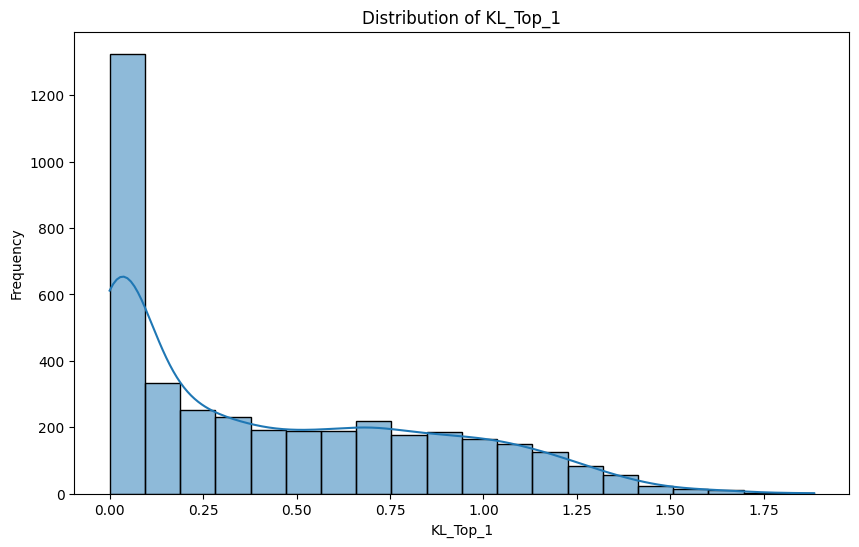

=== Statistical Summary for KL_Top_1 ===
Mean: 0.4331311868140661
Standard Deviation: 0.4259288213546221
Median: 0.3014820000126843
1st Quartile: 0.03295578651681958
3rd Quartile: 0.7591854046716708




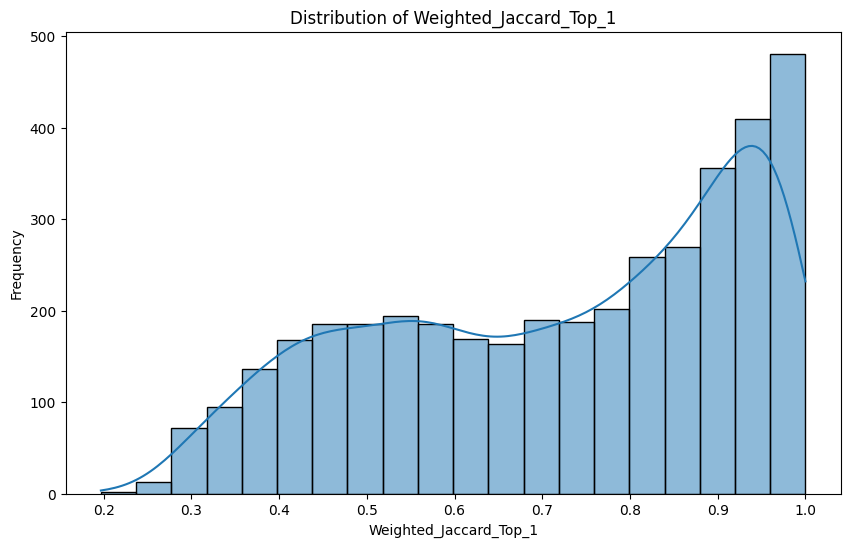

=== Statistical Summary for Weighted_Jaccard_Top_1 ===
Mean: 0.7219287894432237
Standard Deviation: 0.20730095870124804
Median: 0.7625812212013382
1st Quartile: 0.5467172912988183
3rd Quartile: 0.9111988756353022




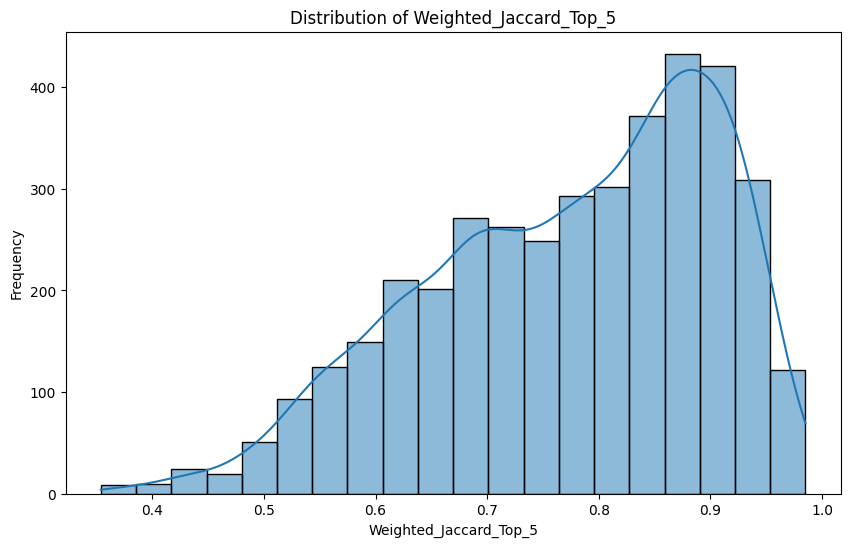

=== Statistical Summary for Weighted_Jaccard_Top_5 ===
Mean: 0.7738589319078247
Standard Deviation: 0.1285370828753697
Median: 0.7954567786406213
1st Quartile: 0.6820642400174851
3rd Quartile: 0.8806179571989066




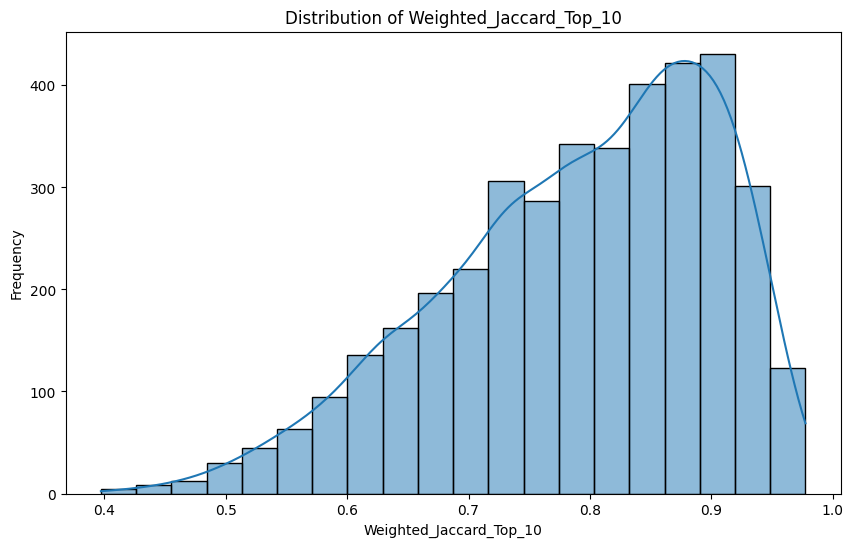

=== Statistical Summary for Weighted_Jaccard_Top_10 ===
Mean: 0.7908725656974056
Standard Deviation: 0.11215929881021625
Median: 0.8088514986340272
1st Quartile: 0.717520255905066
3rd Quartile: 0.8813235953923773




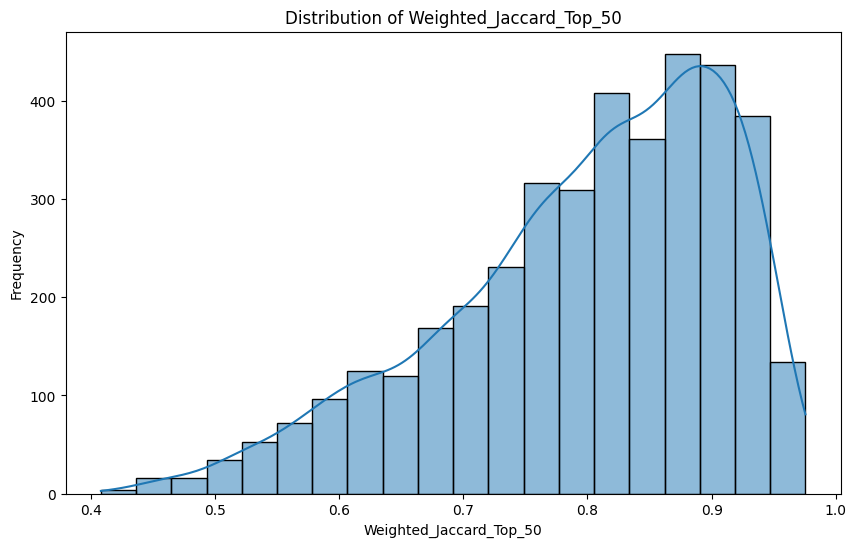

=== Statistical Summary for Weighted_Jaccard_Top_50 ===
Mean: 0.7989720317891768
Standard Deviation: 0.11267668793985938
Median: 0.8205181528108595
1st Quartile: 0.7306772900718335
3rd Quartile: 0.8888586414700133




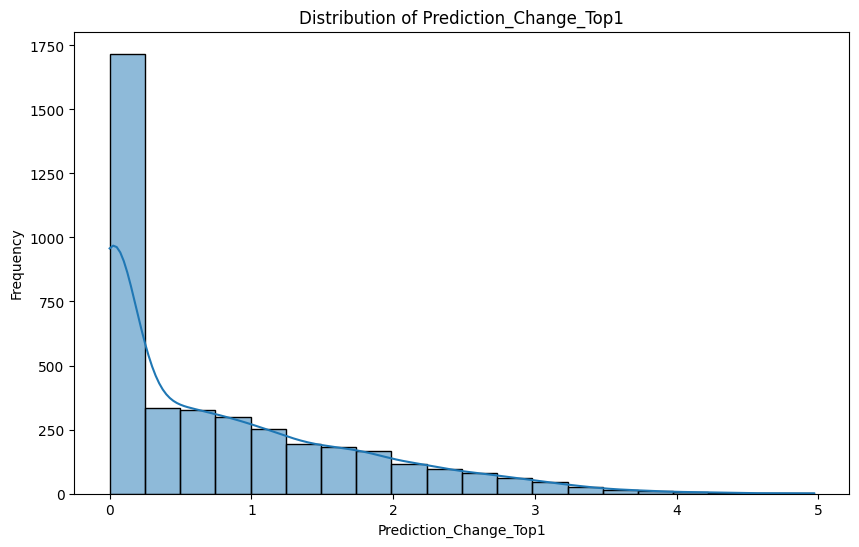

=== Statistical Summary for Prediction_Change_Top1 ===
Mean: 0.7610422046306696
Standard Deviation: 0.9031731023782633
Median: 0.43977200984954834
1st Quartile: 0.0
3rd Quartile: 1.2615007758140564




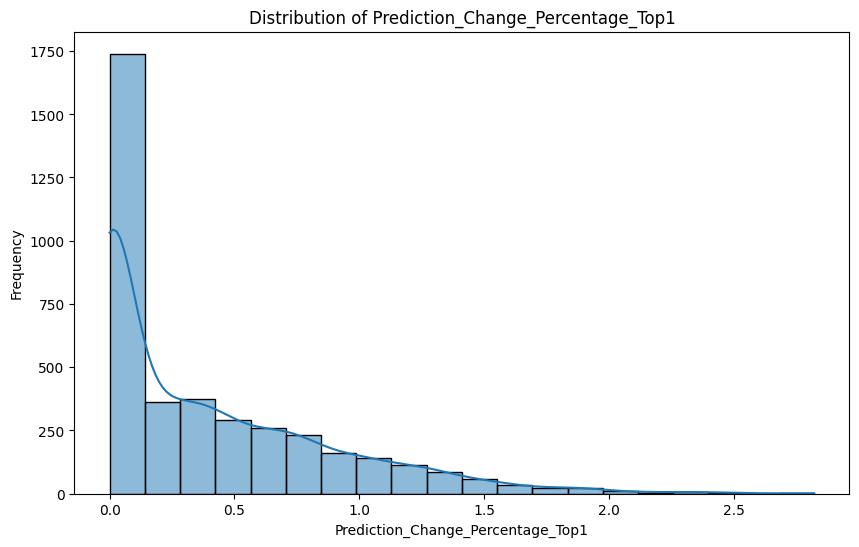

=== Statistical Summary for Prediction_Change_Percentage_Top1 ===
Mean: 0.39607016487492674
Standard Deviation: 0.4758544388434742
Median: 0.22493481636047363
1st Quartile: 0.0
3rd Quartile: 0.661130964756012




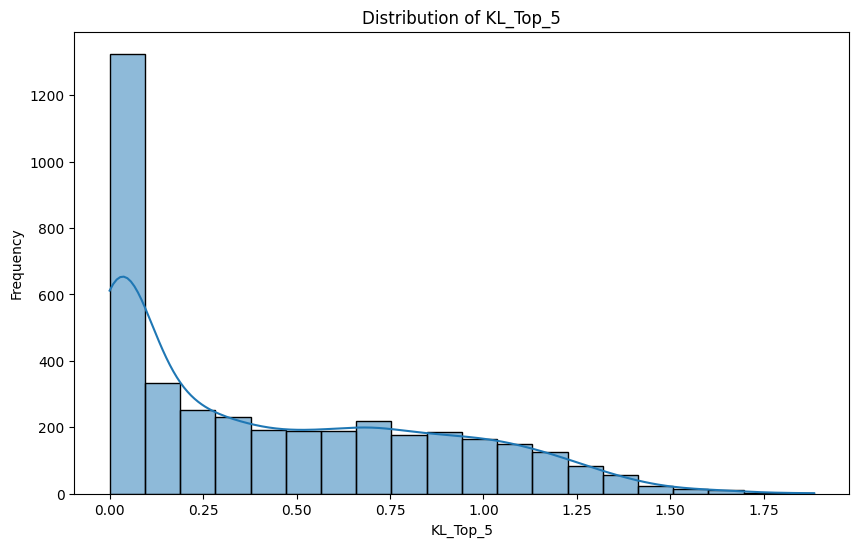

=== Statistical Summary for KL_Top_5 ===
Mean: 0.4331311868140661
Standard Deviation: 0.4259288213546221
Median: 0.3014820000126843
1st Quartile: 0.03295578651681958
3rd Quartile: 0.7591854046716708




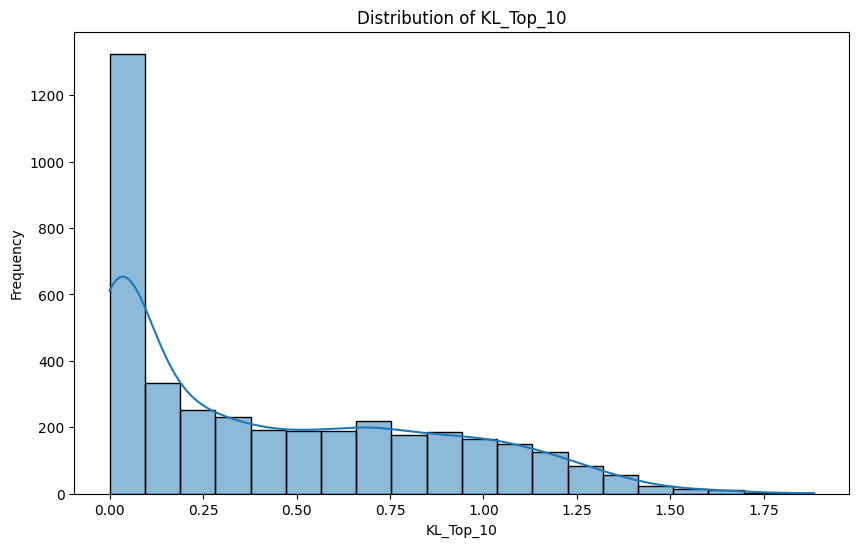

=== Statistical Summary for KL_Top_10 ===
Mean: 0.4331311868140661
Standard Deviation: 0.4259288213546221
Median: 0.3014820000126843
1st Quartile: 0.03295578651681958
3rd Quartile: 0.7591854046716708




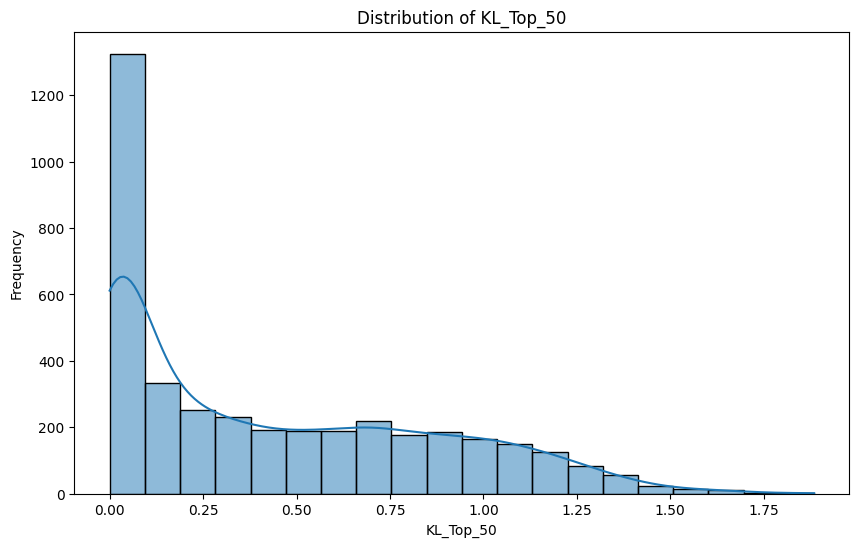

=== Statistical Summary for KL_Top_50 ===
Mean: 0.4331311868140661
Standard Deviation: 0.4259288213546221
Median: 0.3014820000126843
1st Quartile: 0.03295578651681958
3rd Quartile: 0.7591854046716708




In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # 这是一个用于数据可视化的Python库

# 初始化一个用于存储所有度量数据的字典
all_metrics = {}

# 指定保存.npy文件的根目录
root_folder = "/home/workstation/code/XAImethods/hf_cam_dev/evaluation/google/vit-large-patch32-384/GradCAM"

# 遍历根目录下的所有子目录
for subfolder in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder)
    
    # 检查是否为目录
    if os.path.isdir(subfolder_path):
        npy_file_path = os.path.join(subfolder_path, 'similarity_metrics.npy')
        
        # 检查.npy文件是否存在
        if os.path.exists(npy_file_path):
            # 加载.npy文件
            metrics = np.load(npy_file_path, allow_pickle=True).item()
            
            # 将这些度量值添加到all_metrics字典中
            for key, value in metrics.items():
                if key not in all_metrics:
                    all_metrics[key] = []
                all_metrics[key].append(value)

# 绘制直方图和进行统计分析
for metric, values in all_metrics.items():
    if 'Prediction_Change_Top_1' not in metric and 'Prediction_Change_Percentage_Top_1' not in metric:
        plt.figure(figsize=(10, 6))
        
        # 使用Seaborn库绘制带有KDE的直方图
        sns.histplot(values, bins=20, kde=True)
        
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        
        # 显示图像
        plt.show()
        
        # 统计分析
        mean_value = np.mean(values)
        std_dev = np.std(values)
        median_value = np.median(values)
        quartiles = np.percentile(values, [25, 75])
        
        print(f"=== Statistical Summary for {metric} ===")
        print(f"Mean: {mean_value}")
        print(f"Standard Deviation: {std_dev}")
        print(f"Median: {median_value}")
        print(f"1st Quartile: {quartiles[0]}")
        print(f"3rd Quartile: {quartiles[1]}")
        print("\n")




In [ ]:
# # Importing required libraries
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import os
# import pandas as pd

# # Helper function to read all similarity metrics saved as .npy files into a list of dictionaries
# def read_saved_metrics(root_folder):
#     all_similarities = []
#     for subfolder in os.listdir(root_folder):
#         subfolder_path = os.path.join(root_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             similarity_file_path = os.path.join(subfolder_path, 'similarity_metrics.npy')
#             if os.path.exists(similarity_file_path):
#                 similarities = np.load(similarity_file_path, allow_pickle=True).item()
#                 all_similarities.append(similarities)
#     return all_similarities

# # Root folder where all the similarity metrics are saved
# root_folder = "/home/workstation/code/XAImethods/hf_cam_dev/results/masked"  # Replace with your directory

# # Read the saved metrics
# all_similarities = read_saved_metrics(root_folder)

# # Convert the list of dictionaries to a DataFrame for easier manipulation
# df = pd.DataFrame(all_similarities)

# # Visualization and Analysis
# metrics_to_analyze = ["Jaccard_Top_1", "Dice_Top_1", "Cosine_Top_1", "Euclidean_Top_1", "KL_Top_1"]

# # Histograms
# for metric in metrics_to_analyze:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df[metric], bins=20, kde=True)
#     plt.title(f'Distribution of {metric}')
#     plt.xlabel(metric)
#     plt.ylabel('Frequency')
#     plt.show()

# # Boxplots/Violin plots
# for metric in metrics_to_analyze:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df[metric])
#     plt.title(f'Boxplot of {metric}')
#     plt.xlabel(metric)
#     plt.show()

# # Heatmap for correlation
# correlation_matrix = df[metrics_to_analyze].corr()
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True)
# plt.title('Heatmap of Correlations Between Metrics')
# plt.show()

# # Statistical Analysis
# for metric in metrics_to_analyze:
#     mean = df[metric].mean()
#     std_dev = df[metric].std()
#     median = df[metric].median()
#     q1 = df[metric].quantile(0.25)
#     q3 = df[metric].quantile(0.75)
    
#     print(f"{metric}: Mean = {mean}, Std Dev = {std_dev}, Median = {median}, Q1 = {q1}, Q3 = {q3}")

# # For further analysis like clustering or anomaly detection, you can proceed with df DataFrame
# # df now contains all your similarity metrics and can be used for advanced statistical methods.


In [ ]:
# # Importing the necessary libraries to read and display .npy file contents
# import numpy as np

# def display_npy_file_content(npy_file_path):
#     """
#     Display the content of a .npy file.
#     """
#     if not os.path.exists(npy_file_path):
#         return f"File {npy_file_path} doesn't exist."
#     npy_content = np.load(npy_file_path, allow_pickle=True).item()
#     return npy_content

# # Sample usage
# # Assuming the file path is "/path/to/your/file.npy"
# file_path = "/home/workstation/code/XAImethods/hf_cam_dev/results/masked/ILSVRC2012_val_00000171/original_scores.npy"

# # Display the content
# content = display_npy_file_content(file_path)
# content
